In [1]:
import math
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Bernoulli
from torch.autograd import Variable
from itertools import count
import matplotlib.pyplot as plt
import random
import numpy as np
#import gym
from IPython.display import clear_output

In [2]:
pwd

'/home/jovyan/nas/1_user/dskim@agilesoda.ai'

In [3]:
train1 = pd.read_csv("./basd/examples/data/uci_creditcard-train-0.0-0.0.csv")

In [4]:
test1 = pd.read_csv("./basd/examples/data/uci_creditcard-test-0.0-0.0.csv")

In [5]:
train1[:10]

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE   AGE  PAY_0  PAY_2  PAY_3  \
0   2.0   120000.0  2.0        2.0       2.0  26.0   -1.0    2.0    0.0   
1   3.0    90000.0  2.0        2.0       2.0  34.0    0.0    0.0    0.0   
2   4.0    50000.0  2.0        2.0       1.0  37.0    0.0    0.0    0.0   
3   6.0    50000.0  1.0        1.0       2.0  37.0    0.0    0.0    0.0   
4   9.0   140000.0  2.0        3.0       1.0  28.0    0.0    0.0    2.0   
5  10.0    20000.0  1.0        3.0       2.0  35.0   -2.0   -2.0   -2.0   
6  11.0   200000.0  2.0        3.0       2.0  34.0    0.0    0.0    2.0   
7  13.0   630000.0  2.0        2.0       2.0  41.0   -1.0    0.0   -1.0   
8  14.0    70000.0  1.0        2.0       2.0  30.0    1.0    2.0    2.0   
9  15.0   250000.0  1.0        1.0       2.0  29.0    0.0    0.0    0.0   

   PAY_4  ...  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0    0.0  ...       0.0    1000.0    1000.0    1000.0       0.0    2000.0   
1    0.0  ...    1518.0    1500.0    1000.0    1000.0    1000.0    5000.0   
2    0.0  ...    2000.0    2019.0    1200.0    1100.0    1069.0    1000.0   
3    0.0  ...    2500.0    1815.0     657.0    1000.0    1000.0     800.0   
4    0.0  ...    3329.0       0.0     432.0    1000.0    1000.0    1000.0   
5   -2.0  ...       0.0       0.0       0.0   13007.0    1122.0       0.0   
6    0.0  ...    2306.0      12.0      50.0     300.0    3738.0      66.0   
7   -1.0  ...    1000.0    6500.0    6500.0    6500.0    2870.0       0.0   
8    0.0  ...    3200.0       0.0    3000.0    3000.0    1500.0       0.0   
9    0.0  ...    3000.0    3000.0    3000.0    3000.0    3000.0    3000.0   

   default payment next month  sep_idx   PROFIT      LOSS  
0                         1.0        1   6000.0  120000.0  
1                         0.0        1   4500.0   90000.0  
2                         0.0        1   2500.0   50000.0  
3                         0.0        1   2500.0   50000.0  
4                         0.0        1   7000.0  140000.0  
5                         0.0        1   1000.0   20000.0  
6                         0.0        1  10000.0  200000.0  
7                         0.0        1  31500.0  630000.0  
8                         1.0        1   3500.0   70000.0  
9                         0.0        1  12500.0  250000.0  

[10 rows x 28 columns]

In [6]:

train = train1.to_numpy()
test = test1.to_numpy()

plt.ion()


In [7]:
def z_score_normalize(data) :
    normal_data = data
    for columns in range(data.shape[1]-2) :
        #for a in range(data.shape[0]) 
        #print(np.max(data[:data.shape[0]][columns]))
        #if 
        if columns !=24:
        

            #print(np.mean(data[:data.shape[0],columns]))
            #print(np.std(data[:data.shape[0],columns]))
            normal_data[:data.shape[0],columns] = (data[:data.shape[0],columns] - np.min(data[:data.shape[0],columns])) /\
                                        (np.max(data[:data.shape[0],columns])-np.min(data[:data.shape[0],columns]))

    return normal_data


normalized_train = z_score_normalize(train)
normalized_test = z_score_normalize(test)

<ipython-input-7-accfacdde12f>:12: RuntimeWarning: invalid value encountered in true_divide
  normal_data[:data.shape[0],columns] = (data[:data.shape[0],columns] - np.min(data[:data.shape[0],columns])) /\


In [8]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, transition):
        """transition 저장"""
        if len(self.memory) < self.capacity:
            self.memory.append(transition)
        self.position = (self.position + 1) % self.capacity
        if len(self.memory) >= self.capacity: 
            self.memory[self.position] = transition

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [9]:
class NN(nn.Module):

    def __init__(self, input_size, hidden_size, action_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        #self.ba1 = nn.BatchNorm1d((hidden_size))
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        #self.ba2 = nn.BatchNorm1d((hidden_size*2))
        self.fc3 = nn.Linear(hidden_size,hidden_size)
        #self.ba3 = nn.BatchNorm1d((hidden_size//2))
        self.fc4 = nn.Linear(hidden_size,1) ## Classification에서 0을 선택할 확률이 OUTPUT 
       
        
    ## 최적화 중에 다음 행동을 결정하기 위해서 하나의 요소 또는 배치를 이용해 호촐됨.
    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = F.selu(self.fc2(x))
        x = F.relu(self.fc3(x))
        ## 마지막 결과값이 확률로 나오게 만듬 . 
        x = torch.sigmoid(self.fc4(x))

        return x

In [10]:
train.shape[1]

28

In [11]:
BATCH_SIZE =256
hidden_size = 120
train_num = 50

## Input data size는 Column의 개수 -1 마지막 두개의 열은 Classification과 Valide Set을 구분.
input_size = train.shape[1]-5
## Classification 이므로 Action은 2가 나옴.
action_size = 2

## 큰 차원의 데이터를 처리하기 위해서 NN을 사용
policy_net = NN(input_size,hidden_size, action_size)
target_net = NN(input_size,hidden_size, action_size)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform(m.weight)
       # m.bias.data.fill_(0.01)
policy_net.apply(init_weights)


## 최적화 기준 RMS(Root Mean Squeare)
optimizer = optim.Adam(policy_net.parameters(), lr = 0.0001)
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
#scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5000,10000], gamma=0.2)


<ipython-input-11-e940513c94ed>:18: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(m.weight)


In [12]:
def get_reward(action,target) :
    if action == target :
        accuracy = 1
        if action == 1 : 
            reward = 18640/23996
            tp=1
            tn=0
            fp=0
            fn=0
        elif action == 0 :
            reward = 5356/23996
            tp=0
            tn=1
            fp=0
            fn=0
    else :
        accuracy = 0
        if action == 1 :
            reward = -23996 / 5356
            tp=0
            tn=0
            fp=1
            fn=0
        elif action == 0 :
            reward = - 23996 / 18640
            tp=0
            tn=0
            fp=0
            fn=1
    
    return reward,accuracy,tp,tn,fp,fn

In [13]:
def get_reward1(action,target,target1) :
    if action == target :
        accuracy = 1
        if action == 1 : 
            reward =18640/23996
            tp=1
            tn=0
            fp=0
            fn=0
        elif action == 0 :
            reward = 5356/23996
            tp=0
            tn=1
            fp=0
            fn=0
    else :
        accuracy = 0
            
            
            
        if action ==1:
            reward=-5356/23996*0.4
            tp=0
            tn=0
            fp=1
            fn=0
            
        elif action ==0:
            reward = - target1*0.1
            
            tp=0
            tn=0
            fp=0
            fn=1
    return reward,accuracy,tp,tn,fp,fn

In [14]:
- 5356/23996*0.25

-0.05580096682780463

In [15]:
(- 5356/23996)*0.25

-0.05580096682780463

In [16]:
def plot_durations(reward):
    plt.figure(2)
    plt.clf()
    reward = torch.FloatTensor(reward)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    #plt.axhline(y=90,linestyle ='--')
    plt.plot(reward.numpy())
    if len(reward) >= 100:
        means = reward.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  
    

In [17]:
len(normalized_train)

23996

In [18]:
18640/23996

0.7767961326887814

In [19]:
5356/23996

0.22320386731121852

Current_train_num :  9 LOSS :  -1.0952470302581787
0.10256586968898773
Current_train_num :  19 LOSS :  -1.1207013130187988
0.10906615853309631
Current_train_num :  29 LOSS :  -1.0421768426895142
0.11019495129585266
Current_train_num :  39 LOSS :  -1.292396068572998
0.08746235072612762
Current_train_num :  49 LOSS :  -1.3586138486862183
0.07750189304351807
Current_train_num :  59 LOSS :  -1.346203088760376
0.08139516413211823
Current_train_num :  69 LOSS :  -1.3074877262115479
0.10605751723051071
Current_train_num :  79 LOSS :  -1.2020199298858643
0.09844323247671127
Current_train_num :  89 LOSS :  -1.0959250926971436
0.10917612910270691
Current_train_num :  99 LOSS :  -1.1701387166976929
0.10217535495758057


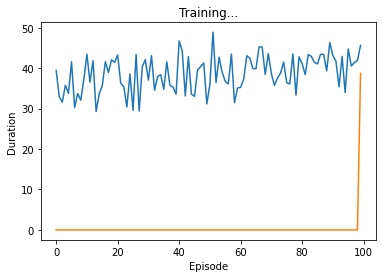

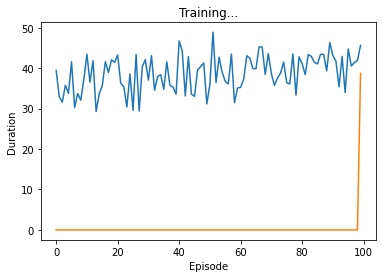

Current_train_num :  6003 Accuracy :  0.7917707812760286
F1 0.09675090252707581
67 38 1213
99
train Current_train_num :  23995 Accuracy :  0.7805792873515316
F1 0.05082912761355443
141 51 5215
Current_train_num :  109 LOSS :  -1.0867408514022827
0.07732308655977249
Current_train_num :  119 LOSS :  -0.976980447769165
0.08874983340501785
Current_train_num :  129 LOSS :  -1.335977554321289
0.07304871827363968
Current_train_num :  139 LOSS :  -1.218699336051941
0.06905900686979294
Current_train_num :  149 LOSS :  -0.8764275908470154
0.08358413726091385
Current_train_num :  159 LOSS :  -0.9492798447608948
0.07165732234716415
Current_train_num :  169 LOSS :  -1.0126957893371582
0.07533644884824753
Current_train_num :  179 LOSS :  -0.8235368132591248
0.09070754051208496
Current_train_num :  189 LOSS :  -0.6573495864868164
0.08804290741682053
Current_train_num :  199 LOSS :  -0.7582942247390747
0.06629160791635513


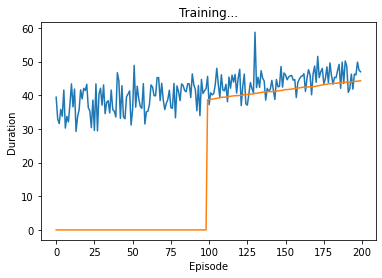

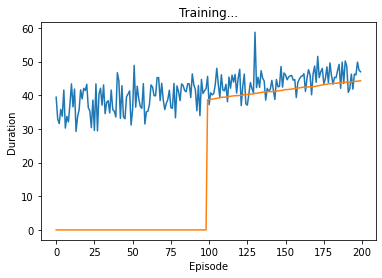

Current_train_num :  6003 Accuracy :  0.7896051974012993
F1 0.05812220566318927
39 23 1241
train Current_train_num :  23995 Accuracy :  0.7793290268806001
F1 0.03251735476799415
89 29 5267
Current_train_num :  209 LOSS :  -0.9642190337181091
0.03407944366335869
Current_train_num :  219 LOSS :  -1.322462797164917
0.06887664645910263
Current_train_num :  229 LOSS :  -1.2909348011016846
0.025397678837180138
Current_train_num :  239 LOSS :  -0.8976795077323914
0.07764589041471481
Current_train_num :  249 LOSS :  -0.9719033241271973
0.043300334364175797
Current_train_num :  259 LOSS :  -0.740896463394165
0.06311793625354767
Current_train_num :  269 LOSS :  -1.0081350803375244
0.0425480492413044
Current_train_num :  279 LOSS :  -0.7026870250701904
0.05867784097790718
Current_train_num :  289 LOSS :  -0.7992023229598999
0.042373113334178925
Current_train_num :  299 LOSS :  -0.8231210708618164
0.04274412989616394


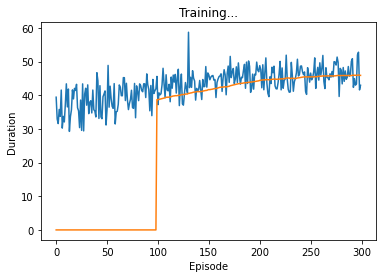

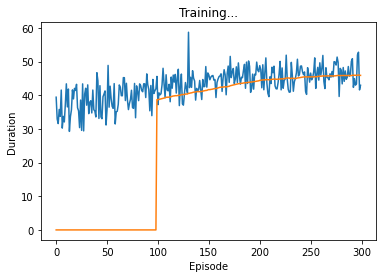

Current_train_num :  6003 Accuracy :  0.7944361152756955
F1 0.1357592722183345
97 52 1183
299
train Current_train_num :  23995 Accuracy :  0.7819545738695561
F1 0.07495138766130457
212 89 5144
Current_train_num :  309 LOSS :  -0.5374893546104431
0.06493325531482697
Current_train_num :  319 LOSS :  -1.0440360307693481
0.04557183384895325
Current_train_num :  329 LOSS :  -1.0755372047424316
0.04351101070642471
Current_train_num :  339 LOSS :  -0.8737765550613403
0.08499670028686523
Current_train_num :  349 LOSS :  -0.6877730488777161
0.06742461025714874
Current_train_num :  359 LOSS :  -1.0057611465454102
0.026763439178466797
Current_train_num :  369 LOSS :  -0.5663028955459595
0.05828274041414261
Current_train_num :  379 LOSS :  -1.2184969186782837
0.0477604903280735
Current_train_num :  389 LOSS :  -0.990623950958252
0.05241112411022186
Current_train_num :  399 LOSS :  -1.0380544662475586
0.05329025909304619


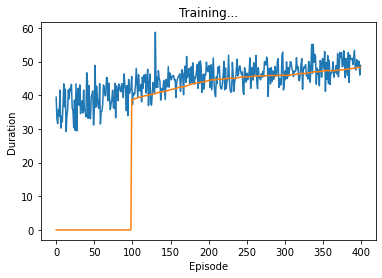

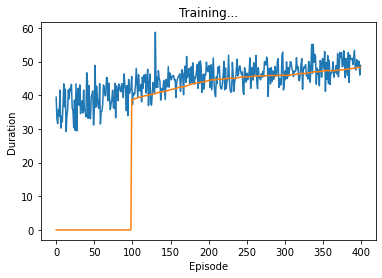

Current_train_num :  6003 Accuracy :  0.8060969515242379
F1 0.35025097601784716
314 199 966
399
train Current_train_num :  23995 Accuracy :  0.7939987497395291
F1 0.26516052318668254
892 480 4464
Current_train_num :  409 LOSS :  -0.9728342890739441
0.02902168594300747
Current_train_num :  419 LOSS :  -1.0060601234436035
0.05300476774573326
Current_train_num :  429 LOSS :  -0.576854944229126
0.06813012063503265
Current_train_num :  439 LOSS :  -0.8303934335708618
0.04501383379101753
Current_train_num :  449 LOSS :  -0.5628716945648193
0.060612838715314865
Current_train_num :  459 LOSS :  -0.7742694616317749
0.0381116047501564
Current_train_num :  469 LOSS :  -0.8877937197685242
0.047222863882780075
Current_train_num :  479 LOSS :  -0.847099781036377
0.05213126167654991
Current_train_num :  489 LOSS :  -0.6786302328109741
0.04146145284175873
Current_train_num :  499 LOSS :  -0.8010591268539429
0.04481587931513786


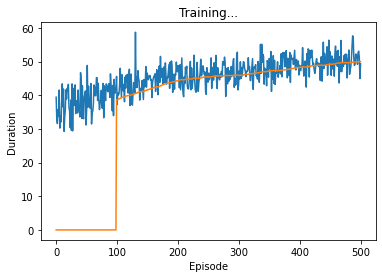

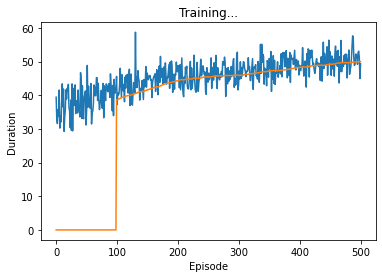

Current_train_num :  6003 Accuracy :  0.8049308678993836
F1 0.445600756859035
471 363 809
499
train Current_train_num :  23995 Accuracy :  0.8004167534903105
F1 0.379854997410668
1467 901 3889
Current_train_num :  509 LOSS :  -0.752106785774231
0.0336601547896862
Current_train_num :  519 LOSS :  -0.7060871720314026
0.06033363938331604
Current_train_num :  529 LOSS :  -0.780271053314209
0.01939653605222702
Current_train_num :  539 LOSS :  -0.5511142611503601
0.08060508966445923
Current_train_num :  549 LOSS :  -0.858086109161377
0.05027911812067032
Current_train_num :  559 LOSS :  -0.8782014846801758
0.059363700449466705
Current_train_num :  569 LOSS :  -0.6286687254905701
0.03585371747612953
Current_train_num :  579 LOSS :  -0.6857895255088806
0.050997696816921234
Current_train_num :  589 LOSS :  -0.5882661938667297
0.03498657047748566
Current_train_num :  599 LOSS :  -0.47435617446899414
0.031793780624866486


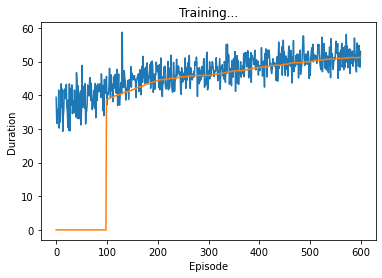

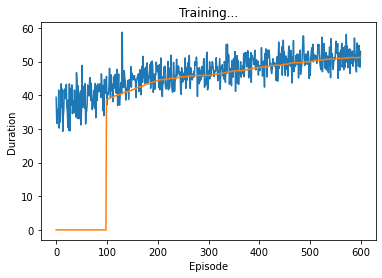

Current_train_num :  6003 Accuracy :  0.8064301182741962
F1 0.4490762671719564
474 357 806
599
train Current_train_num :  23995 Accuracy :  0.8007501562825589
F1 0.3820108555182218
1478 904 3878
Current_train_num :  609 LOSS :  -0.4614688754081726
0.0326211042702198
Current_train_num :  619 LOSS :  -0.6089842319488525
0.04950505122542381
Current_train_num :  629 LOSS :  -0.5907526016235352
0.02508372627198696
Current_train_num :  639 LOSS :  -0.7474285960197449
0.0348617285490036
Current_train_num :  649 LOSS :  -0.5606459379196167
0.05777306854724884
Current_train_num :  659 LOSS :  -0.49879682064056396
0.03827877715229988
Current_train_num :  669 LOSS :  -0.6581931114196777
0.01712220162153244
Current_train_num :  679 LOSS :  -0.5100812315940857
0.06230807676911354
Current_train_num :  689 LOSS :  -0.47885894775390625
0.024589328095316887
Current_train_num :  699 LOSS :  -0.504159688949585
0.0202333927154541


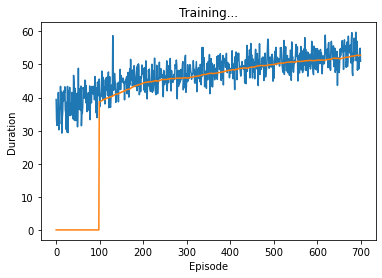

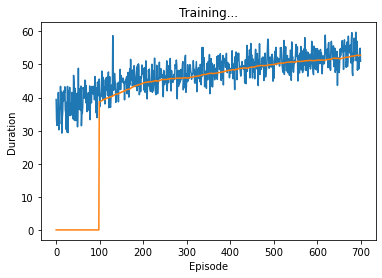

Current_train_num :  6003 Accuracy :  0.8060969515242379
F1 0.47921323200715243
536 421 744
699
train Current_train_num :  23995 Accuracy :  0.8005001041883726
F1 0.4143835616438356
1694 1126 3662
Current_train_num :  709 LOSS :  -0.3237295150756836
0.05956753343343735
Current_train_num :  719 LOSS :  -0.46764707565307617
0.045922376215457916
Current_train_num :  729 LOSS :  -0.5137298107147217
0.03389127179980278
Current_train_num :  739 LOSS :  -0.4580695331096649
0.023393234238028526
Current_train_num :  749 LOSS :  -0.2491203248500824
0.021670034155249596
Current_train_num :  759 LOSS :  -0.5717307925224304
0.030877919867634773
Current_train_num :  769 LOSS :  -0.6086040735244751
0.02771179936826229
Current_train_num :  779 LOSS :  -0.4069814682006836
0.043283846229314804
Current_train_num :  789 LOSS :  -0.6487346291542053
0.02940724976360798
Current_train_num :  799 LOSS :  -0.662494421005249
0.013688660226762295


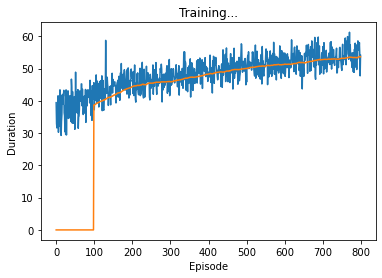

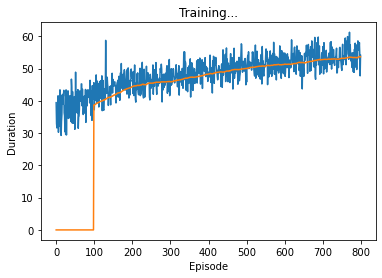

Current_train_num :  6003 Accuracy :  0.8059303681492587
F1 0.4948006932409012
571 457 709
799
train Current_train_num :  23995 Accuracy :  0.7995832465096895
F1 0.42792578496669836
1799 1253 3557
Current_train_num :  809 LOSS :  -0.3774231970310211
0.045270610600709915
Current_train_num :  819 LOSS :  -0.4796059727668762
0.033551331609487534
Current_train_num :  829 LOSS :  -0.4035636782646179
0.043349869549274445
Current_train_num :  839 LOSS :  -0.19682757556438446
0.024421337991952896
Current_train_num :  849 LOSS :  -0.48531296849250793
0.026519596576690674
Current_train_num :  859 LOSS :  -0.6848583221435547
0.015888074412941933
Current_train_num :  869 LOSS :  -0.5863399505615234
0.03225348889827728
Current_train_num :  879 LOSS :  -0.31230199337005615
0.04329482838511467
Current_train_num :  889 LOSS :  -0.37559816241264343
0.03364307060837746
Current_train_num :  899 LOSS :  -0.19633974134922028
0.023967837914824486


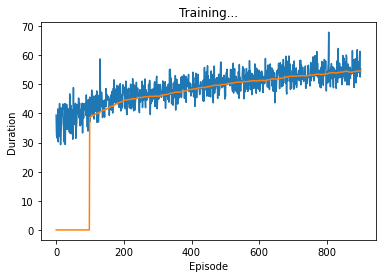

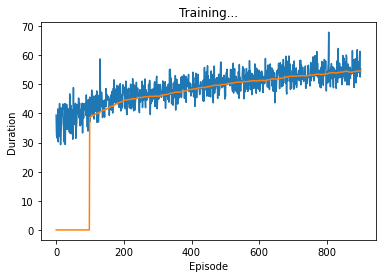

Current_train_num :  6003 Accuracy :  0.8004331167749459
F1 0.5010403662089056
602 521 678
899
train Current_train_num :  23995 Accuracy :  0.7994998958116274
F1 0.4445983379501385
1926 1382 3430
Current_train_num :  909 LOSS :  -0.44250860810279846
0.012104376219213009
Current_train_num :  919 LOSS :  -0.3771185874938965
0.0390019416809082
Current_train_num :  929 LOSS :  -0.5279227495193481
0.030542733147740364
Current_train_num :  939 LOSS :  -0.8587537407875061
0.015762025490403175
Current_train_num :  949 LOSS :  -0.44329217076301575
0.028762087225914
Current_train_num :  959 LOSS :  -0.4255738854408264
0.06392571330070496
Current_train_num :  969 LOSS :  -0.43702974915504456
0.018418094143271446
Current_train_num :  979 LOSS :  -0.674521267414093
0.02925899438560009
Current_train_num :  989 LOSS :  -0.5368908047676086
0.021309275180101395
Current_train_num :  999 LOSS :  -0.3930172026157379
0.023674091324210167


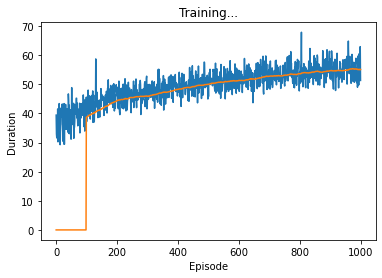

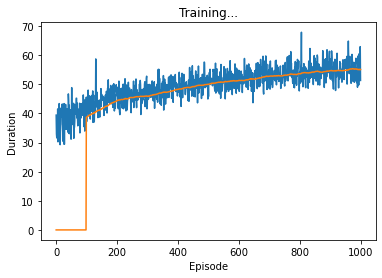

Current_train_num :  6003 Accuracy :  0.7956021989005497
F1 0.49381698268755153
599 547 681
train Current_train_num :  23995 Accuracy :  0.7983329860387581
F1 0.44736241150947703
1959 1443 3397
Current_train_num :  1009 LOSS :  -0.25790661573410034
0.012315599247813225
Current_train_num :  1019 LOSS :  -0.25572067499160767
0.030457450076937675
Current_train_num :  1029 LOSS :  -0.3942215144634247
0.017649713903665543
Current_train_num :  1039 LOSS :  -0.5284988880157471
0.02950523979961872
Current_train_num :  1049 LOSS :  -0.5119934678077698
0.02411133050918579
Current_train_num :  1059 LOSS :  -0.5142223238945007
0.024176329374313354
Current_train_num :  1069 LOSS :  -0.4158361554145813
0.024960044771432877
Current_train_num :  1079 LOSS :  -0.16181215643882751
0.05183297395706177
Current_train_num :  1089 LOSS :  -0.28837499022483826
0.02321382611989975
Current_train_num :  1099 LOSS :  -0.45444709062576294
0.03231700882315636


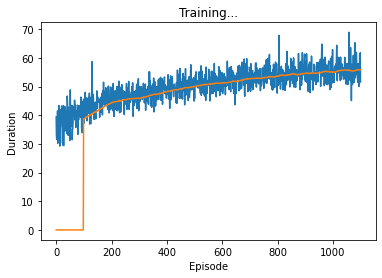

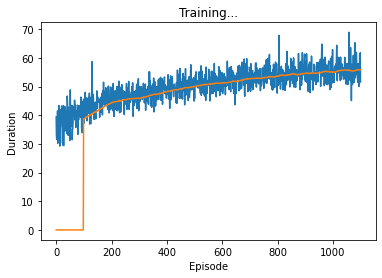

Current_train_num :  6003 Accuracy :  0.7906046976511744
F1 0.5031595576619273
637 615 643
1099
train Current_train_num :  23995 Accuracy :  0.7967909981246093
F1 0.46199669056811915
2094 1615 3262
Current_train_num :  1109 LOSS :  -0.3587261736392975
0.030305394902825356
Current_train_num :  1119 LOSS :  -0.45332688093185425
0.017393633723258972
Current_train_num :  1129 LOSS :  -0.4379757344722748
0.027374714612960815
Current_train_num :  1139 LOSS :  -0.4522818624973297
0.04641120508313179
Current_train_num :  1149 LOSS :  -0.49181902408599854
0.020028075203299522
Current_train_num :  1159 LOSS :  -0.4790722131729126
0.03403981775045395
Current_train_num :  1169 LOSS :  -0.38320398330688477
0.016015026718378067
Current_train_num :  1179 LOSS :  -0.2557917535305023
0.02991444244980812
Current_train_num :  1189 LOSS :  -0.2875342071056366
0.025818198919296265
Current_train_num :  1199 LOSS :  -0.2884025573730469
0.016024785116314888


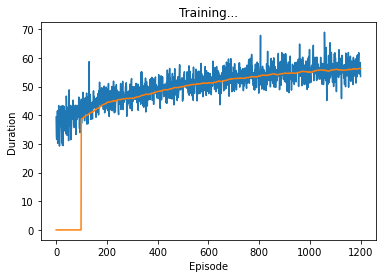

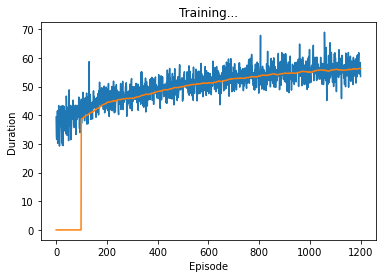

Current_train_num :  6003 Accuracy :  0.7991004497751124
F1 0.5030876904075752
611 538 669
train Current_train_num :  23995 Accuracy :  0.799916649301938
F1 0.45678733031674207
2019 1465 3337
Current_train_num :  1209 LOSS :  -0.4619362950325012
0.02055421471595764
Current_train_num :  1219 LOSS :  -0.3514813184738159
0.03296268731355667
Current_train_num :  1229 LOSS :  -0.4149271249771118
0.02212304249405861
Current_train_num :  1239 LOSS :  -0.4741671681404114
0.010719588957726955
Current_train_num :  1249 LOSS :  -0.33395078778266907
0.029616914689540863
Current_train_num :  1259 LOSS :  -0.3532593548297882
0.01966742053627968
Current_train_num :  1269 LOSS :  -0.4190591871738434
0.026048365980386734
Current_train_num :  1279 LOSS :  -0.5337666273117065
0.022987136617302895
Current_train_num :  1289 LOSS :  -0.36613282561302185
0.01818302646279335
Current_train_num :  1299 LOSS :  -0.18278975784778595
0.02124164253473282


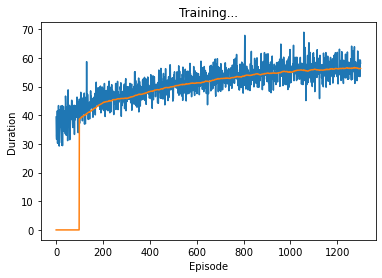

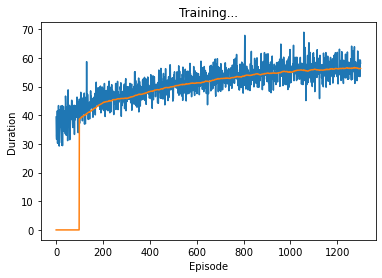

Current_train_num :  6003 Accuracy :  0.794935865400633
F1 0.5079872204472844
636 588 644
1299
train Current_train_num :  23995 Accuracy :  0.7989164409251928
F1 0.46674033149171273
2112 1582 3244
Current_train_num :  1309 LOSS :  -0.19442668557167053
0.027315372601151466
Current_train_num :  1319 LOSS :  -0.1750432848930359
0.03054669313132763
Current_train_num :  1329 LOSS :  -0.32697010040283203
0.014196835458278656
Current_train_num :  1339 LOSS :  -0.3749000132083893
0.016077857464551926
Current_train_num :  1349 LOSS :  -0.3507501780986786
0.02569441683590412
Current_train_num :  1359 LOSS :  -0.34525781869888306
0.0448550209403038
Current_train_num :  1369 LOSS :  -0.26835155487060547
0.02734246850013733
Current_train_num :  1379 LOSS :  -0.2806496024131775
0.016146255657076836
Current_train_num :  1389 LOSS :  -0.2853147089481354
0.026542164385318756
Current_train_num :  1399 LOSS :  -0.24634110927581787
0.045778315514326096


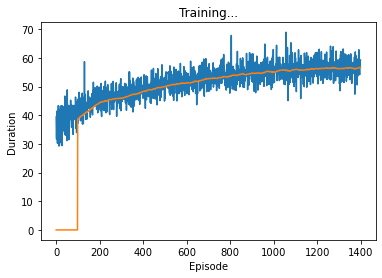

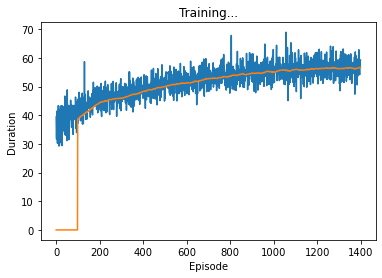

Current_train_num :  6003 Accuracy :  0.7851074462768616
F1 0.5111700113593336
675 686 605
1399
train Current_train_num :  23995 Accuracy :  0.7953323609085227
F1 0.4777801403359558
2247 1803 3109
Current_train_num :  1409 LOSS :  -0.43256813287734985
0.015241366811096668
Current_train_num :  1419 LOSS :  -0.3538276255130768
0.018607592210173607
Current_train_num :  1429 LOSS :  -0.5563551187515259
0.01655902899801731
Current_train_num :  1439 LOSS :  -0.37294790148735046
0.01349184662103653
Current_train_num :  1449 LOSS :  -0.3157825171947479
0.0111782131716609
Current_train_num :  1459 LOSS :  -0.5912186503410339
0.007538083009421825
Current_train_num :  1469 LOSS :  -0.2463926076889038
0.03918347507715225
Current_train_num :  1479 LOSS :  -0.5384050607681274
0.009776031598448753
Current_train_num :  1489 LOSS :  -0.32091981172561646
0.01404945645481348
Current_train_num :  1499 LOSS :  -0.24060368537902832
0.01145871076732874


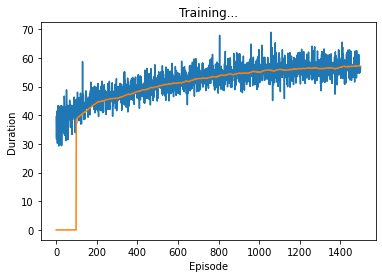

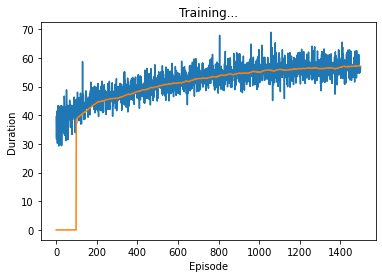

Current_train_num :  6003 Accuracy :  0.7939363651507579
F1 0.51640625
661 619 619
1499
train Current_train_num :  23995 Accuracy :  0.7982079599916649
F1 0.47501355013550134
2191 1678 3165
Current_train_num :  1509 LOSS :  -0.34435197710990906
0.00409468961879611
Current_train_num :  1519 LOSS :  -0.3238270580768585
0.01574617624282837
Current_train_num :  1529 LOSS :  -0.13557766377925873
0.025679530575871468
Current_train_num :  1539 LOSS :  -0.3241620361804962
0.024927251040935516
Current_train_num :  1549 LOSS :  -0.23665690422058105
0.030046219006180763
Current_train_num :  1559 LOSS :  -0.30067822337150574
0.019144540652632713
Current_train_num :  1569 LOSS :  -0.30727481842041016
0.006814271677285433
Current_train_num :  1579 LOSS :  -0.28620991110801697
0.022550463676452637
Current_train_num :  1589 LOSS :  -0.3184194266796112
0.018408633768558502
Current_train_num :  1599 LOSS :  -0.30867692828178406
0.015324600972235203


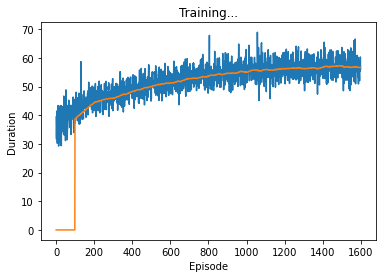

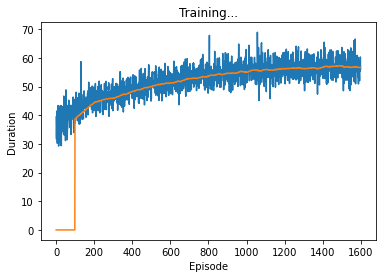

Current_train_num :  6003 Accuracy :  0.8020989505247377
F1 0.512105047189167
624 533 656
train Current_train_num :  23995 Accuracy :  0.8010835590748072
F1 0.46635367762128327
2086 1504 3270
Current_train_num :  1609 LOSS :  -0.21847042441368103
0.02793152630329132
Current_train_num :  1619 LOSS :  -0.1697262078523636
0.024181131273508072
Current_train_num :  1629 LOSS :  -0.3508526682853699
0.015653446316719055
Current_train_num :  1639 LOSS :  -0.3320198655128479
0.02924087643623352
Current_train_num :  1649 LOSS :  -0.4944048821926117
0.0412491150200367
Current_train_num :  1659 LOSS :  -0.32090914249420166
0.02525438368320465
Current_train_num :  1669 LOSS :  -0.3208578824996948
0.04032917693257332
Current_train_num :  1679 LOSS :  -0.29484331607818604
0.016107609495520592
Current_train_num :  1689 LOSS :  -0.32793086767196655
0.008420162834227085
Current_train_num :  1699 LOSS :  -0.1559198796749115
0.018837247043848038


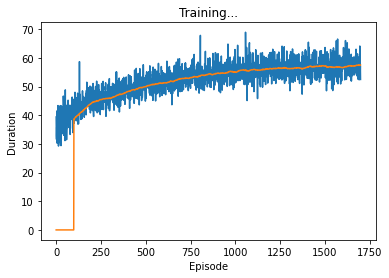

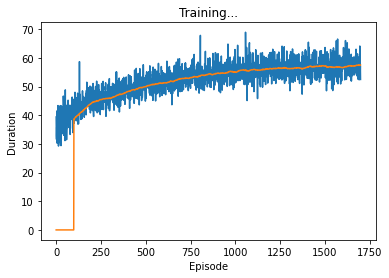

Current_train_num :  6003 Accuracy :  0.7929368649008829
F1 0.5226400613967767
681 645 599
1699
train Current_train_num :  23995 Accuracy :  0.7973327776620129
F1 0.48100725565514296
2254 1762 3102
Current_train_num :  1709 LOSS :  -0.21478112041950226
0.03158200532197952
Current_train_num :  1719 LOSS :  -0.26349905133247375
0.016310084611177444
Current_train_num :  1729 LOSS :  -0.40829285979270935
0.008897675201296806
Current_train_num :  1739 LOSS :  -0.4286363422870636
0.02048567123711109
Current_train_num :  1749 LOSS :  -0.2723935842514038
0.019408561289310455
Current_train_num :  1759 LOSS :  -0.3879224359989166
0.006268119905143976
Current_train_num :  1769 LOSS :  -0.25004082918167114
0.013141060248017311
Current_train_num :  1779 LOSS :  -0.1038345918059349
0.03412502631545067
Current_train_num :  1789 LOSS :  -0.22640609741210938
0.030612090602517128
Current_train_num :  1799 LOSS :  -0.32815492153167725
0.026609433814883232


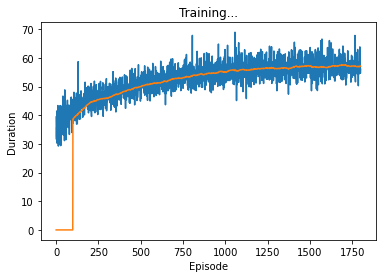

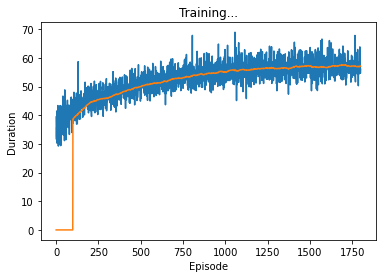

Current_train_num :  6003 Accuracy :  0.8007662835249042
F1 0.51985559566787
648 565 632
train Current_train_num :  23995 Accuracy :  0.800916857678683
F1 0.4764409379793995
2174 1596 3182
Current_train_num :  1809 LOSS :  -0.3168454170227051
0.020953575149178505
Current_train_num :  1819 LOSS :  -0.1507420390844345
0.014317763037979603
Current_train_num :  1829 LOSS :  -0.3960730731487274
0.010349473915994167
Current_train_num :  1839 LOSS :  -0.2573625445365906
0.010427571833133698
Current_train_num :  1849 LOSS :  -0.2304491251707077
0.022773275151848793
Current_train_num :  1859 LOSS :  -0.22257351875305176
0.03145229071378708
Current_train_num :  1869 LOSS :  -0.4438377618789673
0.025337787345051765
Current_train_num :  1879 LOSS :  -0.1732240915298462
0.03339563310146332
Current_train_num :  1889 LOSS :  -0.44141867756843567
0.036067988723516464
Current_train_num :  1899 LOSS :  -0.1756676435470581
0.021879127249121666


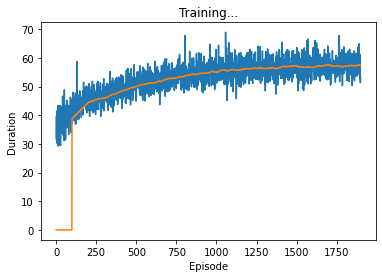

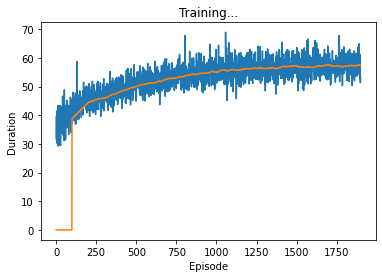

Current_train_num :  6003 Accuracy :  0.7966016991504248
F1 0.5248833592534993
675 617 605
1899
train Current_train_num :  23995 Accuracy :  0.7989164409251928
F1 0.48263293310463123
2251 1721 3105
Current_train_num :  1909 LOSS :  -0.19926013052463531
0.02388080209493637
Current_train_num :  1919 LOSS :  -0.21494610607624054
0.020804572850465775
Current_train_num :  1929 LOSS :  -0.3636144697666168
0.040296778082847595
Current_train_num :  1939 LOSS :  -0.311195969581604
0.010699516162276268
Current_train_num :  1949 LOSS :  -0.19752778112888336
0.008415690623223782
Current_train_num :  1959 LOSS :  -0.2266785204410553
0.007383052259683609
Current_train_num :  1969 LOSS :  -0.29717183113098145
0.0557536706328392
Current_train_num :  1979 LOSS :  -0.2102929800748825
0.02044614963233471
Current_train_num :  1989 LOSS :  -0.34698212146759033
0.00944946613162756
Current_train_num :  1999 LOSS :  -0.17600876092910767
0.02083377167582512


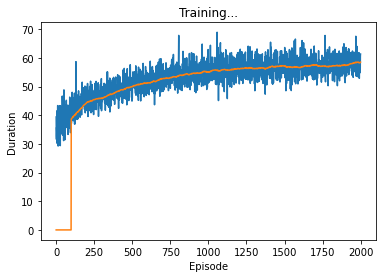

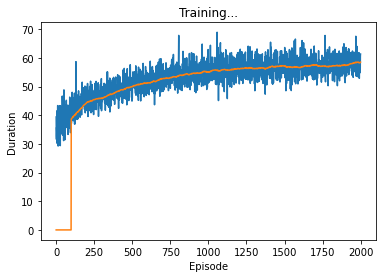

Current_train_num :  6003 Accuracy :  0.7864401132766949
F1 0.5200149644594089
695 698 585
train Current_train_num :  23995 Accuracy :  0.7964575953323609
F1 0.49109282216897593
2357 1886 2999
Current_train_num :  2009 LOSS :  -0.42329248785972595
0.01926073431968689
Current_train_num :  2019 LOSS :  -0.28881335258483887
0.022543566301465034
Current_train_num :  2029 LOSS :  -0.259743332862854
0.015191396698355675
Current_train_num :  2039 LOSS :  -0.27611595392227173
0.014348901808261871
Current_train_num :  2049 LOSS :  -0.4235731065273285
0.029868056997656822
Current_train_num :  2059 LOSS :  -0.273304283618927
0.036858249455690384
Current_train_num :  2069 LOSS :  -0.2781873941421509
0.007060237694531679
Current_train_num :  2079 LOSS :  -0.231528177857399
0.014076322317123413
Current_train_num :  2089 LOSS :  -0.3734349012374878
0.010785000398755074
Current_train_num :  2099 LOSS :  -0.2325616478919983
0.00655397679656744


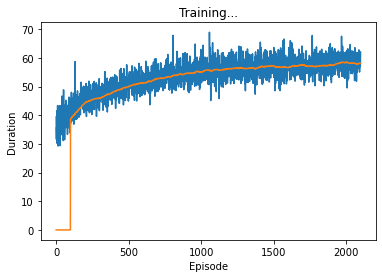

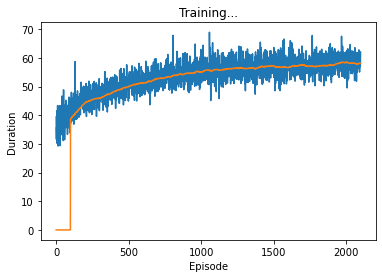

Current_train_num :  6003 Accuracy :  0.7971014492753623
F1 0.5269693441986807
679 618 601
2099
train Current_train_num :  23995 Accuracy :  0.7998332986038758
F1 0.4879556597740354
2289 1737 3067
Current_train_num :  2109 LOSS :  -0.24091044068336487
0.01993882842361927
Current_train_num :  2119 LOSS :  -0.18114660680294037
0.009954073466360569
Current_train_num :  2129 LOSS :  -0.3004586398601532
0.03796986863017082
Current_train_num :  2139 LOSS :  -0.19053131341934204
0.012850509956479073
Current_train_num :  2149 LOSS :  -0.3096300959587097
0.020944030955433846
Current_train_num :  2159 LOSS :  -0.38464656472206116
0.018195288255810738
Current_train_num :  2169 LOSS :  -0.3866509199142456
0.01981918327510357
Current_train_num :  2179 LOSS :  -0.22703851759433746
0.007938666269183159
Current_train_num :  2189 LOSS :  -0.2196461707353592
0.0257593784481287
Current_train_num :  2199 LOSS :  -0.29579779505729675
0.004519036505371332


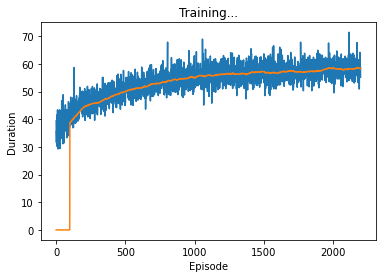

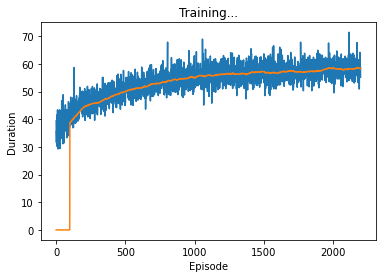

Current_train_num :  6003 Accuracy :  0.7932700316508412
F1 0.5270373191165271
692 654 588
2199
train Current_train_num :  23995 Accuracy :  0.799166493019379
F1 0.49422875131164745
2355 1819 3001
Current_train_num :  2209 LOSS :  -0.22800594568252563
0.015038054436445236
Current_train_num :  2219 LOSS :  -0.3403867185115814
0.014932829886674881
Current_train_num :  2229 LOSS :  -0.17335599660873413
0.01903311163187027
Current_train_num :  2239 LOSS :  -0.19669410586357117
0.021290749311447144
Current_train_num :  2249 LOSS :  -0.238656684756279
0.012541745789349079
Current_train_num :  2259 LOSS :  -0.2082914561033249
0.020521419122815132
Current_train_num :  2269 LOSS :  -0.3160553574562073
0.015439055860042572
Current_train_num :  2279 LOSS :  -0.2247491180896759
0.012302565388381481
Current_train_num :  2289 LOSS :  -0.15923112630844116
0.019775869324803352
Current_train_num :  2299 LOSS :  -0.21974962949752808
0.01379918958991766


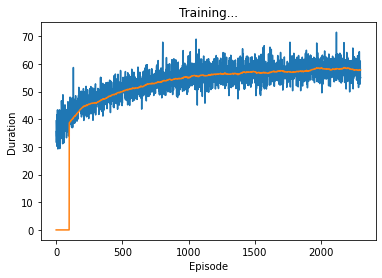

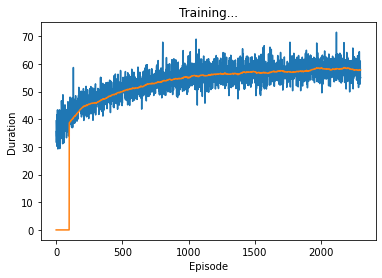

Current_train_num :  6003 Accuracy :  0.7962685324004665
F1 0.5255813953488372
678 622 602
train Current_train_num :  23995 Accuracy :  0.8003750781412794
F1 0.4932839767318879
2332 1767 3024
Current_train_num :  2309 LOSS :  -0.31910383701324463
0.006009452510625124
Current_train_num :  2319 LOSS :  -0.29892563819885254
0.01854364387691021
Current_train_num :  2329 LOSS :  -0.33044198155403137
0.011370775289833546
Current_train_num :  2339 LOSS :  -0.28239622712135315
0.016258761286735535
Current_train_num :  2349 LOSS :  -0.12307151407003403
0.019550947472453117
Current_train_num :  2359 LOSS :  -0.14481744170188904
0.014743483625352383
Current_train_num :  2369 LOSS :  -0.16786552965641022
0.012678811326622963
Current_train_num :  2379 LOSS :  -0.2393103688955307
0.009464588947594166
Current_train_num :  2389 LOSS :  -0.17130593955516815
0.01585671491920948
Current_train_num :  2399 LOSS :  -0.3232831060886383
0.01032729260623455


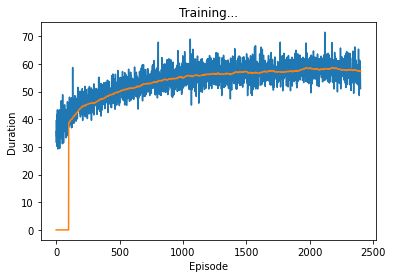

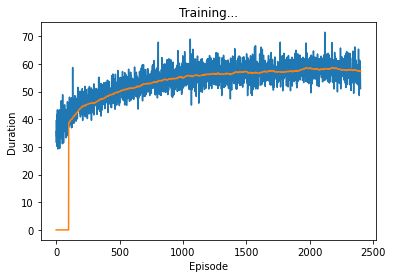

Current_train_num :  6003 Accuracy :  0.8075962018990505
F1 0.5338709677419354
662 538 618
2399
train Current_train_num :  23995 Accuracy :  0.8036257553657011
F1 0.48844024747639203
2250 1607 3106
Current_train_num :  2409 LOSS :  -0.11645131558179855
0.02863634005188942
Current_train_num :  2419 LOSS :  -0.1032598540186882
0.015636606141924858
Current_train_num :  2429 LOSS :  -0.35408684611320496
0.010147374123334885
Current_train_num :  2439 LOSS :  -0.07142604142427444
0.016742242500185966
Current_train_num :  2449 LOSS :  -0.09097035974264145
0.038882918655872345
Current_train_num :  2459 LOSS :  -0.27059173583984375
0.012520347721874714
Current_train_num :  2469 LOSS :  -0.11637921631336212
0.014636934734880924
Current_train_num :  2479 LOSS :  -0.290667861700058
0.010246804915368557
Current_train_num :  2489 LOSS :  -0.1902918666601181
0.017695147544145584
Current_train_num :  2499 LOSS :  -0.1782015860080719
0.029114684090018272


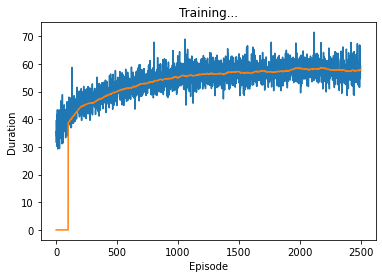

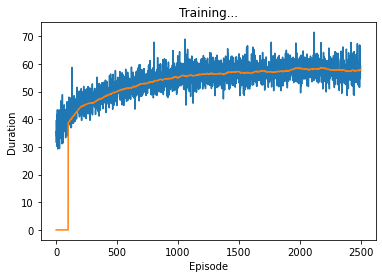

Current_train_num :  6003 Accuracy :  0.8072630351490921
F1 0.5349397590361445
666 544 614
2499
train Current_train_num :  23995 Accuracy :  0.8038758074598875
F1 0.49206863062479766
2280 1631 3076
Current_train_num :  2509 LOSS :  -0.2717110812664032
0.009399357251822948
Current_train_num :  2519 LOSS :  -0.39905107021331787
0.007465223781764507
Current_train_num :  2529 LOSS :  -0.122395358979702
0.018339307978749275
Current_train_num :  2539 LOSS :  -0.08817784488201141
0.02002284862101078
Current_train_num :  2549 LOSS :  -0.27385959029197693
0.03287500515580177
Current_train_num :  2559 LOSS :  -0.1583099216222763
0.020298467949032784
Current_train_num :  2569 LOSS :  -0.3670758903026581
0.019083941355347633
Current_train_num :  2579 LOSS :  -0.4551389515399933
0.009304165840148926
Current_train_num :  2589 LOSS :  -0.3204866349697113
0.008586972020566463
Current_train_num :  2599 LOSS :  -0.12710407376289368
0.009093833155930042


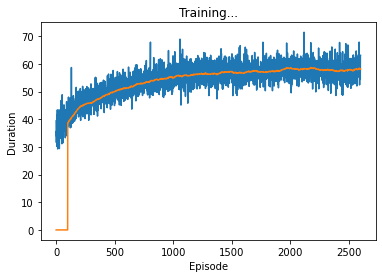

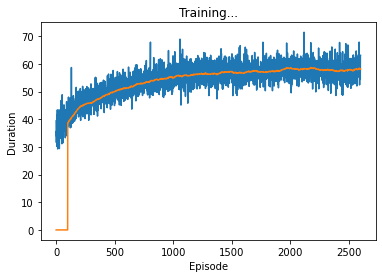

Current_train_num :  6003 Accuracy :  0.8000999500249875
F1 0.5317738791423002
682 603 598
train Current_train_num :  23995 Accuracy :  0.8014169618670557
F1 0.49768128161888703
2361 1771 2995
Current_train_num :  2609 LOSS :  -0.4412057399749756
0.02892290987074375
Current_train_num :  2619 LOSS :  -0.3277547359466553
0.005136418156325817
Current_train_num :  2629 LOSS :  -0.25487202405929565
0.014718600548803806
Current_train_num :  2639 LOSS :  -0.09606034308671951
0.00990133173763752
Current_train_num :  2649 LOSS :  -0.30779603123664856
0.025384042412042618
Current_train_num :  2659 LOSS :  -0.2267584353685379
0.008322027511894703
Current_train_num :  2669 LOSS :  -0.13867712020874023
0.014699737541377544
Current_train_num :  2679 LOSS :  -0.14409732818603516
0.015330675058066845
Current_train_num :  2689 LOSS :  -0.2610227167606354
0.033460307866334915
Current_train_num :  2699 LOSS :  -0.3345053195953369
0.007538246922194958


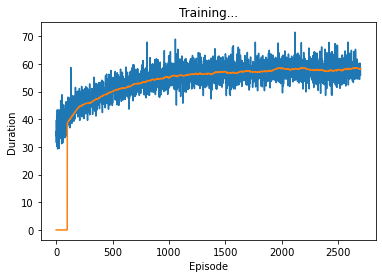

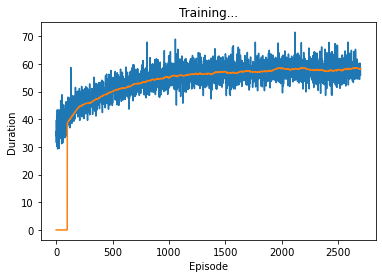

Current_train_num :  6003 Accuracy :  0.8027652840246543
F1 0.531435349940688
672 577 608
train Current_train_num :  23995 Accuracy :  0.8033757032715149
F1 0.4974976040890214
2336 1699 3020
Current_train_num :  2709 LOSS :  -0.34673550724983215
0.00872647762298584
Current_train_num :  2719 LOSS :  -0.23823881149291992
0.01731814071536064
Current_train_num :  2729 LOSS :  -0.07128497213125229
0.022148247808218002
Current_train_num :  2739 LOSS :  -0.13651807606220245
0.01702929474413395
Current_train_num :  2749 LOSS :  -0.026743128895759583
0.009447571821510792
Current_train_num :  2759 LOSS :  -0.22007706761360168
0.013366603292524815
Current_train_num :  2769 LOSS :  -0.30170559883117676
0.016529299318790436
Current_train_num :  2779 LOSS :  -0.22022567689418793
0.0033558672294020653
Current_train_num :  2789 LOSS :  -0.28728801012039185
0.01634242571890354
Current_train_num :  2799 LOSS :  -0.09576987475156784
0.019629115238785744


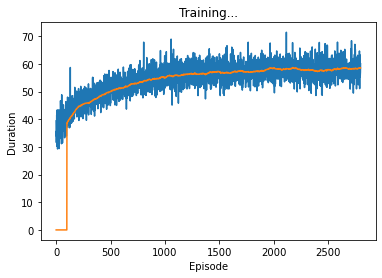

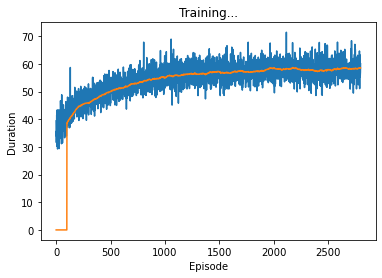

Current_train_num :  6003 Accuracy :  0.8002665333999667
F1 0.5330739299610895
685 605 595
train Current_train_num :  23995 Accuracy :  0.8018753907063971
F1 0.5004727387330602
2382 1781 2974
Current_train_num :  2809 LOSS :  -0.25769105553627014
0.013890986330807209
Current_train_num :  2819 LOSS :  -0.2656289041042328
0.004828228615224361
Current_train_num :  2829 LOSS :  -0.17875221371650696
0.008272876031696796
Current_train_num :  2839 LOSS :  -0.17113517224788666
0.01699358969926834
Current_train_num :  2849 LOSS :  -0.22218307852745056
0.0020758849568665028
Current_train_num :  2859 LOSS :  -0.18458864092826843
0.014056860469281673
Current_train_num :  2869 LOSS :  -0.10586894303560257
0.012068197131156921
Current_train_num :  2879 LOSS :  -0.1837642788887024
0.006500327493995428
Current_train_num :  2889 LOSS :  -0.07951340079307556
0.004521739203482866
Current_train_num :  2899 LOSS :  -0.2289453148841858
0.023379556834697723


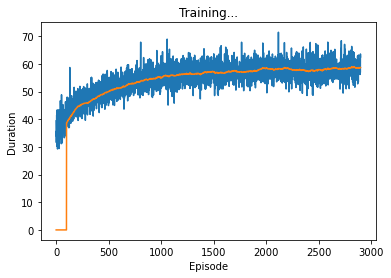

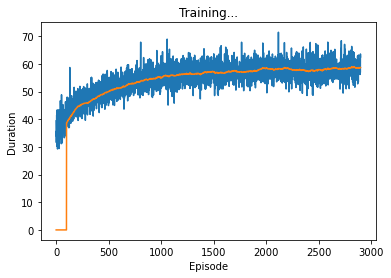

Current_train_num :  6003 Accuracy :  0.8087622855239047
F1 0.5338742393509128
658 527 622
train Current_train_num :  23995 Accuracy :  0.8051260679308189
F1 0.49725894872621734
2313 1634 3043
Current_train_num :  2909 LOSS :  -0.39394521713256836
0.009578468278050423
Current_train_num :  2919 LOSS :  -0.1743423193693161
0.005696242209523916
Current_train_num :  2929 LOSS :  -0.21703548729419708
0.02295178361237049
Current_train_num :  2939 LOSS :  -0.30414319038391113
0.014199605211615562
Current_train_num :  2949 LOSS :  -0.3041602075099945
0.002563810907304287
Current_train_num :  2959 LOSS :  -0.28359663486480713
0.00999296735972166
Current_train_num :  2969 LOSS :  -0.2903203070163727
0.014887964352965355
Current_train_num :  2979 LOSS :  -0.12688978016376495
0.015889838337898254
Current_train_num :  2989 LOSS :  -0.4416901767253876
0.005898372270166874
Current_train_num :  2999 LOSS :  -0.1939874291419983
0.007070185150951147


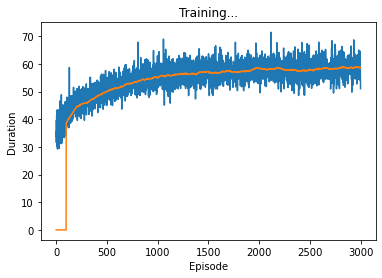

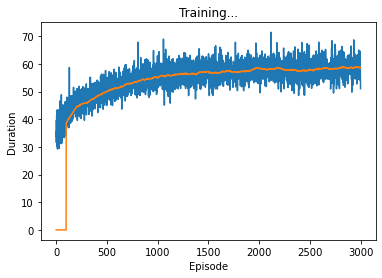

Current_train_num :  6003 Accuracy :  0.8064301182741962
F1 0.5360989230155564
672 555 608
2999
train Current_train_num :  23995 Accuracy :  0.8041258595540738
F1 0.5005842983108467
2356 1701 3000
Current_train_num :  3009 LOSS :  -0.20856024324893951
0.014740866608917713
Current_train_num :  3019 LOSS :  -0.37405601143836975
0.015129069797694683
Current_train_num :  3029 LOSS :  -0.09661411494016647
0.026915984228253365
Current_train_num :  3039 LOSS :  -0.2627636194229126
0.01013406552374363
Current_train_num :  3049 LOSS :  -0.10208562016487122
0.01947176456451416
Current_train_num :  3059 LOSS :  -0.09276562929153442
0.01840251125395298
Current_train_num :  3069 LOSS :  -0.1488136351108551
0.009234173223376274
Current_train_num :  3079 LOSS :  -0.41668501496315
0.015175062231719494
Current_train_num :  3089 LOSS :  -0.315849632024765
0.011944977566599846
Current_train_num :  3099 LOSS :  -0.2781558930873871
0.007767059374600649


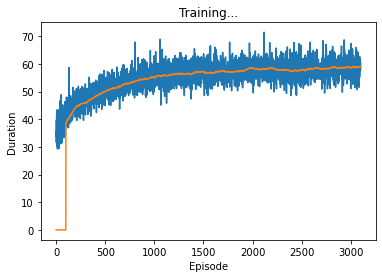

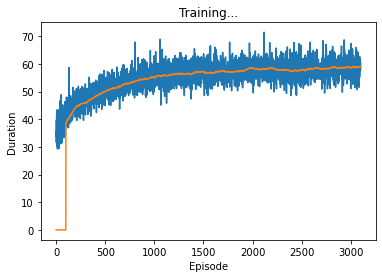

Current_train_num :  6003 Accuracy :  0.8074296185240712
F1 0.53812375249501
674 551 606
3099
train Current_train_num :  23995 Accuracy :  0.804334236299229
F1 0.5020148462354189
2367 1707 2989
Current_train_num :  3109 LOSS :  -0.3707077205181122
-0.002219129353761673
Current_train_num :  3119 LOSS :  -0.06645374745130539
0.010033049620687962
Current_train_num :  3129 LOSS :  -0.10811568051576614
0.020417237654328346
Current_train_num :  3139 LOSS :  -0.022999469190835953
0.018562588840723038
Current_train_num :  3149 LOSS :  -0.15502409636974335
0.01890752837061882
Current_train_num :  3159 LOSS :  -0.15658867359161377
0.008186224848031998
Current_train_num :  3169 LOSS :  -0.280529648065567
0.016188297420740128
Current_train_num :  3179 LOSS :  -0.33785200119018555
0.010332852602005005
Current_train_num :  3189 LOSS :  -0.31597021222114563
0.0047388155944645405
Current_train_num :  3199 LOSS :  -0.11201807111501694
0.023360127583146095


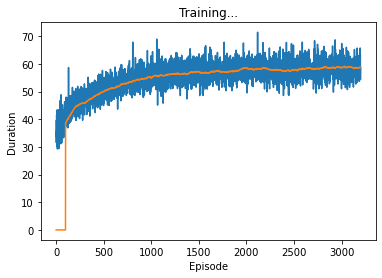

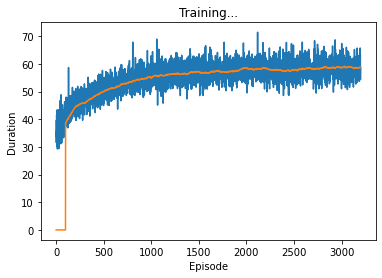

Current_train_num :  6003 Accuracy :  0.8050974512743628
F1 0.5373370209403397
680 571 600
train Current_train_num :  23995 Accuracy :  0.803542404667639
F1 0.5036319612590799
2392 1751 2964
Current_train_num :  3209 LOSS :  -0.19443348050117493
0.01145416684448719
Current_train_num :  3219 LOSS :  -0.16047941148281097
0.01442557293921709
Current_train_num :  3229 LOSS :  -0.2092745304107666
0.00976162776350975
Current_train_num :  3239 LOSS :  -0.2972549498081207
0.014604308642446995
Current_train_num :  3249 LOSS :  -0.055214837193489075
0.0136551009491086
Current_train_num :  3259 LOSS :  -0.16833198070526123
0.0030964526813477278
Current_train_num :  3269 LOSS :  -0.18462546169757843
0.02463279664516449
Current_train_num :  3279 LOSS :  -0.06929444521665573
0.010109232738614082
Current_train_num :  3289 LOSS :  -0.3680717945098877
0.009239256381988525
Current_train_num :  3299 LOSS :  -0.15812119841575623
0.005034747999161482


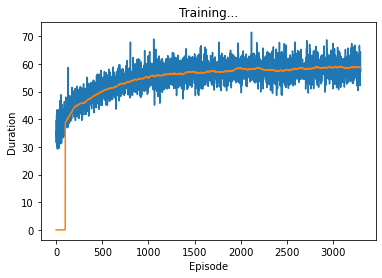

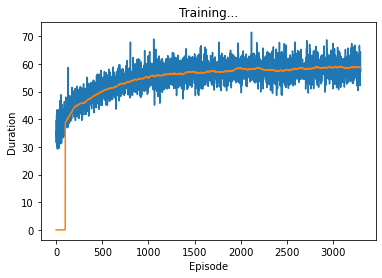

Current_train_num :  6003 Accuracy :  0.8089288688988839
F1 0.5396952686447474
673 541 607
3299
train Current_train_num :  23995 Accuracy :  0.8050010418837258
F1 0.5029736618521665
2368 1692 2988
Current_train_num :  3309 LOSS :  -0.10107430815696716
0.009478846564888954
Current_train_num :  3319 LOSS :  -0.1257137656211853
0.0047060297802090645
Current_train_num :  3329 LOSS :  -0.07410011440515518
0.007539467420428991
Current_train_num :  3339 LOSS :  -0.18456806242465973
0.00831463560461998
Current_train_num :  3349 LOSS :  -0.07625981420278549
0.010051467455923557
Current_train_num :  3359 LOSS :  -0.21860671043395996
0.009421844966709614
Current_train_num :  3369 LOSS :  -0.08238127082586288
0.02635461837053299
Current_train_num :  3379 LOSS :  -0.10020773112773895
0.012662901543080807
Current_train_num :  3389 LOSS :  -0.33197322487831116
0.003535473719239235
Current_train_num :  3399 LOSS :  -0.1613364815711975
0.01723008044064045


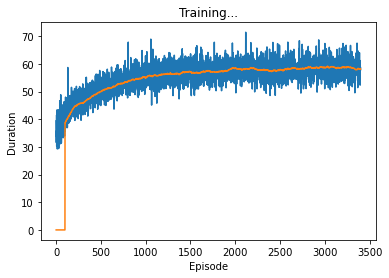

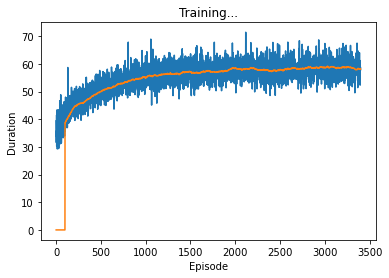

Current_train_num :  6003 Accuracy :  0.8082625353989672
F1 0.5403032721468476
677 549 603
3399
train Current_train_num :  23995 Accuracy :  0.8045426130443842
F1 0.5043845747490755
2387 1722 2969
Current_train_num :  3409 LOSS :  -0.18255850672721863
0.009493310004472733
Current_train_num :  3419 LOSS :  -0.22875861823558807
0.012944499030709267
Current_train_num :  3429 LOSS :  -0.0186900794506073
0.018837815150618553
Current_train_num :  3439 LOSS :  -0.04079759120941162
0.01144177746027708
Current_train_num :  3449 LOSS :  -0.27076059579849243
0.013219837099313736
Current_train_num :  3459 LOSS :  -0.09913786500692368
0.011286843568086624
Current_train_num :  3469 LOSS :  -0.08516095578670502
0.016397830098867416
Current_train_num :  3479 LOSS :  -0.1192500963807106
0.01180214062333107
Current_train_num :  3489 LOSS :  -0.18952567875385284
0.008574448525905609
Current_train_num :  3499 LOSS :  -0.14531546831130981
0.014721178449690342


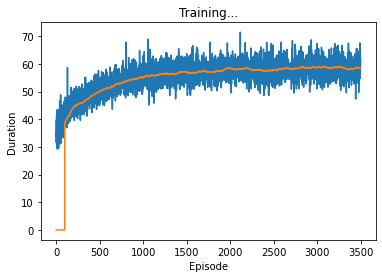

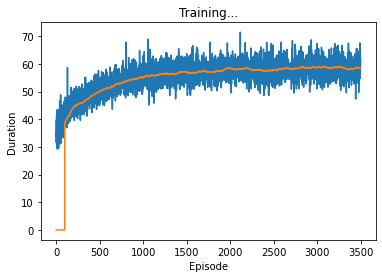

Current_train_num :  6003 Accuracy :  0.808095952023988
F1 0.5400877542879936
677 550 603
train Current_train_num :  23995 Accuracy :  0.8047093144405084
F1 0.5063717746182201
2404 1735 2952
Current_train_num :  3509 LOSS :  -0.10504703968763351
0.03602263703942299
Current_train_num :  3519 LOSS :  -0.21041332185268402
0.008435769937932491
Current_train_num :  3529 LOSS :  -0.06362447887659073
0.005275402683764696
Current_train_num :  3539 LOSS :  -0.10852033644914627
0.010500742122530937
Current_train_num :  3549 LOSS :  -0.16530346870422363
0.01873321458697319
Current_train_num :  3559 LOSS :  -0.04900728911161423
0.026264498010277748
Current_train_num :  3569 LOSS :  -0.134897843003273
0.018259495496749878
Current_train_num :  3579 LOSS :  -0.14409588277339935
0.01711658015847206
Current_train_num :  3589 LOSS :  -0.4317387640476227
0.005878761876374483
Current_train_num :  3599 LOSS :  -0.20875880122184753
0.021574726328253746


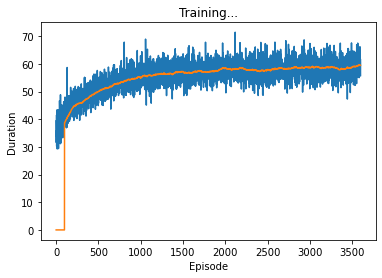

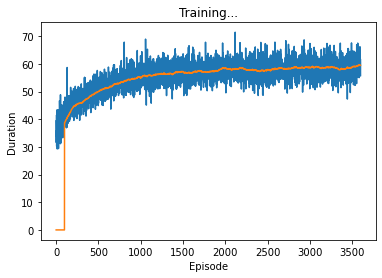

Current_train_num :  6003 Accuracy :  0.8047642845244045
F1 0.5380070894052776
683 576 597
train Current_train_num :  23995 Accuracy :  0.8035840800166701
F1 0.5084462982273201
2438 1796 2918
Current_train_num :  3609 LOSS :  -0.20178507268428802
0.019265664741396904
Current_train_num :  3619 LOSS :  -0.18868456780910492
0.01699824444949627
Current_train_num :  3629 LOSS :  -0.25226131081581116
0.012017713859677315
Current_train_num :  3639 LOSS :  -0.10497462004423141
0.011960405856370926
Current_train_num :  3649 LOSS :  -0.17890523374080658
0.008539943024516106
Current_train_num :  3659 LOSS :  -0.42517995834350586
0.011053085327148438
Current_train_num :  3669 LOSS :  -0.23417551815509796
0.008765843696892262
Current_train_num :  3679 LOSS :  -0.34927818179130554
0.004840372130274773
Current_train_num :  3689 LOSS :  -0.2526051104068756
0.013973192311823368
Current_train_num :  3699 LOSS :  -0.11835426092147827
0.015134437009692192


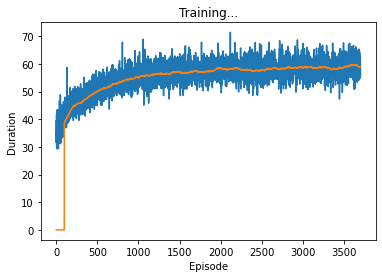

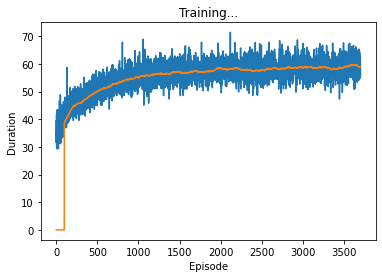

Current_train_num :  6003 Accuracy :  0.8015992003998001
F1 0.5401234567901234
700 612 580
train Current_train_num :  23995 Accuracy :  0.8018337153573661
F1 0.5093872498452651
2469 1869 2887
Current_train_num :  3709 LOSS :  -0.252274751663208
0.029307451099157333
Current_train_num :  3719 LOSS :  -0.1466672718524933
0.006648276932537556
Current_train_num :  3729 LOSS :  -0.11391501873731613
0.012934310361742973
Current_train_num :  3739 LOSS :  -0.18968138098716736
0.009297994896769524
Current_train_num :  3749 LOSS :  -0.3028523623943329
0.014683443121612072
Current_train_num :  3759 LOSS :  -0.11571728438138962
0.004832383710891008
Current_train_num :  3769 LOSS :  -0.3239087760448456
0.014211390167474747
Current_train_num :  3779 LOSS :  -0.09459751844406128
0.015223237685859203
Current_train_num :  3789 LOSS :  -0.22218987345695496
0.011125806719064713
Current_train_num :  3799 LOSS :  -0.1933136135339737
0.01092893909662962


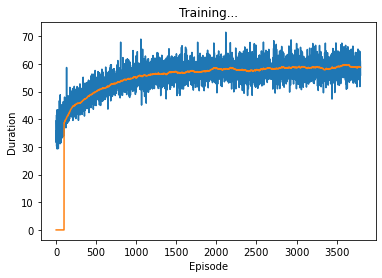

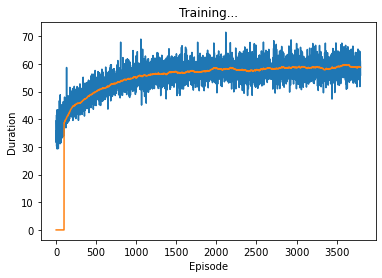

Current_train_num :  6003 Accuracy :  0.8074296185240712
F1 0.5414189456995641
683 560 597
3799
train Current_train_num :  23995 Accuracy :  0.8038341321108564
F1 0.5090719499478623
2441 1793 2915
Current_train_num :  3809 LOSS :  -0.05739196017384529
0.011521890759468079
Current_train_num :  3819 LOSS :  -0.1489582359790802
0.008204415440559387
Current_train_num :  3829 LOSS :  -0.16189457476139069
0.028841884806752205
Current_train_num :  3839 LOSS :  -0.31159138679504395
0.02401641197502613
Current_train_num :  3849 LOSS :  -0.20304588973522186
0.003361780196428299
Current_train_num :  3859 LOSS :  -0.21471957862377167
0.0072109755128622055
Current_train_num :  3869 LOSS :  -0.18602710962295532
0.00658459821715951
Current_train_num :  3879 LOSS :  -0.015547028742730618
0.011479494161903858
Current_train_num :  3889 LOSS :  -0.29574474692344666
0.022340470924973488
Current_train_num :  3899 LOSS :  -0.06117691844701767
0.017750214785337448


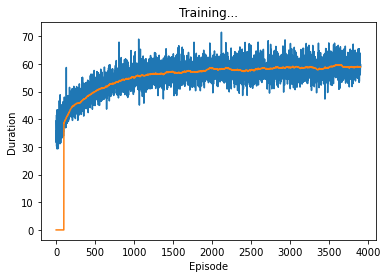

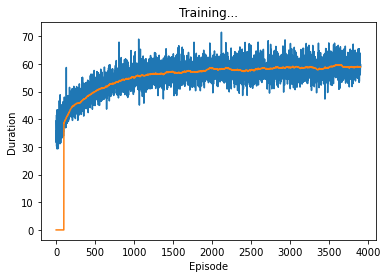

Current_train_num :  6003 Accuracy :  0.8067632850241546
F1 0.5423728813559322
688 569 592
3899
train Current_train_num :  23995 Accuracy :  0.8038758074598875
F1 0.5101467374336559
2451 1802 2905
Current_train_num :  3909 LOSS :  -0.30556923151016235
0.007135218475013971
Current_train_num :  3919 LOSS :  -0.28821367025375366
0.002868743147701025
Current_train_num :  3929 LOSS :  -0.09039844572544098
0.006278743967413902
Current_train_num :  3939 LOSS :  -0.1382269710302353
0.01432353351265192
Current_train_num :  3949 LOSS :  -0.052330873906612396
0.007404801435768604
Current_train_num :  3959 LOSS :  -0.1561647355556488
0.005700424313545227
Current_train_num :  3969 LOSS :  -0.1155775785446167
0.003577144118025899
Current_train_num :  3979 LOSS :  -0.3163658678531647
0.00487667229026556
Current_train_num :  3989 LOSS :  -0.1319878101348877
0.018020834773778915
Current_train_num :  3999 LOSS :  -0.07773973047733307
0.006606492679566145


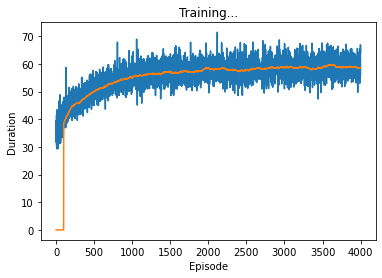

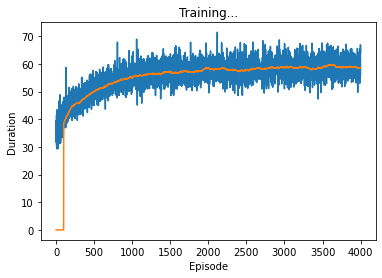

Current_train_num :  6003 Accuracy :  0.81375978677328
F1 0.5427053534940743
664 503 616
3999
train Current_train_num :  23995 Accuracy :  0.8052094186288811
F1 0.5025007981270618
2361 1680 2995
Current_train_num :  4009 LOSS :  -0.052359677851200104
0.010493570938706398
Current_train_num :  4019 LOSS :  -0.15297187864780426
0.008263557218015194
Current_train_num :  4029 LOSS :  0.0012764367274940014
0.026522303000092506
Current_train_num :  4039 LOSS :  -0.2085091769695282
0.006967305205762386
Current_train_num :  4049 LOSS :  -0.24503794312477112
0.0160235445946455
Current_train_num :  4059 LOSS :  -0.1910504251718521
0.02307794615626335
Current_train_num :  4069 LOSS :  -0.07186537981033325
0.004639863967895508
Current_train_num :  4079 LOSS :  -0.09104842692613602
0.003110448596999049
Current_train_num :  4089 LOSS :  -0.04616739600896835
0.025014884769916534
Current_train_num :  4099 LOSS :  -0.2409900426864624
0.01747663877904415


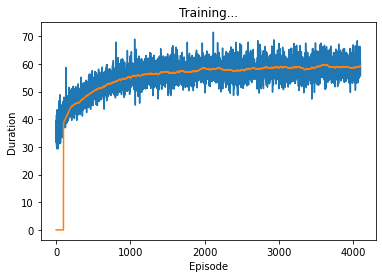

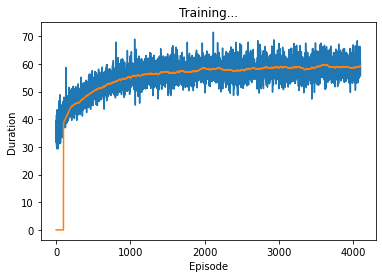

Current_train_num :  6003 Accuracy :  0.8087622855239047
F1 0.5427775567051333
682 551 598
4099
train Current_train_num :  23995 Accuracy :  0.8042092102521359
F1 0.508729743857815
2433 1776 2923
Current_train_num :  4109 LOSS :  -0.06713548302650452
0.0075672697275877
Current_train_num :  4119 LOSS :  -0.10626083612442017
0.009740578010678291
Current_train_num :  4129 LOSS :  -0.24985110759735107
0.007225376553833485
Current_train_num :  4139 LOSS :  -0.16502200067043304
0.024592289701104164
Current_train_num :  4149 LOSS :  -0.16683992743492126
0.0016503281658515334
Current_train_num :  4159 LOSS :  -0.08563896268606186
0.014144071377813816
Current_train_num :  4169 LOSS :  -0.2813546359539032
0.009356926195323467
Current_train_num :  4179 LOSS :  -0.0499410443007946
0.011576293036341667
Current_train_num :  4189 LOSS :  -0.2458508163690567
0.0053499736823141575
Current_train_num :  4199 LOSS :  -0.1376413106918335
0.015185676515102386


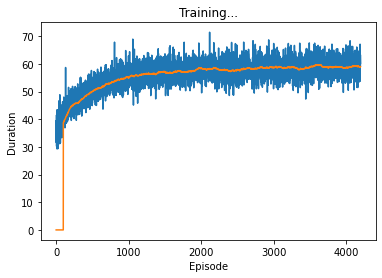

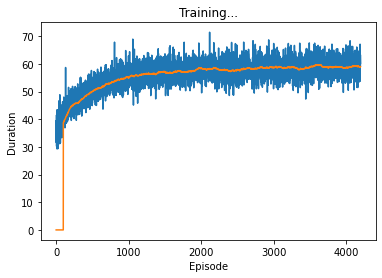

Current_train_num :  6003 Accuracy :  0.8097617857737798
F1 0.5426170468187275
678 541 602
train Current_train_num :  23995 Accuracy :  0.8045426130443842
F1 0.509668652660186
2438 1773 2918
Current_train_num :  4209 LOSS :  -0.0021937848068773746
0.017162632197141647
Current_train_num :  4219 LOSS :  -0.08868091553449631
0.018479712307453156
Current_train_num :  4229 LOSS :  -0.19091796875
0.0014644316397607327
Current_train_num :  4239 LOSS :  -0.21436795592308044
0.0050535849295556545
Current_train_num :  4249 LOSS :  -0.2743814289569855
0.00950569286942482
Current_train_num :  4259 LOSS :  -0.1730922907590866
0.03751269355416298
Current_train_num :  4269 LOSS :  -0.15373143553733826
0.005013591144233942
Current_train_num :  4279 LOSS :  -0.042049940675497055
0.017666170373558998
Current_train_num :  4289 LOSS :  -0.10539959371089935
0.018628010526299477
Current_train_num :  4299 LOSS :  -0.10589618235826492
0.009444599971175194


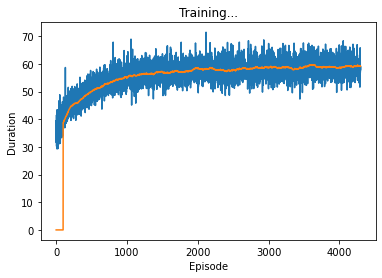

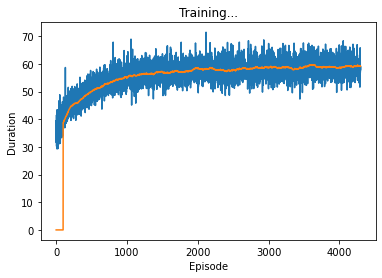

Current_train_num :  6003 Accuracy :  0.8084291187739464
F1 0.5423459244532803
682 553 598
train Current_train_num :  23995 Accuracy :  0.8041258595540738
F1 0.511685883452789
2463 1808 2893
Current_train_num :  4309 LOSS :  -0.09664700925350189
0.005368346348404884
Current_train_num :  4319 LOSS :  -0.13845334947109222
0.010061195120215416
Current_train_num :  4329 LOSS :  -0.11879730224609375
0.021354176104068756
Current_train_num :  4339 LOSS :  -0.042537666857242584
0.012562082149088383
Current_train_num :  4349 LOSS :  -0.09625217318534851
0.007453843019902706
Current_train_num :  4359 LOSS :  -0.19462336599826813
0.004201821982860565
Current_train_num :  4369 LOSS :  -0.23522064089775085
0.009345106780529022
Current_train_num :  4379 LOSS :  -0.08955074101686478
0.00910158921033144
Current_train_num :  4389 LOSS :  -0.09493544697761536
0.011877085082232952
Current_train_num :  4399 LOSS :  -0.13634847104549408
0.012563777156174183


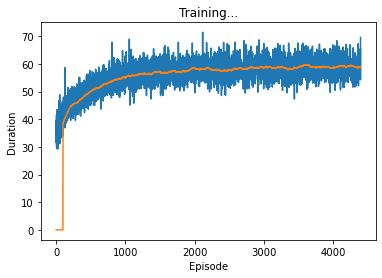

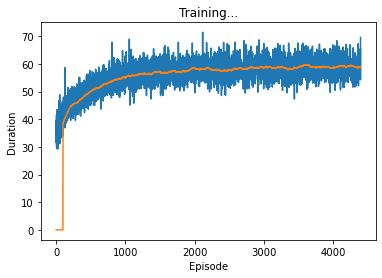

Current_train_num :  6003 Accuracy :  0.8102615358987173
F1 0.5436349079263411
679 539 601
4399
train Current_train_num :  23995 Accuracy :  0.8044592623463221
F1 0.5102786183867265
2445 1782 2911
Current_train_num :  4409 LOSS :  -0.1188265010714531
0.004272840917110443
Current_train_num :  4419 LOSS :  -0.21519488096237183
0.008484769612550735
Current_train_num :  4429 LOSS :  -0.1531243771314621
0.01701505482196808
Current_train_num :  4439 LOSS :  -0.23918917775154114
0.002836936619132757
Current_train_num :  4449 LOSS :  -0.2731055021286011
0.019613055512309074
Current_train_num :  4459 LOSS :  -0.24591217935085297
0.005790594033896923
Current_train_num :  4469 LOSS :  -0.18406154215335846
0.015255732461810112
Current_train_num :  4479 LOSS :  -0.23821817338466644
0.013704178854823112
Current_train_num :  4489 LOSS :  -0.2522272765636444
0.0013476349413394928
Current_train_num :  4499 LOSS :  -0.26587000489234924
0.0018111023819074035


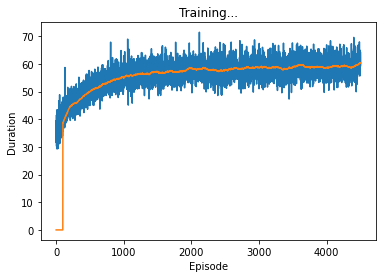

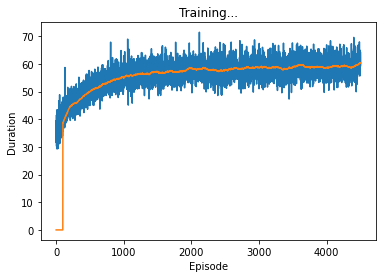

Current_train_num :  6003 Accuracy :  0.8069298683991337
F1 0.5407759303246239
683 563 597
train Current_train_num :  23995 Accuracy :  0.8040841842050427
F1 0.512341837792989
2470 1816 2886
Current_train_num :  4509 LOSS :  -0.11107664555311203
0.0062347655184566975
Current_train_num :  4519 LOSS :  -0.13063375651836395
0.008448862470686436
Current_train_num :  4529 LOSS :  -0.09343640506267548
0.008698268793523312
Current_train_num :  4539 LOSS :  -0.0019778457935899496
0.010409969836473465
Current_train_num :  4549 LOSS :  -0.030563263222575188
0.006766044534742832
Current_train_num :  4559 LOSS :  -0.10863927751779556
0.006975794211030006
Current_train_num :  4569 LOSS :  -0.15058444440364838
0.0018597034504637122
Current_train_num :  4579 LOSS :  -0.11346534639596939
0.004692152142524719
Current_train_num :  4589 LOSS :  -0.03690045326948166
0.022399190813302994
Current_train_num :  4599 LOSS :  -0.07242479175329208
0.010805029422044754


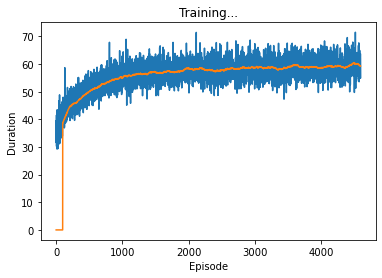

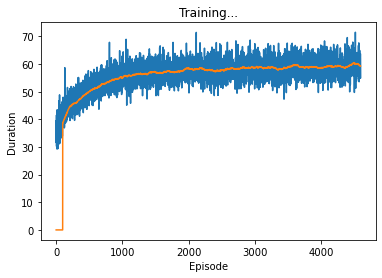

Current_train_num :  6003 Accuracy :  0.8139263701482592
F1 0.5440456769983687
667 505 613
4599
train Current_train_num :  23995 Accuracy :  0.8052094186288811
F1 0.507635597682991
2410 1729 2946
Current_train_num :  4609 LOSS :  -0.06973966956138611
0.01680714823305607
Current_train_num :  4619 LOSS :  -0.11292530596256256
0.0034185322001576424
Current_train_num :  4629 LOSS :  -0.035800982266664505
0.010229526087641716
Current_train_num :  4639 LOSS :  -0.2670077383518219
0.0007300241850316525
Current_train_num :  4649 LOSS :  -0.035769712179899216
0.02250337041914463
Current_train_num :  4659 LOSS :  -0.16246795654296875
0.014905121177434921
Current_train_num :  4669 LOSS :  -0.09148172289133072
0.028615346178412437
Current_train_num :  4679 LOSS :  -0.24177834391593933
0.0018222780199721456
Current_train_num :  4689 LOSS :  -0.2929689586162567
0.010382873937487602
Current_train_num :  4699 LOSS :  -0.06999610364437103
0.004385190550237894


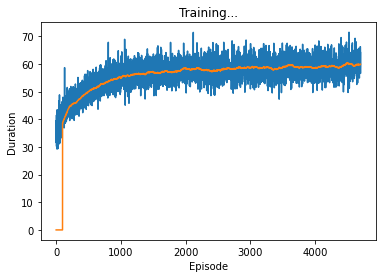

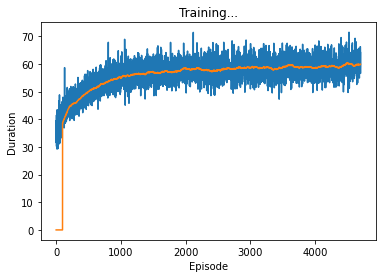

Current_train_num :  6003 Accuracy :  0.8107612860236548
F1 0.5428226779252111
675 532 605
train Current_train_num :  23995 Accuracy :  0.8046676390914774
F1 0.5103405055358262
2443 1775 2913
Current_train_num :  4709 LOSS :  -0.1502319574356079
0.011670387350022793
Current_train_num :  4719 LOSS :  -0.06508517265319824
0.014814804308116436
Current_train_num :  4729 LOSS :  -0.1568560004234314
0.0053549958392977715
Current_train_num :  4739 LOSS :  -0.09647621959447861
0.009119546972215176
Current_train_num :  4749 LOSS :  -0.1159902960062027
0.007341248914599419
Current_train_num :  4759 LOSS :  -0.12685714662075043
0.0070092687383294106
Current_train_num :  4769 LOSS :  -0.20323869585990906
0.031186997890472412
Current_train_num :  4779 LOSS :  -0.15726116299629211
0.0052795386873185635
Current_train_num :  4789 LOSS :  -0.18027867376804352
0.014542789198458195
Current_train_num :  4799 LOSS :  -0.0925123542547226
0.00808598194271326


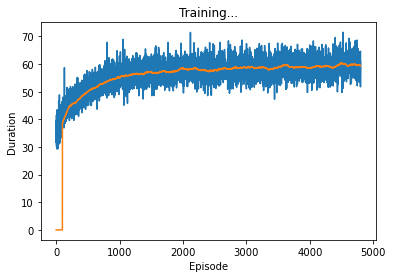

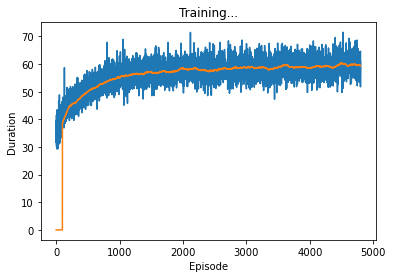

Current_train_num :  6003 Accuracy :  0.8107612860236548
F1 0.5420861860652436
673 530 607
train Current_train_num :  23995 Accuracy :  0.80516774327985
F1 0.5109809663250366
2443 1763 2913
Current_train_num :  4809 LOSS :  -0.1876162886619568
-0.000733376364223659
Current_train_num :  4819 LOSS :  -0.03513109311461449
0.006950872950255871
Current_train_num :  4829 LOSS :  -0.074835404753685
0.012191862799227238
Current_train_num :  4839 LOSS :  -0.11125759780406952
0.007310688029974699
Current_train_num :  4849 LOSS :  -0.20049864053726196
0.005220683757215738
Current_train_num :  4859 LOSS :  -0.20308957993984222
0.011913705617189407
Current_train_num :  4869 LOSS :  -0.09090445935726166
0.011646531522274017
Current_train_num :  4879 LOSS :  -0.27937036752700806
0.004369407892227173
Current_train_num :  4889 LOSS :  -0.16993412375450134
0.005656592082232237
Current_train_num :  4899 LOSS :  -0.11769405007362366
0.010523277334868908


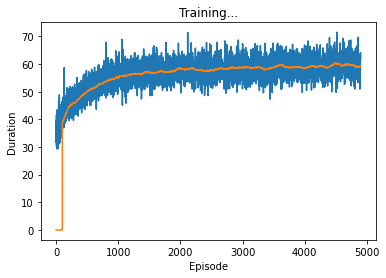

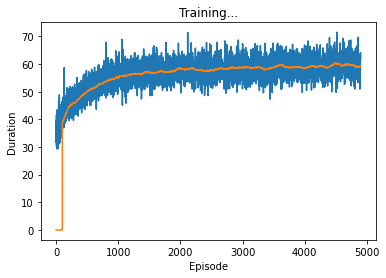

Current_train_num :  6003 Accuracy :  0.8094286190238215
F1 0.5436428856117975
682 547 598
train Current_train_num :  23995 Accuracy :  0.8047926651385705
F1 0.5128418425704482
2466 1795 2890
Current_train_num :  4909 LOSS :  -0.23294880986213684
0.008415045216679573
Current_train_num :  4919 LOSS :  -0.10758504271507263
0.003298955038189888
Current_train_num :  4929 LOSS :  -0.17524585127830505
0.0320746935904026
Current_train_num :  4939 LOSS :  -0.11772145330905914
0.012118717655539513
Current_train_num :  4949 LOSS :  -0.10049748420715332
0.033763956278562546
Current_train_num :  4959 LOSS :  -0.07158655673265457
0.025303876027464867
Current_train_num :  4969 LOSS :  -0.12733881175518036
0.003703722031787038
Current_train_num :  4979 LOSS :  -0.11710235476493835
0.0013887084787711501
Current_train_num :  4989 LOSS :  -0.1391836702823639
0.00812935084104538
Current_train_num :  4999 LOSS :  -0.08459493517875671
0.027217524126172066


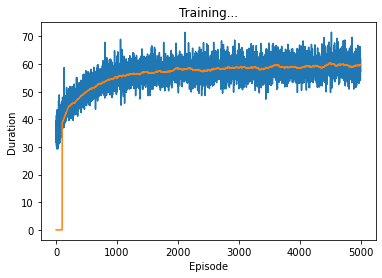

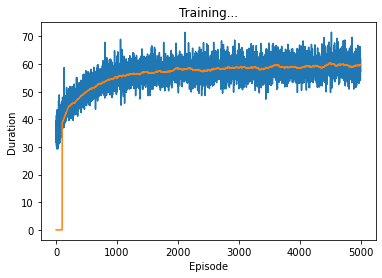

Current_train_num :  6003 Accuracy :  0.8054306180243211
F1 0.5410286611700039
689 578 591
train Current_train_num :  23995 Accuracy :  0.8041675349031048
F1 0.5162618361465624
2508 1852 2848
Current_train_num :  5009 LOSS :  -0.20160402357578278
0.0001600423565832898
Current_train_num :  5019 LOSS :  -0.18245689570903778
0.0028695568908005953
Current_train_num :  5029 LOSS :  -0.028264237567782402
0.03068917989730835
Current_train_num :  5039 LOSS :  -0.22645840048789978
0.011590860784053802
Current_train_num :  5049 LOSS :  -0.16940532624721527
0.01926271989941597
Current_train_num :  5059 LOSS :  -0.07429808378219604
0.007101200986653566
Current_train_num :  5069 LOSS :  -0.11439507454633713
0.020856333896517754
Current_train_num :  5079 LOSS :  -0.1716468632221222
0.008969160728156567
Current_train_num :  5089 LOSS :  -0.27918845415115356
0.009454663842916489
Current_train_num :  5099 LOSS :  -0.13036252558231354
0.0013966276310384274


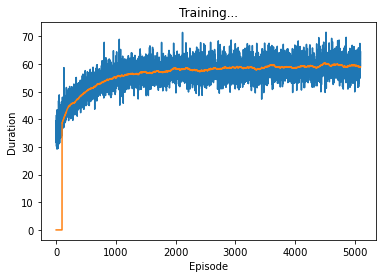

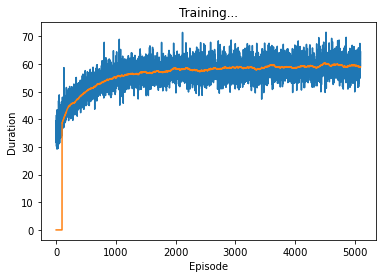

Current_train_num :  6003 Accuracy :  0.8097617857737798
F1 0.5448028673835126
684 547 596
5099
train Current_train_num :  23995 Accuracy :  0.8048760158366326
F1 0.5135556248052353
2472 1799 2884
Current_train_num :  5109 LOSS :  -0.1632792353630066
0.01294129341840744
Current_train_num :  5119 LOSS :  -0.06907087564468384
0.011014310643076897
Current_train_num :  5129 LOSS :  -0.1435694694519043
0.015710731968283653
Current_train_num :  5139 LOSS :  -0.18067777156829834
1.466347930545453e-05
Current_train_num :  5149 LOSS :  -0.15736186504364014
0.001604760531336069
Current_train_num :  5159 LOSS :  -0.1704389601945877
0.0003061794559471309
Current_train_num :  5169 LOSS :  -0.15223081409931183
0.0004142470716033131
Current_train_num :  5179 LOSS :  -0.03322537615895271
0.0036981652956455946
Current_train_num :  5189 LOSS :  -0.05374439060688019
0.0033158983569592237
Current_train_num :  5199 LOSS :  -0.22864599525928497
-0.0025017005391418934


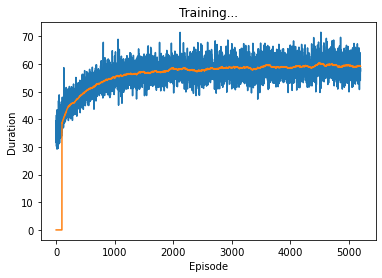

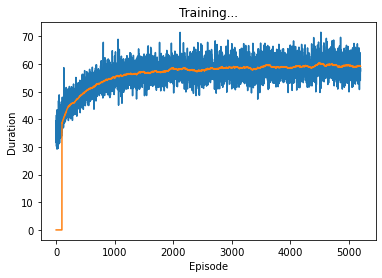

Current_train_num :  6003 Accuracy :  0.8104281192736965
F1 0.5449460647223332
682 541 598
5199
train Current_train_num :  23995 Accuracy :  0.8049593665346947
F1 0.5129539069815836
2465 1790 2891
Current_train_num :  5209 LOSS :  -0.1139606237411499
0.00763959065079689
Current_train_num :  5219 LOSS :  -0.30337706208229065
0.00729896267876029
Current_train_num :  5229 LOSS :  -0.16296249628067017
0.011415274813771248
Current_train_num :  5239 LOSS :  -0.055086128413677216
0.007567380554974079
Current_train_num :  5249 LOSS :  -0.02377932146191597
0.0048265643417835236
Current_train_num :  5259 LOSS :  -0.30496490001678467
0.011132913641631603
Current_train_num :  5269 LOSS :  -0.08337972313165665
0.00486259488388896
Current_train_num :  5279 LOSS :  -0.2975655794143677
-6.161480268929154e-05
Current_train_num :  5289 LOSS :  -0.055309973657131195
0.01634010672569275
Current_train_num :  5299 LOSS :  -0.050101809203624725
0.0032555300276726484


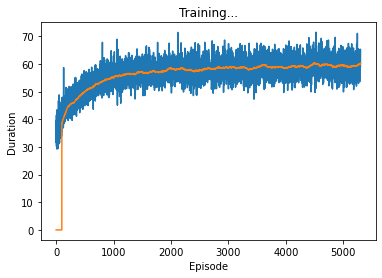

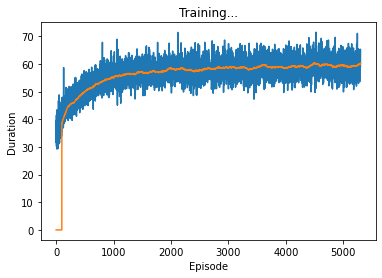

Current_train_num :  6003 Accuracy :  0.8077627852740297
F1 0.5422116527942925
684 559 596
train Current_train_num :  23995 Accuracy :  0.8047926651385705
F1 0.5148596872734804
2486 1815 2870
Current_train_num :  5309 LOSS :  -0.05142226070165634
0.023153668269515038
Current_train_num :  5319 LOSS :  -0.1692008376121521
0.005542948842048645
Current_train_num :  5329 LOSS :  -0.10372945666313171
0.02012777142226696
Current_train_num :  5339 LOSS :  -0.196491077542305
0.0015055957483127713
Current_train_num :  5349 LOSS :  -0.03296355530619621
0.0031913579441607
Current_train_num :  5359 LOSS :  -0.15742714703083038
0.008920704014599323
Current_train_num :  5369 LOSS :  -0.12733782827854156
0.019233087077736855
Current_train_num :  5379 LOSS :  -0.1797688752412796
0.003951568156480789
Current_train_num :  5389 LOSS :  -0.22329631447792053
0.010195160284638405
Current_train_num :  5399 LOSS :  -0.18237252533435822
0.002782447263598442


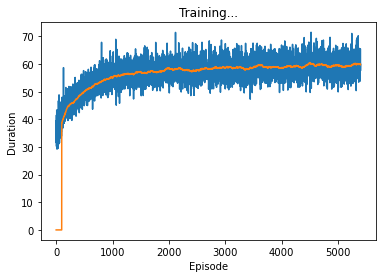

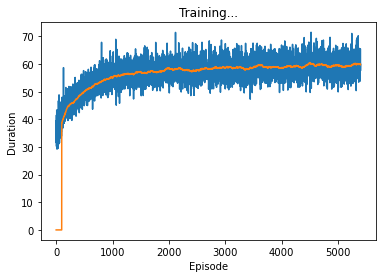

Current_train_num :  6003 Accuracy :  0.809095452273863
F1 0.5435734182252288
683 550 597
train Current_train_num :  23995 Accuracy :  0.8048343404876016
F1 0.5142086704003319
2479 1807 2877
Current_train_num :  5409 LOSS :  -0.02400386519730091
0.005943844094872475
Current_train_num :  5419 LOSS :  -0.04029810428619385
0.003839620156213641
Current_train_num :  5429 LOSS :  -0.09683899581432343
0.012630600482225418
Current_train_num :  5439 LOSS :  -0.1550590842962265
0.005310398060828447
Current_train_num :  5449 LOSS :  -0.1910281926393509
0.0012166148517280817
Current_train_num :  5459 LOSS :  -0.08130816370248795
0.029480552300810814
Current_train_num :  5469 LOSS :  -0.27549803256988525
-0.0005825735279358923
Current_train_num :  5479 LOSS :  0.013628572225570679
0.016729723662137985
Current_train_num :  5489 LOSS :  -0.16396808624267578
0.013564595021307468
Current_train_num :  5499 LOSS :  -0.03553130105137825
0.008114395663142204


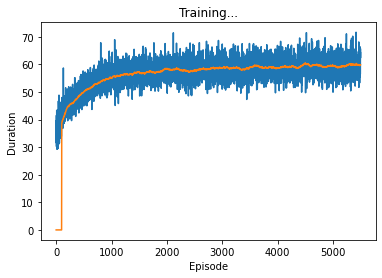

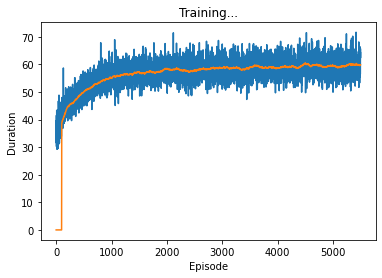

Current_train_num :  6003 Accuracy :  0.8075962018990505
F1 0.5427215189873418
686 562 594
train Current_train_num :  23995 Accuracy :  0.8045426130443842
F1 0.5149415779133492
2490 1825 2866
Current_train_num :  5509 LOSS :  -0.11919861286878586
0.002953428076580167
Current_train_num :  5519 LOSS :  -0.1904124617576599
0.004986374638974667
Current_train_num :  5529 LOSS :  -0.1550862044095993
0.00694504426792264
Current_train_num :  5539 LOSS :  -0.21835018694400787
0.015338736586272717
Current_train_num :  5549 LOSS :  -0.25907835364341736
0.013098387978971004
Current_train_num :  5559 LOSS :  -0.2856485843658447
0.022639254108071327
Current_train_num :  5569 LOSS :  -0.2906762957572937
0.004655138123780489
Current_train_num :  5579 LOSS :  -0.04958711564540863
0.002907542744651437
Current_train_num :  5589 LOSS :  -0.15036283433437347
0.0018570896936580539
Current_train_num :  5599 LOSS :  -0.2867368161678314
0.0049308715388178825


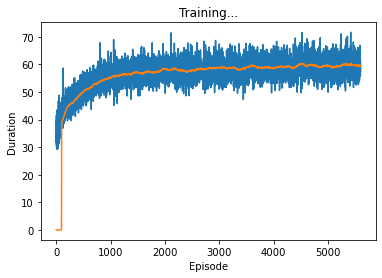

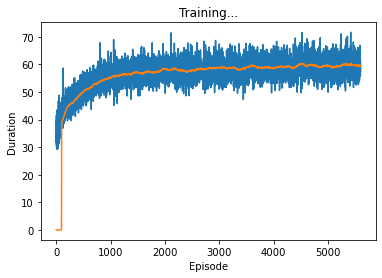

Current_train_num :  6003 Accuracy :  0.809928369148759
F1 0.5446570972886763
683 545 597
train Current_train_num :  23995 Accuracy :  0.8048760158366326
F1 0.514161220043573
2478 1805 2878
Current_train_num :  5609 LOSS :  -0.16079287230968475
0.002467404818162322
Current_train_num :  5619 LOSS :  -0.11067493259906769
0.013060553930699825
Current_train_num :  5629 LOSS :  -0.21077190339565277
0.0018696290208026767
Current_train_num :  5639 LOSS :  -0.057691607624292374
0.0301198847591877
Current_train_num :  5649 LOSS :  -0.10511121153831482
0.019456831738352776
Current_train_num :  5659 LOSS :  -0.39333727955818176
-0.003805694868788123
Current_train_num :  5669 LOSS :  -0.08011115342378616
0.014340811409056187
Current_train_num :  5679 LOSS :  -0.06628627330064774
0.023897267878055573
Current_train_num :  5689 LOSS :  -0.23603220283985138
0.0020122143905609846
Current_train_num :  5699 LOSS :  -0.14965024590492249
0.0034755351953208447


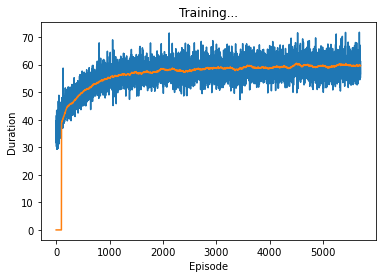

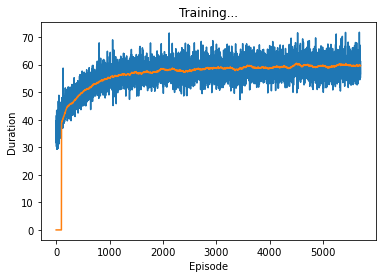

Current_train_num :  6003 Accuracy :  0.8067632850241546
F1 0.5423728813559322
688 569 592
train Current_train_num :  23995 Accuracy :  0.8041675349031048
F1 0.5151640189808129
2497 1841 2859
Current_train_num :  5709 LOSS :  -0.16754144430160522
0.007913895882666111
Current_train_num :  5719 LOSS :  -0.07421407103538513
0.006122834514826536
Current_train_num :  5729 LOSS :  -0.04684370011091232
0.008003951981663704
Current_train_num :  5739 LOSS :  -0.21866199374198914
0.0162397138774395
Current_train_num :  5749 LOSS :  -0.1151861771941185
0.017422443255782127
Current_train_num :  5759 LOSS :  -0.2540006935596466
0.013609813526272774
Current_train_num :  5769 LOSS :  -0.10442391782999039
0.019078968092799187
Current_train_num :  5779 LOSS :  -0.24602751433849335
0.008601042442023754
Current_train_num :  5789 LOSS :  -0.2483881711959839
0.00927677284926176
Current_train_num :  5799 LOSS :  -0.08697623014450073
0.003594108624383807


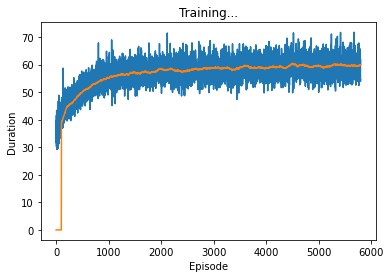

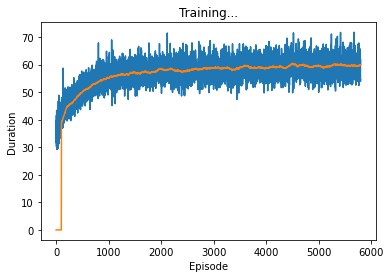

Current_train_num :  6003 Accuracy :  0.8085957021489255
F1 0.5432883240667196
684 554 596
train Current_train_num :  23995 Accuracy :  0.8045009376953532
F1 0.5145872129112352
2487 1823 2869
Current_train_num :  5809 LOSS :  -0.21358554065227509
0.008295364677906036
Current_train_num :  5819 LOSS :  -0.2539181411266327
0.004155866336077452
Current_train_num :  5829 LOSS :  -0.11986559629440308
0.0151951489970088
Current_train_num :  5839 LOSS :  -0.2501122057437897
0.006264375057071447
Current_train_num :  5849 LOSS :  -0.11622513085603714
0.017931411042809486
Current_train_num :  5859 LOSS :  -0.18982642889022827
0.009171757847070694
Current_train_num :  5869 LOSS :  -0.26267099380493164
-0.0010243398137390614
Current_train_num :  5879 LOSS :  -0.20665933191776276
0.002143744844943285
Current_train_num :  5889 LOSS :  -0.03284314647316933
0.01777513325214386
Current_train_num :  5899 LOSS :  -0.21918801963329315
0.022098077461123466


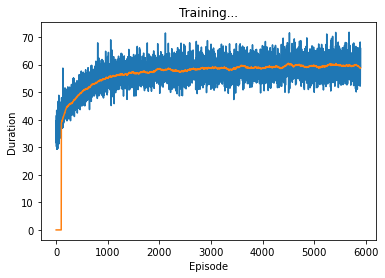

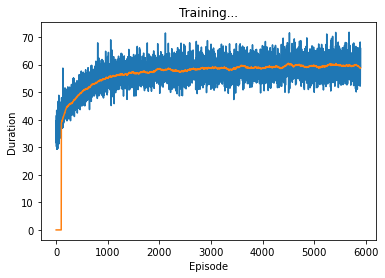

Current_train_num :  6003 Accuracy :  0.8104281192736965
F1 0.5453093812375249
683 542 597
5899
train Current_train_num :  23995 Accuracy :  0.8048760158366326
F1 0.5136566621663724
2473 1800 2883
Current_train_num :  5909 LOSS :  -0.18568439781665802
0.00843769870698452
Current_train_num :  5919 LOSS :  -0.10249096155166626
0.00489435950294137
Current_train_num :  5929 LOSS :  -0.09704191982746124
0.0023900072555989027
Current_train_num :  5939 LOSS :  -0.1676294356584549
0.015946002677083015
Current_train_num :  5949 LOSS :  -0.07909150421619415
0.007439059671014547
Current_train_num :  5959 LOSS :  -0.21480780839920044
0.0011256985599175096
Current_train_num :  5969 LOSS :  -0.14363907277584076
0.002899901708588004
Current_train_num :  5979 LOSS :  -0.11195472627878189
0.004297992214560509
Current_train_num :  5989 LOSS :  -0.1569058895111084
0.0022530029527843
Current_train_num :  5999 LOSS :  -0.23748987913131714
0.007222822867333889


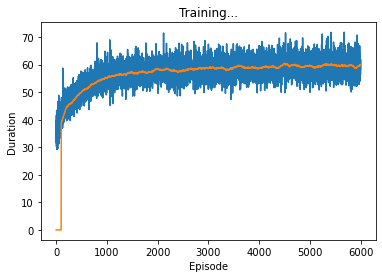

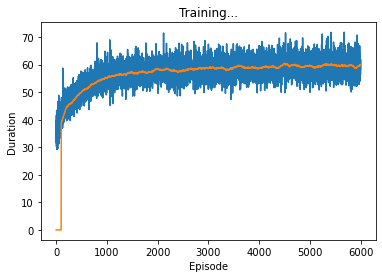

Current_train_num :  6003 Accuracy :  0.8102615358987173
F1 0.5443645083932853
681 541 599
train Current_train_num :  23995 Accuracy :  0.8049593665346947
F1 0.5136623376623377
2472 1797 2884
Current_train_num :  6009 LOSS :  -0.0722251757979393
0.0054682474583387375
Current_train_num :  6019 LOSS :  -0.07712297141551971
0.01457894966006279
Current_train_num :  6029 LOSS :  -0.056294120848178864
0.0028815623372793198
Current_train_num :  6039 LOSS :  -0.0775684043765068
0.0038282610476017
Current_train_num :  6049 LOSS :  -0.08465656638145447
0.0031866386998444796
Current_train_num :  6059 LOSS :  -0.014359960332512856
0.025142863392829895
Current_train_num :  6069 LOSS :  -0.06498290598392487
0.007339014206081629
Current_train_num :  6079 LOSS :  -0.2798349857330322
0.0024371203035116196
Current_train_num :  6089 LOSS :  -0.15312036871910095
0.0006473531830124557
Current_train_num :  6099 LOSS :  -0.03835630416870117
0.010860340669751167


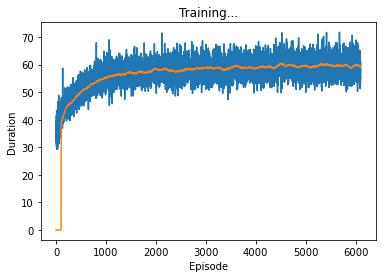

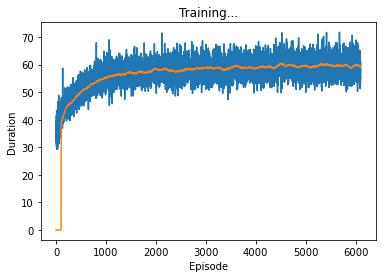

Current_train_num :  6003 Accuracy :  0.8107612860236548
F1 0.5450180072028812
681 538 599
train Current_train_num :  23995 Accuracy :  0.8051260679308189
F1 0.5138758964764577
2472 1793 2884
Current_train_num :  6109 LOSS :  -0.05297652259469032
0.006003394722938538
Current_train_num :  6119 LOSS :  -0.14612868428230286
0.004876894876360893
Current_train_num :  6129 LOSS :  -0.22185209393501282
0.00039041097625158727
Current_train_num :  6139 LOSS :  -0.05933251231908798
0.01896675117313862
Current_train_num :  6149 LOSS :  -0.4002249538898468
-0.004043380729854107
Current_train_num :  6159 LOSS :  -0.09265579283237457
0.0043554287403821945
Current_train_num :  6169 LOSS :  -0.03786681592464447
0.005351230967789888
Current_train_num :  6179 LOSS :  -0.13904358446598053
0.0036498033441603184
Current_train_num :  6189 LOSS :  -0.28977692127227783
0.009887765161693096
Current_train_num :  6199 LOSS :  -0.14007732272148132
0.0039740256033837795


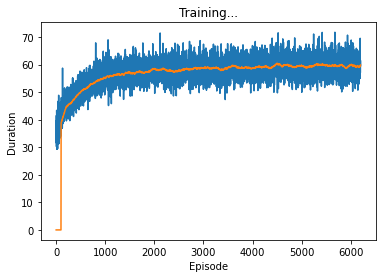

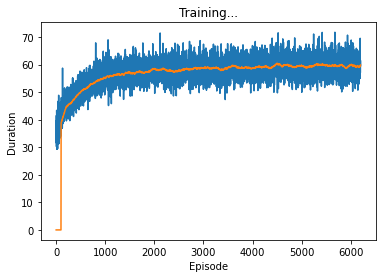

Current_train_num :  6003 Accuracy :  0.8112610361485924
F1 0.5449438202247191
679 533 601
train Current_train_num :  23995 Accuracy :  0.8052510939779121
F1 0.5134291068082448
2466 1784 2890
Current_train_num :  6209 LOSS :  -0.06307009607553482
0.010281541384756565
Current_train_num :  6219 LOSS :  -0.13255350291728973
0.00143381766974926
Current_train_num :  6229 LOSS :  -0.0442272387444973
0.005711210425943136
Current_train_num :  6239 LOSS :  -0.282839298248291
0.017345165833830833
Current_train_num :  6249 LOSS :  -0.17496396601200104
0.01335341390222311
Current_train_num :  6259 LOSS :  -0.030575601384043694
0.0035115317441523075
Current_train_num :  6269 LOSS :  -0.1829112023115158
0.01038676593452692
Current_train_num :  6279 LOSS :  -0.04120593145489693
0.010672233067452908
Current_train_num :  6289 LOSS :  -0.22769175469875336
0.006235001143068075
Current_train_num :  6299 LOSS :  -0.1719394475221634
-0.0012290620943531394


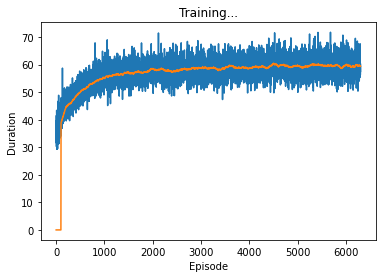

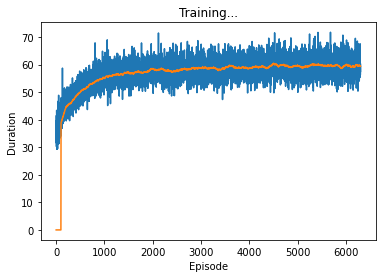

Current_train_num :  6003 Accuracy :  0.8120939530234883
F1 0.5460394049055086
679 528 601
6299
train Current_train_num :  23995 Accuracy :  0.8053344446759741
F1 0.5132319233173578
2463 1779 2893
Current_train_num :  6309 LOSS :  -0.054917026311159134
0.006089181639254093
Current_train_num :  6319 LOSS :  -0.08750412613153458
0.003066999139264226
Current_train_num :  6329 LOSS :  -0.06554624438285828
0.006975081283599138
Current_train_num :  6339 LOSS :  -0.053298961371183395
0.006772920954972506
Current_train_num :  6349 LOSS :  -0.1136658787727356
0.0080507667735219
Current_train_num :  6359 LOSS :  -0.04961000382900238
0.002957587596029043
Current_train_num :  6369 LOSS :  -0.03611552715301514
0.008666195906698704
Current_train_num :  6379 LOSS :  -0.04464989900588989
0.015479026362299919
Current_train_num :  6389 LOSS :  -0.20027793943881989
0.0018840564880520105
Current_train_num :  6399 LOSS :  -0.2121671587228775
0.0010790338274091482


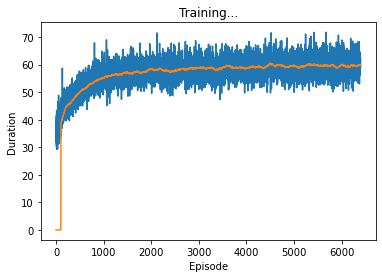

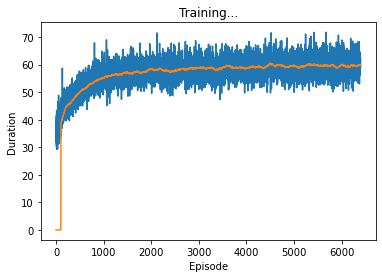

Current_train_num :  6003 Accuracy :  0.8107612860236548
F1 0.5446535843011614
680 537 600
train Current_train_num :  23995 Accuracy :  0.8050427172327568
F1 0.5138701298701299
2473 1796 2883
Current_train_num :  6409 LOSS :  -0.183489590883255
0.0031839520670473576
Current_train_num :  6419 LOSS :  -0.08970215171575546
0.004131055437028408
Current_train_num :  6429 LOSS :  -0.0617397166788578
0.0007995096384547651
Current_train_num :  6439 LOSS :  -0.0584898516535759
0.005021382123231888
Current_train_num :  6449 LOSS :  -0.16345669329166412
0.0037623464595526457
Current_train_num :  6459 LOSS :  -0.1078639030456543
0.011037477292120457
Current_train_num :  6469 LOSS :  -0.29312562942504883
0.00038420429336838424
Current_train_num :  6479 LOSS :  -0.09104043245315552
0.001721792621538043
Current_train_num :  6489 LOSS :  -0.14440488815307617
0.01691521145403385
Current_train_num :  6499 LOSS :  -0.17867614328861237
0.0023923141416162252


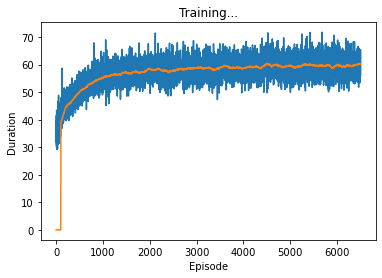

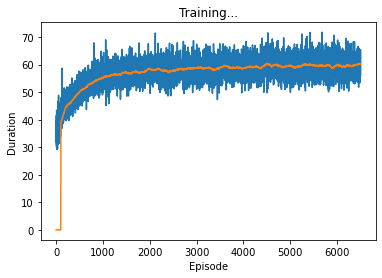

Current_train_num :  6003 Accuracy :  0.8094286190238215
F1 0.545093365117203
686 551 594
train Current_train_num :  23995 Accuracy :  0.8045009376953532
F1 0.5150888797023564
2492 1828 2864
Current_train_num :  6509 LOSS :  -0.23079551756381989
0.012019649147987366
Current_train_num :  6519 LOSS :  -0.08780422806739807
0.011563794687390327
Current_train_num :  6529 LOSS :  -0.08620297163724899
0.002209881553426385
Current_train_num :  6539 LOSS :  -0.10599574446678162
0.007316035218536854
Current_train_num :  6549 LOSS :  -0.09220519661903381
0.011335144750773907
Current_train_num :  6559 LOSS :  -0.2580680251121521
0.006446268875151873
Current_train_num :  6569 LOSS :  -0.006040020380169153
0.029641762375831604
Current_train_num :  6579 LOSS :  -0.12238889932632446
0.010210683569312096
Current_train_num :  6589 LOSS :  -0.1917804479598999
0.007952669635415077
Current_train_num :  6599 LOSS :  -0.06735090911388397
0.004123653285205364


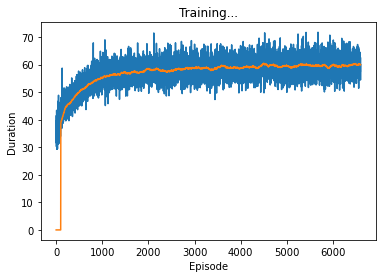

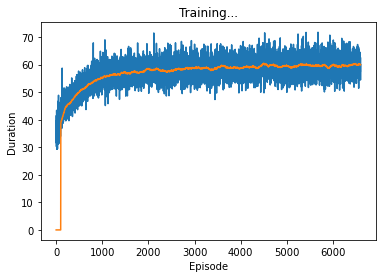

Current_train_num :  6003 Accuracy :  0.8077627852740297
F1 0.544018949861824
689 564 591
train Current_train_num :  23995 Accuracy :  0.8044175869972912
F1 0.5170781893004115
2513 1851 2843
Current_train_num :  6609 LOSS :  -0.1443435102701187
0.0075132534839212894
Current_train_num :  6619 LOSS :  -0.22172895073890686
0.004030924290418625
Current_train_num :  6629 LOSS :  -0.03902372345328331
0.005816513206809759
Current_train_num :  6639 LOSS :  -0.17118513584136963
0.012108423747122288
Current_train_num :  6649 LOSS :  -0.20507781207561493
0.005400001537054777
Current_train_num :  6659 LOSS :  -0.03282438591122627
0.021988609805703163
Current_train_num :  6669 LOSS :  -0.04245205596089363
0.009924203157424927
Current_train_num :  6679 LOSS :  -0.11434333771467209
0.005936632864177227
Current_train_num :  6689 LOSS :  -0.2272220402956009
0.0016770687652751803
Current_train_num :  6699 LOSS :  -0.10375469923019409
0.0011286832159385085


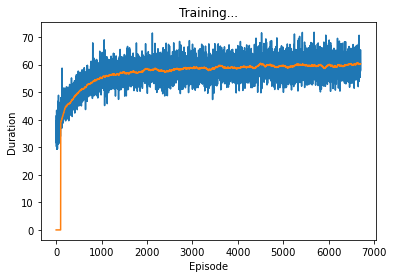

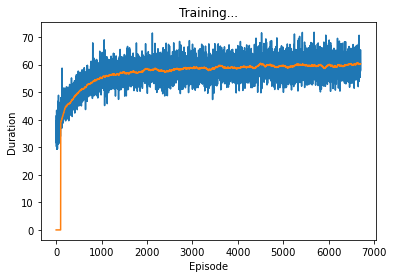

Current_train_num :  6003 Accuracy :  0.809928369148759
F1 0.5446570972886763
683 545 597
train Current_train_num :  23995 Accuracy :  0.8048343404876016
F1 0.5147119767923747
2484 1812 2872
Current_train_num :  6709 LOSS :  -0.22699254751205444
5.7799217756837606e-05
Current_train_num :  6719 LOSS :  -0.17826291918754578
0.0050417655147612095
Current_train_num :  6729 LOSS :  -0.035626575350761414
0.014590909704566002
Current_train_num :  6739 LOSS :  -0.1953553557395935
0.007339284755289555
Current_train_num :  6749 LOSS :  -0.06619387865066528
0.010015781037509441
Current_train_num :  6759 LOSS :  -0.10055118799209595
0.014460273087024689
Current_train_num :  6769 LOSS :  -0.18520943820476532
0.009850911796092987
Current_train_num :  6779 LOSS :  -0.20086875557899475
0.009247571229934692
Current_train_num :  6789 LOSS :  -0.0969393253326416
0.005534114316105843
Current_train_num :  6799 LOSS :  -0.23753508925437927
0.007868546061217785


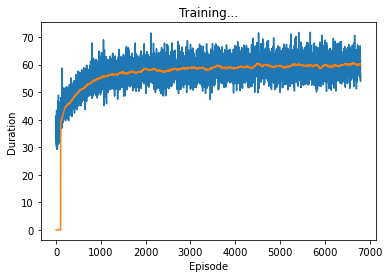

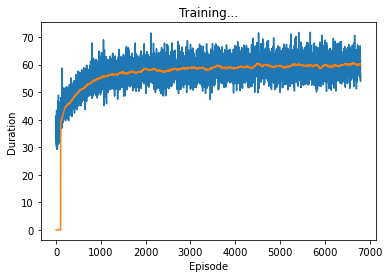

Current_train_num :  6003 Accuracy :  0.8105947026486756
F1 0.5448
681 539 599
train Current_train_num :  23995 Accuracy :  0.8050427172327568
F1 0.5144754591677908
2479 1802 2877
Current_train_num :  6809 LOSS :  -0.09932471811771393
0.011231211945414543
Current_train_num :  6819 LOSS :  -0.14495263993740082
0.005009426269680262
Current_train_num :  6829 LOSS :  -0.2601967453956604
0.0036629317328333855
Current_train_num :  6839 LOSS :  -0.0902044028043747
0.004343193955719471
Current_train_num :  6849 LOSS :  -0.13702917098999023
0.01231860090047121
Current_train_num :  6859 LOSS :  -0.03449471667408943
0.007790809031575918
Current_train_num :  6869 LOSS :  -0.0656457394361496
0.0071195317432284355
Current_train_num :  6879 LOSS :  -0.11772944033145905
0.011963604018092155
Current_train_num :  6889 LOSS :  -0.10610973834991455
0.004989649169147015
Current_train_num :  6899 LOSS :  -0.0540008544921875
0.0030486853793263435


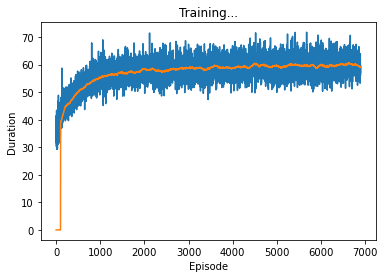

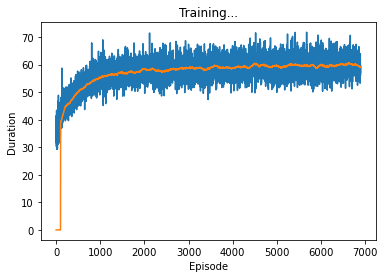

Current_train_num :  6003 Accuracy :  0.8119273696485091
F1 0.5450885668276972
677 527 603
train Current_train_num :  23995 Accuracy :  0.8053761200250052
F1 0.5135895032802249
2466 1781 2890
Current_train_num :  6909 LOSS :  -0.0666336715221405
0.004394260235130787
Current_train_num :  6919 LOSS :  -0.09586374461650848
0.002702124183997512
Current_train_num :  6929 LOSS :  -0.21262231469154358
0.002957440447062254
Current_train_num :  6939 LOSS :  -0.10445459187030792
0.016756322234869003
Current_train_num :  6949 LOSS :  -0.070531465113163
0.0031898529268801212
Current_train_num :  6959 LOSS :  -0.030734894797205925
0.0025366635527461767
Current_train_num :  6969 LOSS :  -0.009118586778640747
0.004811613820493221
Current_train_num :  6979 LOSS :  -0.1211780309677124
0.00977695919573307
Current_train_num :  6989 LOSS :  -0.22483192384243011
0.009766943752765656
Current_train_num :  6999 LOSS :  -0.1333184391260147
0.0013125905534252524


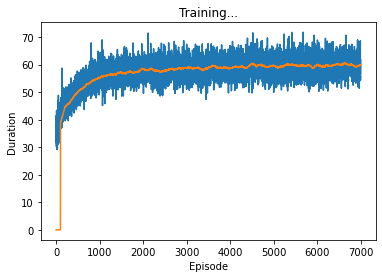

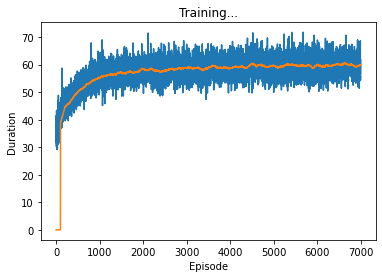

Current_train_num :  6003 Accuracy :  0.8100949525237381
F1 0.5445109780439121
682 543 598
train Current_train_num :  23995 Accuracy :  0.8047509897895395
F1 0.5144041450777203
2482 1812 2874
Current_train_num :  7009 LOSS :  -0.1278165876865387
0.011414231732487679
Current_train_num :  7019 LOSS :  -0.05278564244508743
0.011251632124185562
Current_train_num :  7029 LOSS :  -0.13216271996498108
0.01061696745455265
Current_train_num :  7039 LOSS :  -0.2457987368106842
0.010887831449508667
Current_train_num :  7049 LOSS :  -0.10996925830841064
0.002235747640952468
Current_train_num :  7059 LOSS :  -0.26943325996398926
0.0005850769230164587
Current_train_num :  7069 LOSS :  -0.2078021913766861
0.006589825265109539
Current_train_num :  7079 LOSS :  -0.06499915570020676
0.005752467084676027
Current_train_num :  7089 LOSS :  -0.07441340386867523
0.010831722989678383
Current_train_num :  7099 LOSS :  -0.10457926243543625
0.011747917160391808


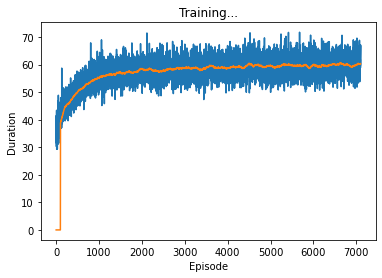

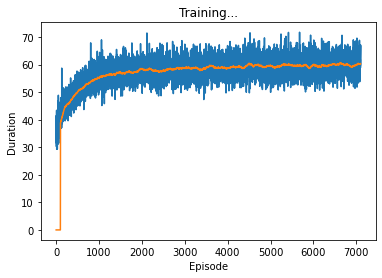

Current_train_num :  6003 Accuracy :  0.8100949525237381
F1 0.5452371462734157
684 545 596
train Current_train_num :  23995 Accuracy :  0.8046259637424463
F1 0.5152486302077949
2492 1825 2864
Current_train_num :  7109 LOSS :  -0.08181171864271164
0.007800939492881298
Current_train_num :  7119 LOSS :  -0.14682281017303467
0.015586853958666325
Current_train_num :  7129 LOSS :  -0.07573133707046509
0.011938555166125298
Current_train_num :  7139 LOSS :  -0.01767864264547825
0.007546691689640284
Current_train_num :  7149 LOSS :  -0.3251558244228363
-0.0036475611850619316
Current_train_num :  7159 LOSS :  -0.11766436696052551
0.004196219611912966
Current_train_num :  7169 LOSS :  -0.03250318765640259
0.006104358471930027
Current_train_num :  7179 LOSS :  -0.27698028087615967
-0.0009557628654874861
Current_train_num :  7189 LOSS :  -0.19009576737880707
-0.0005420706584118307
Current_train_num :  7199 LOSS :  -0.06914965063333511
0.005660031456500292


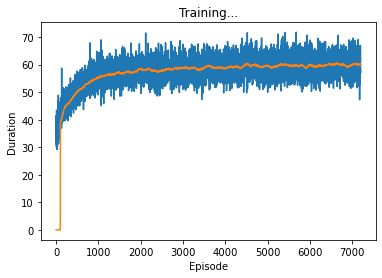

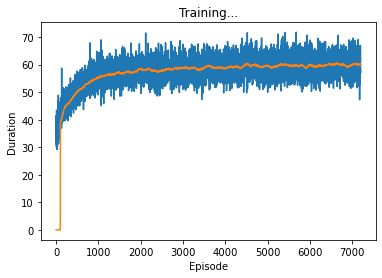

Current_train_num :  6003 Accuracy :  0.8100949525237381
F1 0.5445109780439121
682 543 598
train Current_train_num :  23995 Accuracy :  0.8050010418837258
F1 0.5152268489745183
2487 1811 2869
Current_train_num :  7209 LOSS :  -0.18765409290790558
0.00700434809550643
Current_train_num :  7219 LOSS :  -0.40391889214515686
-0.005319574382156134
Current_train_num :  7229 LOSS :  -0.13060662150382996
0.0022321525029838085
Current_train_num :  7239 LOSS :  -0.12540379166603088
0.004075009375810623
Current_train_num :  7249 LOSS :  -0.2209930270910263
0.01089388132095337
Current_train_num :  7259 LOSS :  -0.19435125589370728
0.0006203920347616076
Current_train_num :  7269 LOSS :  -0.09429600834846497
0.008320452645421028
Current_train_num :  7279 LOSS :  -0.13632804155349731
0.011967564933001995
Current_train_num :  7289 LOSS :  -0.13461831212043762
0.00479711452499032
Current_train_num :  7299 LOSS :  -0.0404156930744648
0.0026778276078402996


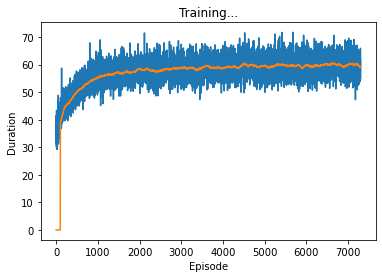

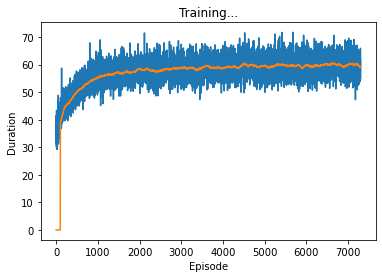

Current_train_num :  6003 Accuracy :  0.8117607862735299
F1 0.5445026178010471
676 527 604
train Current_train_num :  23995 Accuracy :  0.8055428214211294
F1 0.5138035212001251
2466 1777 2890
Current_train_num :  7309 LOSS :  -0.002845166949555278
0.01646782085299492
Current_train_num :  7319 LOSS :  -0.1515146940946579
0.008537057787179947
Current_train_num :  7329 LOSS :  -0.29183632135391235
0.017627663910388947
Current_train_num :  7339 LOSS :  -0.06521284580230713
0.010498826391994953
Current_train_num :  7349 LOSS :  -0.0959705263376236
0.011185742914676666
Current_train_num :  7359 LOSS :  -0.20314493775367737
0.010298976674675941
Current_train_num :  7369 LOSS :  -0.006792967673391104
0.009598829783499241
Current_train_num :  7379 LOSS :  -0.12775973975658417
0.004945170134305954
Current_train_num :  7389 LOSS :  -0.11535947769880295
0.0099382558837533
Current_train_num :  7399 LOSS :  -0.15166522562503815
0.000898426806088537


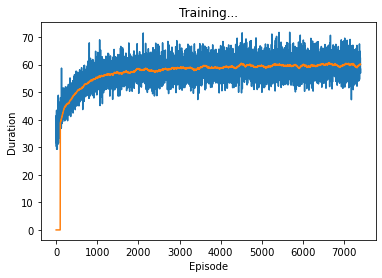

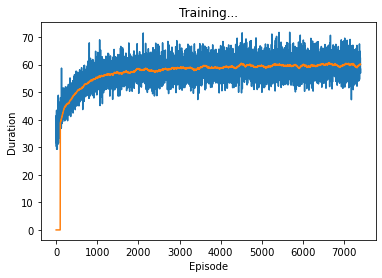

Current_train_num :  6003 Accuracy :  0.810927869398634
F1 0.5448717948717948
680 536 600
train Current_train_num :  23995 Accuracy :  0.8049176911856637
F1 0.5138110072689512
2474 1800 2882
Current_train_num :  7409 LOSS :  -0.07831010967493057
0.0100927222520113
Current_train_num :  7419 LOSS :  -0.13888776302337646
0.006750862114131451
Current_train_num :  7429 LOSS :  -0.19988584518432617
0.0049781808629632
Current_train_num :  7439 LOSS :  -0.20605865120887756
0.018318993970751762
Current_train_num :  7449 LOSS :  -0.17960016429424286
0.0009791492484509945
Current_train_num :  7459 LOSS :  -0.05591658502817154
0.008558491244912148
Current_train_num :  7469 LOSS :  -0.06213243678212166
0.004391356837004423
Current_train_num :  7479 LOSS :  -0.07349828630685806
0.014535682275891304
Current_train_num :  7489 LOSS :  -0.08743015676736832
0.013628678396344185
Current_train_num :  7499 LOSS :  -0.04659483954310417
0.017982924357056618


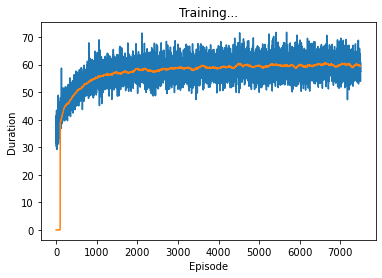

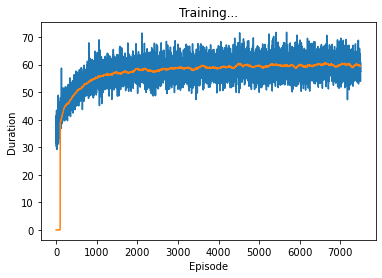

Current_train_num :  6003 Accuracy :  0.8100949525237381
F1 0.5448743518149183
683 544 597
train Current_train_num :  23995 Accuracy :  0.8046259637424463
F1 0.5152486302077949
2492 1825 2864
Current_train_num :  7509 LOSS :  -0.12984558939933777
0.005932611878961325
Current_train_num :  7519 LOSS :  -0.20138058066368103
0.013822002336382866
Current_train_num :  7529 LOSS :  -0.059893637895584106
0.011232520453631878
Current_train_num :  7539 LOSS :  -0.042966265231370926
0.012494486756622791
Current_train_num :  7549 LOSS :  -0.2866903841495514
-0.0019181548850610852
Current_train_num :  7559 LOSS :  -0.028821978718042374
0.014276043511927128
Current_train_num :  7569 LOSS :  -0.018622741103172302
0.01180417463183403
Current_train_num :  7579 LOSS :  -0.1108446940779686
0.021639317274093628
Current_train_num :  7589 LOSS :  -0.04722324013710022
0.005960461217910051
Current_train_num :  7599 LOSS :  -0.16270488500595093
-0.0006146646337583661


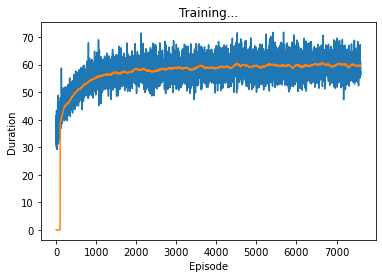

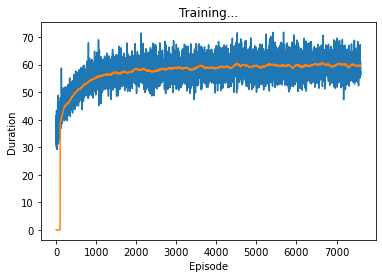

Current_train_num :  6003 Accuracy :  0.809928369148759
F1 0.5446570972886763
683 545 597
train Current_train_num :  23995 Accuracy :  0.8047509897895395
F1 0.5157089706490285
2495 1825 2861
Current_train_num :  7609 LOSS :  -0.11471587419509888
0.004938541445881128
Current_train_num :  7619 LOSS :  -0.06800146400928497
0.0037050216924399137
Current_train_num :  7629 LOSS :  -0.14873230457305908
0.005956193432211876
Current_train_num :  7639 LOSS :  -0.02580747939646244
0.002132354537025094
Current_train_num :  7649 LOSS :  -0.03312499448657036
0.007144691422581673
Current_train_num :  7659 LOSS :  -0.10870421677827835
0.0025056840386241674
Current_train_num :  7669 LOSS :  -0.10903357714414597
0.013741496950387955
Current_train_num :  7679 LOSS :  -0.11170937865972519
0.017257874831557274
Current_train_num :  7689 LOSS :  -0.0031527671962976456
0.012935081496834755
Current_train_num :  7699 LOSS :  -0.07608199864625931
0.013065255247056484


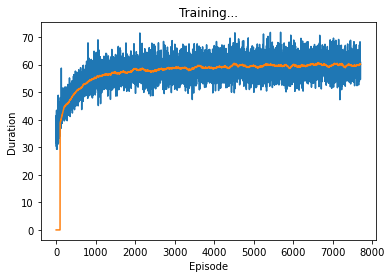

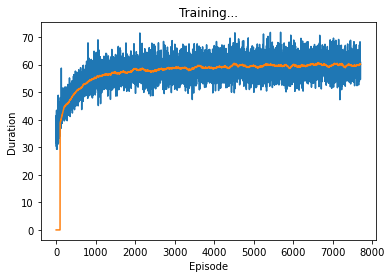

Current_train_num :  6003 Accuracy :  0.8107612860236548
F1 0.5453818472610955
682 539 598
train Current_train_num :  23995 Accuracy :  0.8048343404876016
F1 0.5146113989637305
2483 1811 2873
Current_train_num :  7709 LOSS :  -0.060076385736465454
0.009351629763841629
Current_train_num :  7719 LOSS :  -0.06858689337968826
0.002882376778870821
Current_train_num :  7729 LOSS :  -0.025249918922781944
0.022681929171085358
Current_train_num :  7739 LOSS :  -0.25662359595298767
-0.0017176630208268762
Current_train_num :  7749 LOSS :  -0.1762135922908783
0.00053572584874928
Current_train_num :  7759 LOSS :  -0.15032750368118286
0.00705832289531827
Current_train_num :  7769 LOSS :  -0.006782903335988522
0.004852656740695238
Current_train_num :  7779 LOSS :  -0.035369545221328735
0.008270449005067348
Current_train_num :  7789 LOSS :  -0.13814736902713776
0.006119002588093281
Current_train_num :  7799 LOSS :  -0.18649329245090485
0.014855894260108471


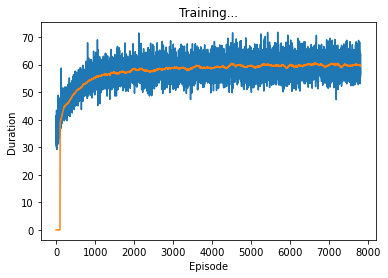

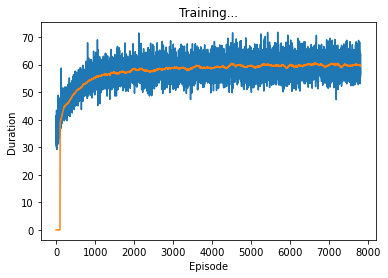

Current_train_num :  6003 Accuracy :  0.8105947026486756
F1 0.544435548438751
680 538 600
train Current_train_num :  23995 Accuracy :  0.8049593665346947
F1 0.5149725417055228
2485 1810 2871
Current_train_num :  7809 LOSS :  -0.0460880883038044
0.001984851434826851
Current_train_num :  7819 LOSS :  -0.07063459604978561
0.015092086978256702
Current_train_num :  7829 LOSS :  -0.16307830810546875
0.0027787117287516594
Current_train_num :  7839 LOSS :  -0.042276110500097275
0.004614179953932762
Current_train_num :  7849 LOSS :  -0.0453927181661129
0.009973481297492981
Current_train_num :  7859 LOSS :  -0.14735475182533264
-0.0005576747935265303
Current_train_num :  7869 LOSS :  -0.10950863361358643
0.0018401732668280602
Current_train_num :  7879 LOSS :  -0.13324761390686035
0.0070457449182868
Current_train_num :  7889 LOSS :  -0.13863389194011688
0.02008686773478985
Current_train_num :  7899 LOSS :  -0.05295044928789139
0.003720537992194295


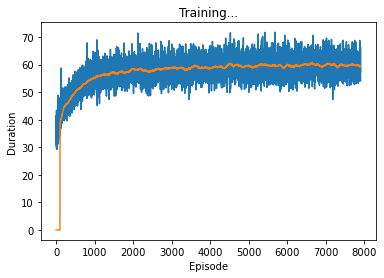

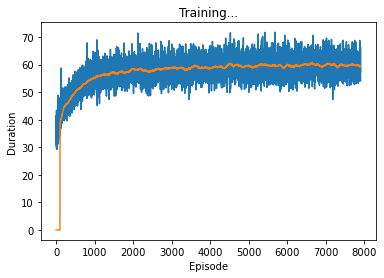

Current_train_num :  6003 Accuracy :  0.8102615358987173
F1 0.544
680 540 600
train Current_train_num :  23995 Accuracy :  0.8047093144405084
F1 0.5150543197102949
2489 1820 2867
Current_train_num :  7909 LOSS :  -0.022126223891973495
0.011738874018192291
Current_train_num :  7919 LOSS :  -0.1649503856897354
0.014306951314210892
Current_train_num :  7929 LOSS :  -0.1435612291097641
0.0021644930820912123
Current_train_num :  7939 LOSS :  -0.18314316868782043
0.004868995863944292
Current_train_num :  7949 LOSS :  -0.0993371233344078
0.017147764563560486
Current_train_num :  7959 LOSS :  -0.1703374981880188
0.021924778819084167
Current_train_num :  7969 LOSS :  -0.17729713022708893
0.003077576868236065
Current_train_num :  7979 LOSS :  -0.015595931559801102
0.02159813418984413
Current_train_num :  7989 LOSS :  -0.05623851716518402
0.0033167023211717606
Current_train_num :  7999 LOSS :  -0.29764342308044434
0.011551507748663425


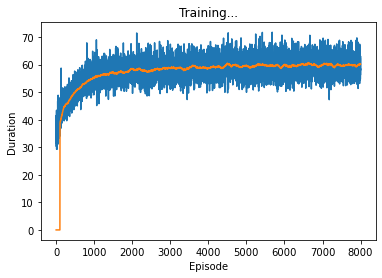

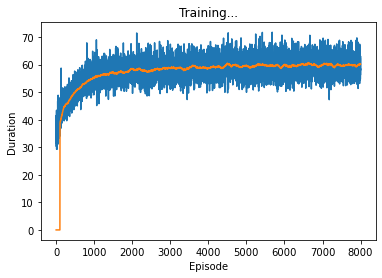

Current_train_num :  6003 Accuracy :  0.809928369148759
F1 0.5461049284578696
687 549 593
7999
train Current_train_num :  23995 Accuracy :  0.8045009376953532
F1 0.5152892561983471
2494 1830 2862
Current_train_num :  8009 LOSS :  -0.3802963197231293
-0.0021789271850138903
Current_train_num :  8019 LOSS :  -0.11929454654455185
0.00729338638484478
Current_train_num :  8029 LOSS :  -0.13297045230865479
0.010132411494851112
Current_train_num :  8039 LOSS :  -0.022845959290862083
0.0047035519964993
Current_train_num :  8049 LOSS :  -0.21353743970394135
0.006351444870233536
Current_train_num :  8059 LOSS :  -0.12690551578998566
0.006989825051277876
Current_train_num :  8069 LOSS :  -0.19465871155261993
0.005489600822329521
Current_train_num :  8079 LOSS :  -0.30076414346694946
0.001452577649615705
Current_train_num :  8089 LOSS :  -0.19511760771274567
0.022421453148126602
Current_train_num :  8099 LOSS :  -0.19837766885757446
0.003748434828594327


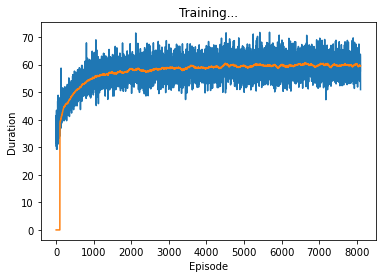

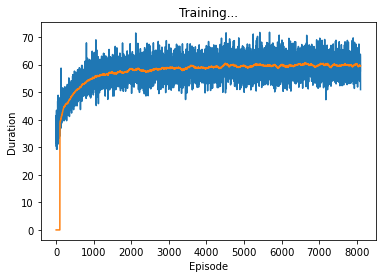

Current_train_num :  6003 Accuracy :  0.8105947026486756
F1 0.5451638689048761
682 540 598
train Current_train_num :  23995 Accuracy :  0.8046676390914774
F1 0.5150010345541072
2489 1821 2867
Current_train_num :  8109 LOSS :  0.0019750173669308424
0.013325621373951435
Current_train_num :  8119 LOSS :  -0.32568657398223877
0.003509843721985817
Current_train_num :  8129 LOSS :  -0.17265424132347107
0.009105702862143517
Current_train_num :  8139 LOSS :  -0.05536637455224991
0.008016295731067657
Current_train_num :  8149 LOSS :  -0.032685812562704086
0.01635868102312088
Current_train_num :  8159 LOSS :  -0.13130605220794678
0.010504557751119137
Current_train_num :  8169 LOSS :  -0.04627640172839165
0.0075425393879413605
Current_train_num :  8179 LOSS :  -0.07371639460325241
0.011234495788812637
Current_train_num :  8189 LOSS :  -0.02562689036130905
0.01600949466228485
Current_train_num :  8199 LOSS :  -0.023830480873584747
0.010172712616622448


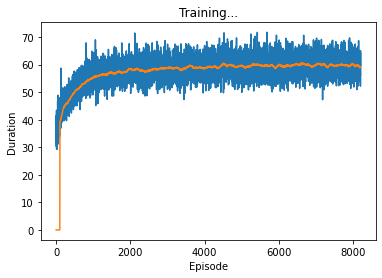

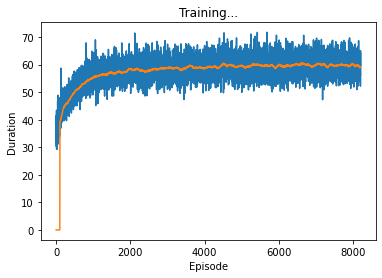

Current_train_num :  6003 Accuracy :  0.8107612860236548
F1 0.5446535843011614
680 537 600
train Current_train_num :  23995 Accuracy :  0.8049593665346947
F1 0.5149725417055228
2485 1810 2871
Current_train_num :  8209 LOSS :  -0.07231012731790543
0.01038887444883585
Current_train_num :  8219 LOSS :  -0.07494185119867325
0.01611773855984211
Current_train_num :  8229 LOSS :  -0.079054094851017
0.0017239328008145094
Current_train_num :  8239 LOSS :  -0.0816088318824768
0.0023571373894810677
Current_train_num :  8249 LOSS :  -0.15965601801872253
0.006634997669607401
Current_train_num :  8259 LOSS :  -0.15328168869018555
0.012548791244626045
Current_train_num :  8269 LOSS :  -0.09419743716716766
0.007816217839717865
Current_train_num :  8279 LOSS :  -0.12394720315933228
0.007475591264665127
Current_train_num :  8289 LOSS :  -0.12016914784908295
0.001562771387398243
Current_train_num :  8299 LOSS :  -0.0792197436094284
0.005932067520916462


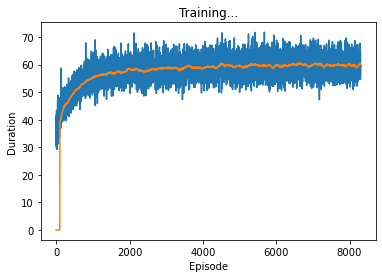

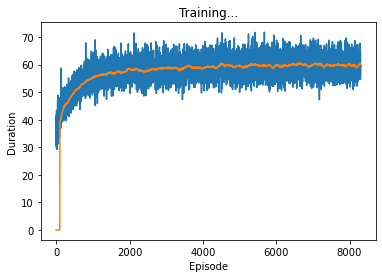

Current_train_num :  6003 Accuracy :  0.8110944527736131
F1 0.5465441470235717
684 539 596
8299
train Current_train_num :  23995 Accuracy :  0.8046676390914774
F1 0.5150010345541072
2489 1821 2867
Current_train_num :  8309 LOSS :  -0.24736319482326508
0.010041902773082256
Current_train_num :  8319 LOSS :  -0.021010152995586395
0.010137474164366722
Current_train_num :  8329 LOSS :  -0.17138689756393433
0.0027326878625899553
Current_train_num :  8339 LOSS :  -0.009067349135875702
0.006578668486326933
Current_train_num :  8349 LOSS :  -0.03844963014125824
0.021078897640109062
Current_train_num :  8359 LOSS :  -0.07986171543598175
0.003391352016478777
Current_train_num :  8369 LOSS :  -0.16094055771827698
0.0019977360498160124
Current_train_num :  8379 LOSS :  -0.08427754044532776
0.01207499299198389
Current_train_num :  8389 LOSS :  -0.43556803464889526
-0.003346852958202362
Current_train_num :  8399 LOSS :  -0.047723036259412766
0.012191353365778923


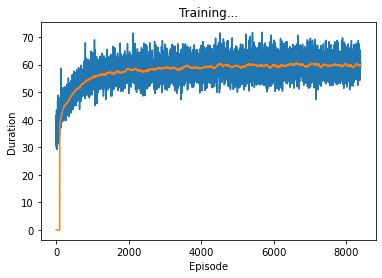

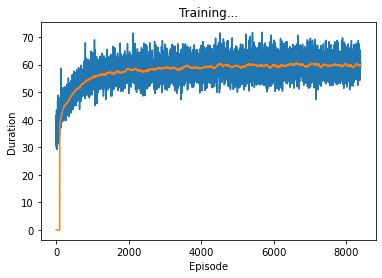

Current_train_num :  6003 Accuracy :  0.8107612860236548
F1 0.5461077844311377
684 541 596
train Current_train_num :  23995 Accuracy :  0.8046676390914774
F1 0.5152016546018614
2491 1823 2865
Current_train_num :  8409 LOSS :  -0.1682155430316925
0.0073056332767009735
Current_train_num :  8419 LOSS :  -0.04260428622364998
0.004601071588695049
Current_train_num :  8429 LOSS :  -0.2351805418729782
0.0004074823809787631
Current_train_num :  8439 LOSS :  -0.10497688502073288
0.011445102281868458
Current_train_num :  8449 LOSS :  -0.04859274998307228
0.01895574852824211
Current_train_num :  8459 LOSS :  -0.04336497187614441
0.012050853110849857
Current_train_num :  8469 LOSS :  -0.18995048105716705
0.0009233357268385589
Current_train_num :  8479 LOSS :  -0.22478151321411133
0.011868579313158989
Current_train_num :  8489 LOSS :  -0.2523282766342163
0.008015884086489677
Current_train_num :  8499 LOSS :  -0.047183435410261154
0.0022183640394359827


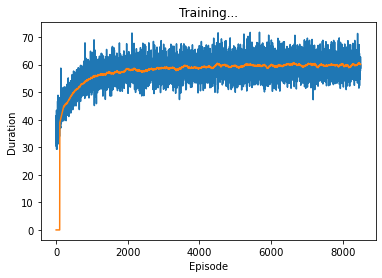

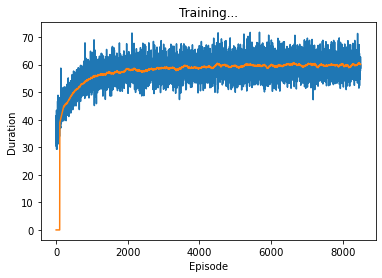

Current_train_num :  6003 Accuracy :  0.8110944527736131
F1 0.5465441470235717
684 539 596
train Current_train_num :  23995 Accuracy :  0.8046676390914774
F1 0.5153019023986766
2492 1824 2864
Current_train_num :  8509 LOSS :  -0.006107907742261887
0.004713508766144514
Current_train_num :  8519 LOSS :  -0.016674445942044258
0.008831856772303581
Current_train_num :  8529 LOSS :  -0.14211463928222656
0.003633808810263872
Current_train_num :  8539 LOSS :  -0.04133065789937973
0.01915046200156212
Current_train_num :  8549 LOSS :  -0.09302843362092972
0.014218756929039955
Current_train_num :  8559 LOSS :  -0.18325906991958618
0.009323417209088802
Current_train_num :  8569 LOSS :  -0.0990721732378006
0.007732003927230835
Current_train_num :  8579 LOSS :  -0.09107570350170135
0.004770839121192694
Current_train_num :  8589 LOSS :  -0.24559295177459717
0.003147084964439273
Current_train_num :  8599 LOSS :  -0.1973094791173935
-0.00028989941347390413


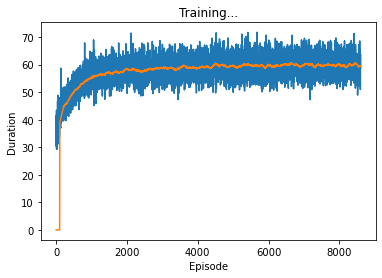

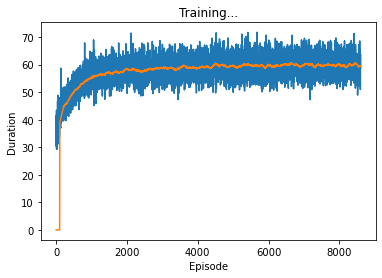

Current_train_num :  6003 Accuracy :  0.8105947026486756
F1 0.5462519936204147
685 543 595
train Current_train_num :  23995 Accuracy :  0.8047093144405084
F1 0.5154553912953582
2493 1824 2863
Current_train_num :  8609 LOSS :  -0.06625276058912277
0.0011439595837146044
Current_train_num :  8619 LOSS :  -0.14333584904670715
0.010932417586445808
Current_train_num :  8629 LOSS :  -0.060887277126312256
0.013249602168798447
Current_train_num :  8639 LOSS :  -0.012799655087292194
0.008244788274168968
Current_train_num :  8649 LOSS :  -0.13437695801258087
0.00844783615320921
Current_train_num :  8659 LOSS :  -0.0779590904712677
0.006767292506992817
Current_train_num :  8669 LOSS :  -0.18960870802402496
-0.0014264616183936596
Current_train_num :  8679 LOSS :  -0.04165339469909668
0.00353264226578176
Current_train_num :  8689 LOSS :  -0.10285423696041107
0.018427161499857903
Current_train_num :  8699 LOSS :  -0.055679284036159515
0.02733641117811203


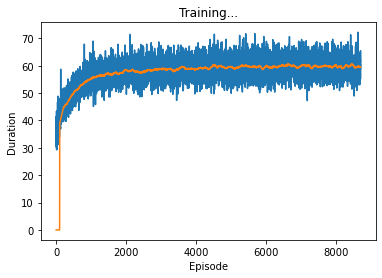

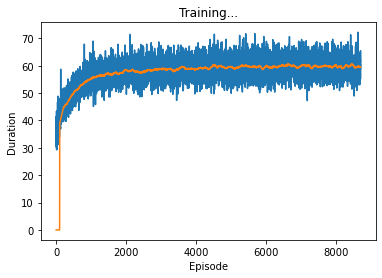

Current_train_num :  6003 Accuracy :  0.8115942028985508
F1 0.5464743589743589
682 534 598
train Current_train_num :  23995 Accuracy :  0.8049593665346947
F1 0.5146708138932089
2482 1807 2874
Current_train_num :  8709 LOSS :  -0.11805398017168045
0.019014477729797363
Current_train_num :  8719 LOSS :  -0.10149293392896652
0.010331889614462852
Current_train_num :  8729 LOSS :  -0.15083745121955872
0.0058609070256352425
Current_train_num :  8739 LOSS :  -0.13107575476169586
0.002075777156278491
Current_train_num :  8749 LOSS :  -0.20848986506462097
0.004827425349503756
Current_train_num :  8759 LOSS :  -0.0407334603369236
0.009408244863152504
Current_train_num :  8769 LOSS :  -0.07238973677158356
0.004494690336287022
Current_train_num :  8779 LOSS :  -0.14698044955730438
0.002468795282766223
Current_train_num :  8789 LOSS :  -0.03741784393787384
0.003072775900363922
Current_train_num :  8799 LOSS :  -0.034152060747146606
0.0065002115443348885


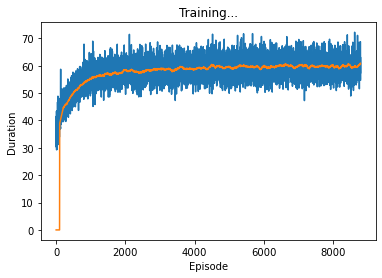

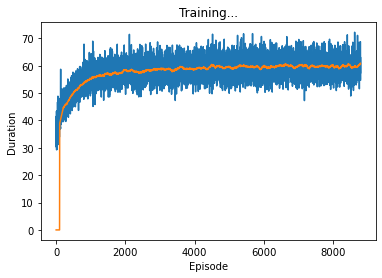

Current_train_num :  6003 Accuracy :  0.8119273696485091
F1 0.5458199356913184
679 529 601
train Current_train_num :  23995 Accuracy :  0.8056261721191915
F1 0.5152239426374312
2479 1788 2877
Current_train_num :  8809 LOSS :  -0.20256787538528442
0.015240659937262535
Current_train_num :  8819 LOSS :  -0.15953274071216583
0.01260045263916254
Current_train_num :  8829 LOSS :  -0.14676642417907715
0.0008655238198116422
Current_train_num :  8839 LOSS :  -0.1366184502840042
0.0033577310387045145
Current_train_num :  8849 LOSS :  -0.06896685808897018
0.027037058025598526
Current_train_num :  8859 LOSS :  -0.15900973975658417
0.013056525029242039
Current_train_num :  8869 LOSS :  -0.05667030066251755
0.004522622562944889
Current_train_num :  8879 LOSS :  -0.09991549700498581
0.00781370047479868
Current_train_num :  8889 LOSS :  -0.0002712648711167276
0.009182780981063843
Current_train_num :  8899 LOSS :  -0.12797538936138153
0.0016759955324232578


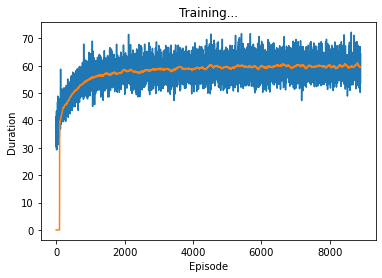

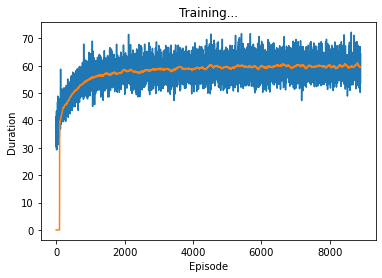

Current_train_num :  6003 Accuracy :  0.810927869398634
F1 0.5470494417862839
686 542 594
8899
train Current_train_num :  23995 Accuracy :  0.8047509897895395
F1 0.5154084798345399
2492 1822 2864
Current_train_num :  8909 LOSS :  -0.14799337089061737
0.003413558006286621
Current_train_num :  8919 LOSS :  -0.0369676910340786
0.00347519526258111
Current_train_num :  8929 LOSS :  -0.1920284926891327
-0.00028872667462565005
Current_train_num :  8939 LOSS :  -0.041691552847623825
0.006945253815501928
Current_train_num :  8949 LOSS :  -0.1264692097902298
0.0008544308948330581
Current_train_num :  8959 LOSS :  -0.1217360720038414
0.0028470177203416824
Current_train_num :  8969 LOSS :  -0.06253640353679657
0.003014699323102832
Current_train_num :  8979 LOSS :  -0.08298878371715546
0.004938080441206694
Current_train_num :  8989 LOSS :  -0.2939921021461487
-0.00045175058767199516
Current_train_num :  8999 LOSS :  -0.16209767758846283
0.014036139473319054


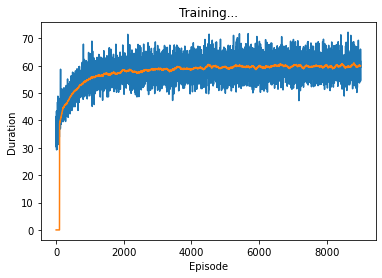

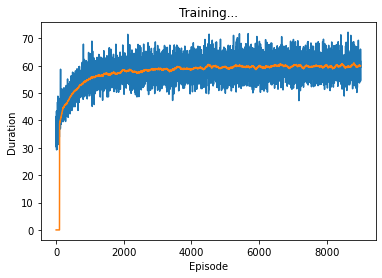

Current_train_num :  6003 Accuracy :  0.8117607862735299
F1 0.54632972322503
681 532 599
train Current_train_num :  23995 Accuracy :  0.80516774327985
F1 0.5144340602284527
2477 1797 2879
Current_train_num :  9009 LOSS :  -0.027794575318694115
0.0021345026325434446
Current_train_num :  9019 LOSS :  -0.010681182146072388
0.003988474607467651
Current_train_num :  9029 LOSS :  -0.08011046051979065
0.016547445207834244
Current_train_num :  9039 LOSS :  0.013588102534413338
0.02336333505809307
Current_train_num :  9049 LOSS :  -0.05911600589752197
0.007511303294450045
Current_train_num :  9059 LOSS :  -0.034637201577425
0.006526673678308725
Current_train_num :  9069 LOSS :  -0.22816047072410583
0.0016559778014197946
Current_train_num :  9079 LOSS :  -0.023867463693022728
0.02464551106095314
Current_train_num :  9089 LOSS :  -0.12717552483081818
0.0018789829919114709
Current_train_num :  9099 LOSS :  -0.19585858285427094
0.01677805185317993


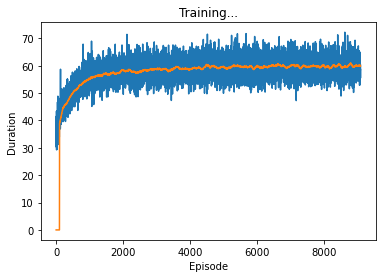

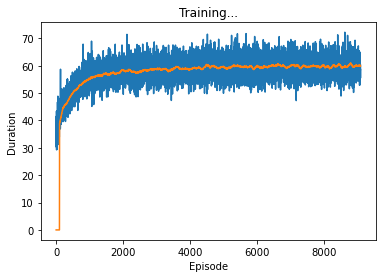

Current_train_num :  6003 Accuracy :  0.8114276195235716
F1 0.5466186474589836
683 536 597
train Current_train_num :  23995 Accuracy :  0.8050843925817879
F1 0.5146295912014941
2480 1802 2876
Current_train_num :  9109 LOSS :  -0.21185822784900665
0.006158448755741119
Current_train_num :  9119 LOSS :  -0.06972523778676987
0.022250555455684662
Current_train_num :  9129 LOSS :  -0.13511739671230316
0.002395340008661151
Current_train_num :  9139 LOSS :  -0.013227235525846481
0.005988832097500563
Current_train_num :  9149 LOSS :  -0.06977926194667816
0.014712724834680557
Current_train_num :  9159 LOSS :  -0.08729510009288788
0.002484292024746537
Current_train_num :  9169 LOSS :  -0.01929399184882641
0.005468669347465038
Current_train_num :  9179 LOSS :  -0.05208486691117287
0.003206095192581415
Current_train_num :  9189 LOSS :  -0.07253862172365189
0.0019610831514000893
Current_train_num :  9199 LOSS :  -0.10330956429243088
0.011759930290281773


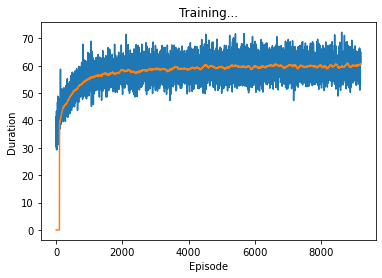

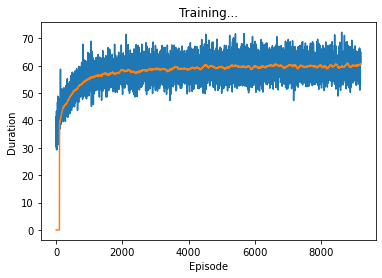

Current_train_num :  6003 Accuracy :  0.8114276195235716
F1 0.5466186474589836
683 536 597
train Current_train_num :  23995 Accuracy :  0.8051260679308189
F1 0.514682992632562
2480 1801 2876
Current_train_num :  9209 LOSS :  -0.17949910461902618
0.0169089213013649
Current_train_num :  9219 LOSS :  -0.20945855975151062
-0.0030472625512629747
Current_train_num :  9229 LOSS :  -0.09344768524169922
0.002077289391309023
Current_train_num :  9239 LOSS :  -0.2079886943101883
-0.001971804304048419
Current_train_num :  9249 LOSS :  -0.13277246057987213
0.0057595595717430115
Current_train_num :  9259 LOSS :  -0.07512494176626205
0.003021122654899955
Current_train_num :  9269 LOSS :  -0.05227335914969444
0.016807660460472107
Current_train_num :  9279 LOSS :  -0.14596331119537354
0.006734895519912243
Current_train_num :  9289 LOSS :  -0.02462080307304859
0.004554173443466425
Current_train_num :  9299 LOSS :  -0.1278453916311264
0.0028846319764852524


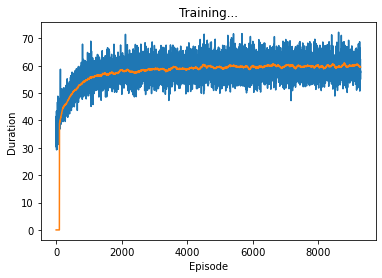

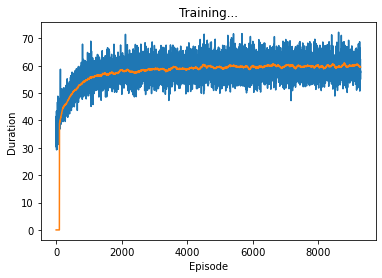

Current_train_num :  6003 Accuracy :  0.8110944527736131
F1 0.5458183273309324
682 537 598
train Current_train_num :  23995 Accuracy :  0.8049176911856637
F1 0.5149191877331123
2485 1811 2871
Current_train_num :  9309 LOSS :  -0.0032718288712203503
0.006916999351233244
Current_train_num :  9319 LOSS :  -0.2664147615432739
-0.0013575716875493526
Current_train_num :  9329 LOSS :  -0.2432422786951065
0.0014177080010995269
Current_train_num :  9339 LOSS :  -0.06320326775312424
0.004664184059947729
Current_train_num :  9349 LOSS :  -0.026211446151137352
0.0032163343857973814
Current_train_num :  9359 LOSS :  -0.05018463358283043
0.008530533872544765
Current_train_num :  9369 LOSS :  0.0018400797853246331
0.022699464112520218
Current_train_num :  9379 LOSS :  -0.05955834314227104
0.008727768436074257
Current_train_num :  9389 LOSS :  -0.1531175971031189
0.00509383762255311
Current_train_num :  9399 LOSS :  -0.12685982882976532
0.0031612517777830362


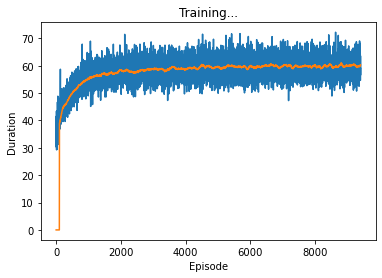

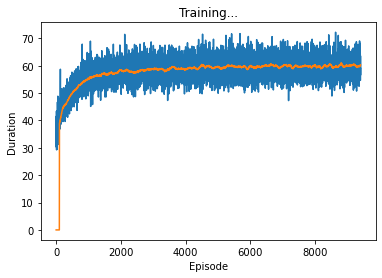

Current_train_num :  6003 Accuracy :  0.8112610361485924
F1 0.5460368294635709
682 536 598
train Current_train_num :  23995 Accuracy :  0.8048760158366326
F1 0.5147653092943736
2484 1811 2872
Current_train_num :  9409 LOSS :  -0.2050675004720688
0.0032099124509841204
Current_train_num :  9419 LOSS :  -0.18760652840137482
0.0065937046892941
Current_train_num :  9429 LOSS :  -0.07988914102315903
0.00827842392027378
Current_train_num :  9439 LOSS :  -0.12335345894098282
0.00631748465821147
Current_train_num :  9449 LOSS :  -0.02943320944905281
0.007184147834777832
Current_train_num :  9459 LOSS :  -0.44958698749542236
-0.002402252983301878
Current_train_num :  9469 LOSS :  -0.07187892496585846
0.0069839539937675
Current_train_num :  9479 LOSS :  -0.1640011966228485
0.003402938600629568
Current_train_num :  9489 LOSS :  -0.20684154331684113
-0.001267124549485743
Current_train_num :  9499 LOSS :  -0.2054785192012787
0.006145252380520105


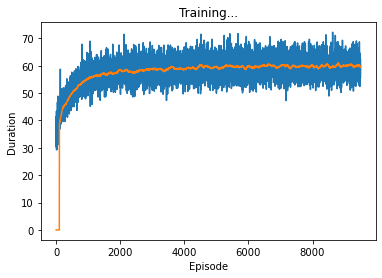

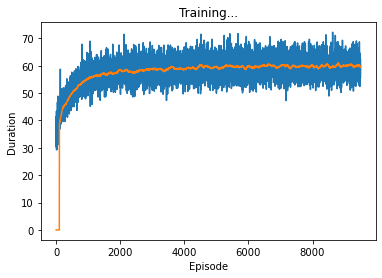

Current_train_num :  6003 Accuracy :  0.8112610361485924
F1 0.5460368294635709
682 536 598
train Current_train_num :  23995 Accuracy :  0.8049593665346947
F1 0.5149725417055228
2485 1810 2871
Current_train_num :  9509 LOSS :  -0.13662350177764893
0.005968136712908745
Current_train_num :  9519 LOSS :  -0.11192356795072556
0.013411328196525574
Current_train_num :  9529 LOSS :  -0.2641400992870331
-0.0008192660752683878
Current_train_num :  9539 LOSS :  -0.05258862301707268
0.0030261471401900053
Current_train_num :  9549 LOSS :  -0.05537071451544762
0.010012375190854073
Current_train_num :  9559 LOSS :  -0.08332560956478119
0.019141750410199165
Current_train_num :  9569 LOSS :  -0.15436513721942902
0.0013569354778155684
Current_train_num :  9579 LOSS :  -0.09411463141441345
0.007875015027821064
Current_train_num :  9589 LOSS :  -0.19237393140792847
0.0002498668909538537
Current_train_num :  9599 LOSS :  -0.07928057760000229
0.004371714312583208


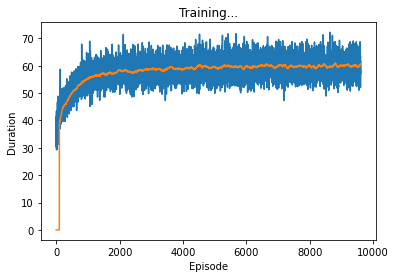

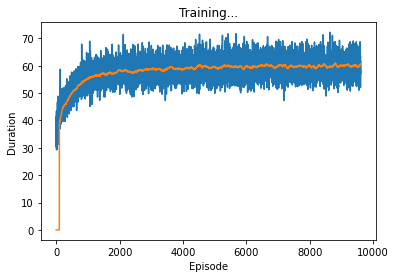

Current_train_num :  6003 Accuracy :  0.8114276195235716
F1 0.5462555066079295
682 535 598
train Current_train_num :  23995 Accuracy :  0.8050843925817879
F1 0.5149315636665284
2483 1805 2873
Current_train_num :  9609 LOSS :  -0.14282259345054626
0.0038986247964203358
Current_train_num :  9619 LOSS :  -0.05914410948753357
0.005315531510859728
Current_train_num :  9629 LOSS :  -0.12054500728845596
0.004921351559460163
Current_train_num :  9639 LOSS :  -0.062439341098070145
0.03315909951925278
Current_train_num :  9649 LOSS :  -0.05760644003748894
0.004215987399220467
Current_train_num :  9659 LOSS :  -0.13368995487689972
0.010709770023822784
Current_train_num :  9669 LOSS :  -0.22233261168003082
0.007111560087651014
Current_train_num :  9679 LOSS :  -0.05353270471096039
0.0031181229278445244
Current_train_num :  9689 LOSS :  -0.1707693338394165
0.002643493004143238
Current_train_num :  9699 LOSS :  -0.047259241342544556
0.0020419899374246597


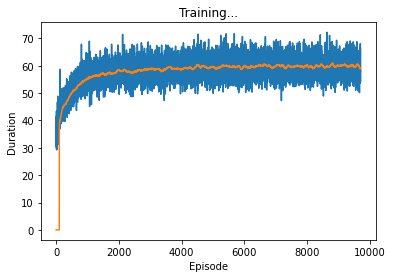

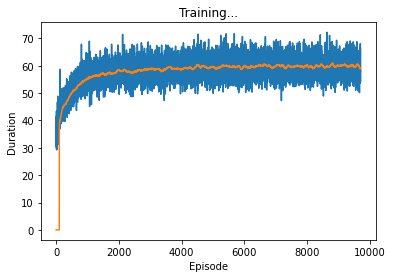

Current_train_num :  6003 Accuracy :  0.8120939530234883
F1 0.547131969514641
682 531 598
9699
train Current_train_num :  23995 Accuracy :  0.8055844967701604
F1 0.5154724818276221
2482 1792 2874
Current_train_num :  9709 LOSS :  -0.10175830870866776
0.003675583517178893
Current_train_num :  9719 LOSS :  -0.02012997679412365
0.0023664075415581465
Current_train_num :  9729 LOSS :  -0.12156285345554352
0.01262515690177679
Current_train_num :  9739 LOSS :  -0.2453654557466507
0.00019235631043557078
Current_train_num :  9749 LOSS :  -0.25208958983421326
0.0018999141175299883
Current_train_num :  9759 LOSS :  -0.09988196939229965
0.010678112506866455
Current_train_num :  9769 LOSS :  -0.2889329791069031
-0.0008172672241926193
Current_train_num :  9779 LOSS :  -0.026494281366467476
0.006751867011189461
Current_train_num :  9789 LOSS :  -0.1242917999625206
0.005905759520828724
Current_train_num :  9799 LOSS :  -0.12012717872858047
0.01253206841647625


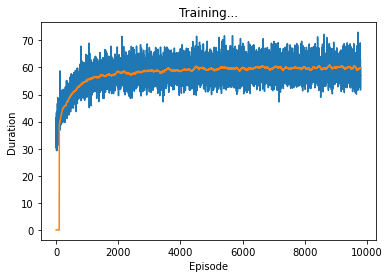

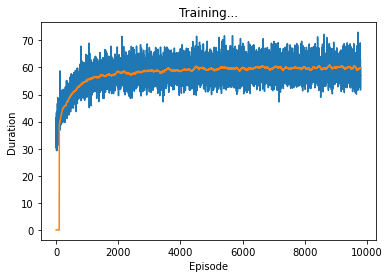

Current_train_num :  6003 Accuracy :  0.8117607862735299
F1 0.5470564677613136
683 534 597
train Current_train_num :  23995 Accuracy :  0.8054177953740362
F1 0.5155601659751037
2485 1799 2871
Current_train_num :  9809 LOSS :  -0.024562397971749306
0.009287223219871521
Current_train_num :  9819 LOSS :  -0.16562604904174805
0.012922179885208607
Current_train_num :  9829 LOSS :  -0.10438180714845657
0.002642487408593297
Current_train_num :  9839 LOSS :  -0.11464087665081024
0.0026085006538778543
Current_train_num :  9849 LOSS :  -0.211818128824234
-0.0003818473487626761
Current_train_num :  9859 LOSS :  -0.3955448269844055
0.0020391528960317373
Current_train_num :  9869 LOSS :  -0.13198119401931763
0.004814173094928265
Current_train_num :  9879 LOSS :  -0.09412147104740143
0.002466997830197215
Current_train_num :  9889 LOSS :  -0.11655299365520477
0.027674416080117226
Current_train_num :  9899 LOSS :  -0.06918720155954361
0.007467427756637335


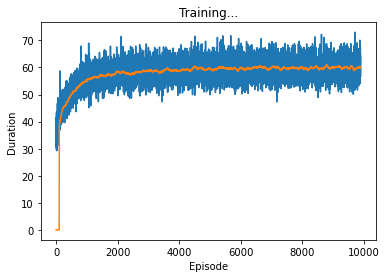

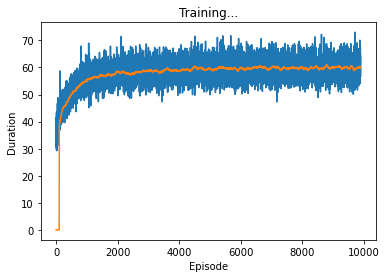

Current_train_num :  6003 Accuracy :  0.8115942028985508
F1 0.5468374699759808
683 535 597
train Current_train_num :  23995 Accuracy :  0.8053344446759741
F1 0.5155537121526338
2486 1802 2870
Current_train_num :  9909 LOSS :  -0.005170862656086683
0.012072554789483547
Current_train_num :  9919 LOSS :  -0.011767224408686161
0.00998601596802473
Current_train_num :  9929 LOSS :  -0.017996935173869133
0.004854565020650625
Current_train_num :  9939 LOSS :  -0.05657808482646942
0.0017356723546981812
Current_train_num :  9949 LOSS :  -0.01413632556796074
0.026453733444213867
Current_train_num :  9959 LOSS :  0.00487373024225235
0.013068031519651413
Current_train_num :  9969 LOSS :  -0.11253587901592255
0.011633865535259247
Current_train_num :  9979 LOSS :  -0.015340572223067284
0.002331394702196121
Current_train_num :  9989 LOSS :  -0.05028499290347099
0.00950094498693943
Current_train_num :  9999 LOSS :  -0.14891234040260315
0.01542937196791172


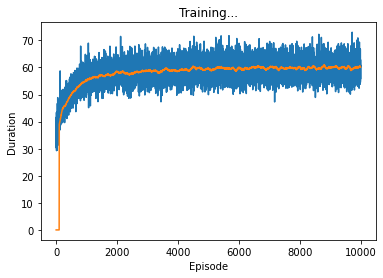

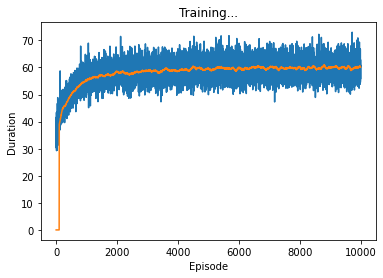

Current_train_num :  6003 Accuracy :  0.8095952023988006
F1 0.546031746031746
688 552 592
train Current_train_num :  23995 Accuracy :  0.8049176911856637
F1 0.5177173465183353
2513 1839 2843
Current_train_num :  10009 LOSS :  -0.06423644721508026
0.00610246742144227
Current_train_num :  10019 LOSS :  -0.006120352540165186
0.019857600331306458
Current_train_num :  10029 LOSS :  -0.11223186552524567
0.003759001148864627
Current_train_num :  10039 LOSS :  -0.05770871415734291
0.012650743126869202
Current_train_num :  10049 LOSS :  -0.1389712542295456
0.017160972580313683
Current_train_num :  10059 LOSS :  -0.2827438712120056
0.0029794310685247183
Current_train_num :  10069 LOSS :  -0.3036669194698334
0.0005910441395826638
Current_train_num :  10079 LOSS :  -0.13814868032932281
0.0033634600695222616
Current_train_num :  10089 LOSS :  -0.11513008177280426
0.0049720206297934055
Current_train_num :  10099 LOSS :  -0.058004144579172134
0.020439503714442253


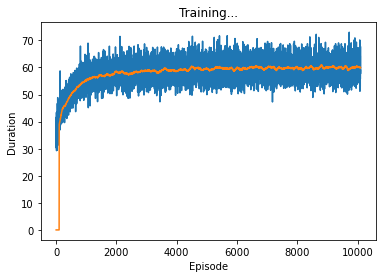

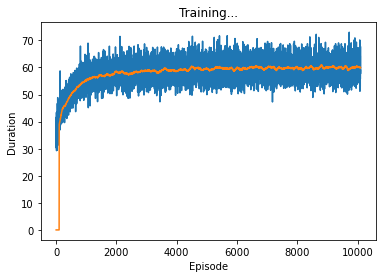

Current_train_num :  6003 Accuracy :  0.8089288688988839
F1 0.5451664025356577
688 556 592
train Current_train_num :  23995 Accuracy :  0.8047509897895395
F1 0.5176034589252625
2514 1844 2842
Current_train_num :  10109 LOSS :  -0.11166848242282867
0.001984753180295229
Current_train_num :  10119 LOSS :  -0.049716535955667496
0.005465315189212561
Current_train_num :  10129 LOSS :  -0.10458383709192276
0.018732376396656036
Current_train_num :  10139 LOSS :  -0.009480892680585384
0.019235197454690933
Current_train_num :  10149 LOSS :  -0.14356324076652527
-0.0008186366176232696
Current_train_num :  10159 LOSS :  -0.02124975062906742
0.015291466377675533
Current_train_num :  10169 LOSS :  -0.1628476232290268
-0.00017111595661845058
Current_train_num :  10179 LOSS :  -0.05711279436945915
0.006654250435531139
Current_train_num :  10189 LOSS :  -0.1785632222890854
0.006101150996983051
Current_train_num :  10199 LOSS :  -0.11498116701841354
0.008824729360640049


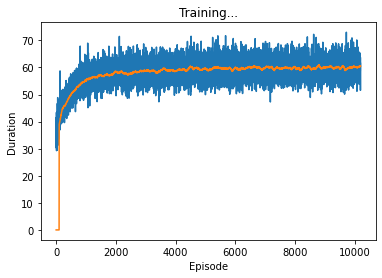

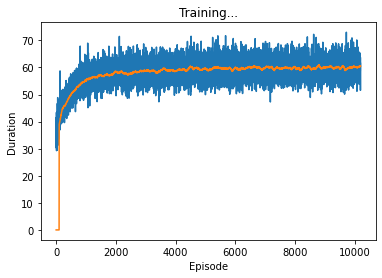

Current_train_num :  6003 Accuracy :  0.8089288688988839
F1 0.5451664025356577
688 556 592
train Current_train_num :  23995 Accuracy :  0.8047509897895395
F1 0.5176034589252625
2514 1844 2842
Current_train_num :  10209 LOSS :  -0.1994635909795761
0.013861844316124916
Current_train_num :  10219 LOSS :  -0.17979882657527924
0.0034113568253815174
Current_train_num :  10229 LOSS :  -0.2448713630437851
0.002785485703498125
Current_train_num :  10239 LOSS :  -0.24365893006324768
0.010163204744458199
Current_train_num :  10249 LOSS :  -0.07254069298505783
0.005223894026130438
Current_train_num :  10259 LOSS :  -0.08845140039920807
0.006894010119140148
Current_train_num :  10269 LOSS :  -0.14456807076931
0.00037077339948154986
Current_train_num :  10279 LOSS :  -0.01935253106057644
0.002618771977722645
Current_train_num :  10289 LOSS :  -0.0774763748049736
0.002377866068854928
Current_train_num :  10299 LOSS :  -0.059210456907749176
0.002751333871856332


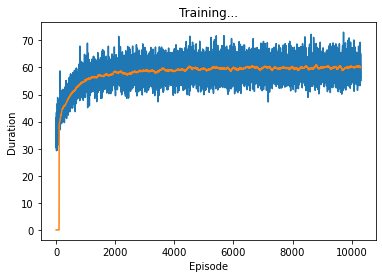

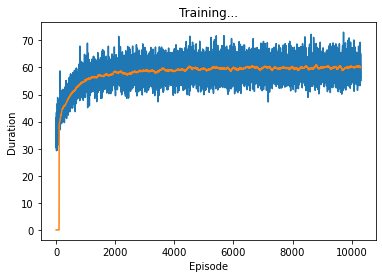

Current_train_num :  6003 Accuracy :  0.8097617857737798
F1 0.5462485113140135
688 551 592
train Current_train_num :  23995 Accuracy :  0.8049176911856637
F1 0.5177173465183353
2513 1839 2843
Current_train_num :  10309 LOSS :  -0.27785465121269226
0.007969033904373646
Current_train_num :  10319 LOSS :  -0.016615400090813637
0.00954465288668871
Current_train_num :  10329 LOSS :  -0.2015700489282608
0.019462769851088524
Current_train_num :  10339 LOSS :  -0.18227039277553558
0.022244330495595932
Current_train_num :  10349 LOSS :  -0.10743541270494461
0.01620648428797722
Current_train_num :  10359 LOSS :  -0.16810652613639832
0.0005803894018754363
Current_train_num :  10369 LOSS :  -0.11268100142478943
0.012559604831039906
Current_train_num :  10379 LOSS :  -0.11962738633155823
0.014781178906559944
Current_train_num :  10389 LOSS :  -0.05145708844065666
0.008043025620281696
Current_train_num :  10399 LOSS :  -0.11905421316623688
0.012888048775494099


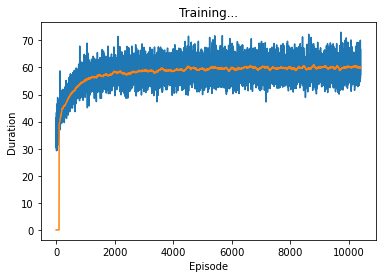

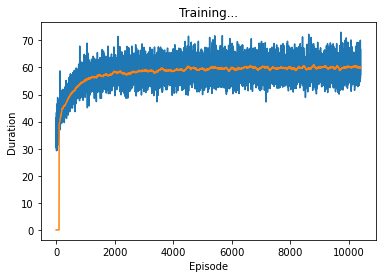

Current_train_num :  6003 Accuracy :  0.8105947026486756
F1 0.54733492442323
688 546 592
10399
train Current_train_num :  23995 Accuracy :  0.8049176911856637
F1 0.5171204620462047
2507 1833 2849
Current_train_num :  10409 LOSS :  -0.018457641825079918
0.005994496401399374
Current_train_num :  10419 LOSS :  -0.1627427190542221
0.006665234919637442
Current_train_num :  10429 LOSS :  -0.08220592141151428
0.0013267829781398177
Current_train_num :  10439 LOSS :  -0.04876409471035004
0.011595428921282291
Current_train_num :  10449 LOSS :  -0.05287456512451172
0.015282431617379189
Current_train_num :  10459 LOSS :  -0.14851123094558716
0.010731193237006664
Current_train_num :  10469 LOSS :  -0.2323075532913208
0.0034230246674269438
Current_train_num :  10479 LOSS :  -0.39640289545059204
-0.0012754808412864804
Current_train_num :  10489 LOSS :  -0.175639346241951
0.00934798177331686
Current_train_num :  10499 LOSS :  -0.2062724530696869
0.0027752763126045465


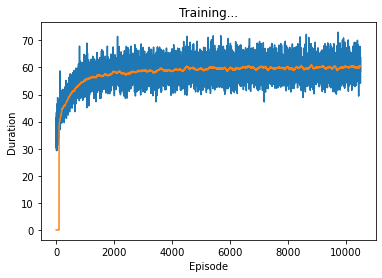

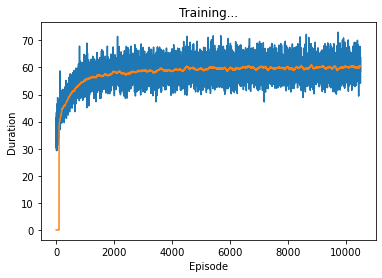

Current_train_num :  6003 Accuracy :  0.8104281192736965
F1 0.5467568643056109
687 546 593
train Current_train_num :  23995 Accuracy :  0.8047093144405084
F1 0.5161556725508414
2500 1831 2856
Current_train_num :  10509 LOSS :  -0.05033910274505615
0.009509474970400333
Current_train_num :  10519 LOSS :  -0.09181518107652664
0.007132270839065313
Current_train_num :  10529 LOSS :  -0.195680633187294
0.0027841797564178705
Current_train_num :  10539 LOSS :  -0.007635229267179966
0.005297923926264048
Current_train_num :  10549 LOSS :  -0.06772017478942871
0.007210967130959034
Current_train_num :  10559 LOSS :  -0.12198269367218018
0.010264502838253975
Current_train_num :  10569 LOSS :  -0.0565093457698822
0.0015059866709634662
Current_train_num :  10579 LOSS :  -0.040576495230197906
0.01297096349298954
Current_train_num :  10589 LOSS :  -0.017876464873552322
0.019438890740275383
Current_train_num :  10599 LOSS :  -0.05000153183937073
0.006482887547463179


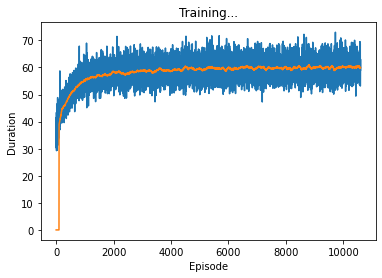

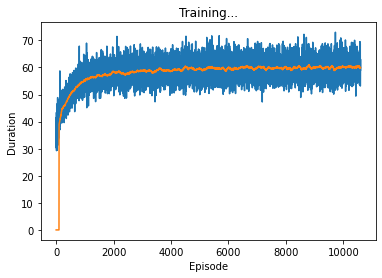

Current_train_num :  6003 Accuracy :  0.810927869398634
F1 0.5470494417862839
686 542 594
train Current_train_num :  23995 Accuracy :  0.8048343404876016
F1 0.5161157024793388
2498 1826 2858
Current_train_num :  10609 LOSS :  -0.03845334053039551
0.007900508120656013
Current_train_num :  10619 LOSS :  -0.07174791395664215
0.005807450506836176
Current_train_num :  10629 LOSS :  -0.09039784967899323
0.011144489049911499
Current_train_num :  10639 LOSS :  -0.14935053884983063
0.0055581629276275635
Current_train_num :  10649 LOSS :  -0.14818504452705383
0.007016728166490793
Current_train_num :  10659 LOSS :  -0.18204550445079803
0.001995239406824112
Current_train_num :  10669 LOSS :  -0.016902605071663857
0.0024914932437241077
Current_train_num :  10679 LOSS :  -0.10814082622528076
0.004269715398550034
Current_train_num :  10689 LOSS :  -0.026812538504600525
0.010545567609369755
Current_train_num :  10699 LOSS :  -0.19678127765655518
0.00831804983317852


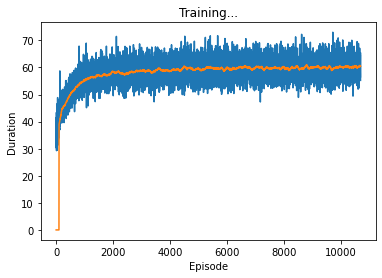

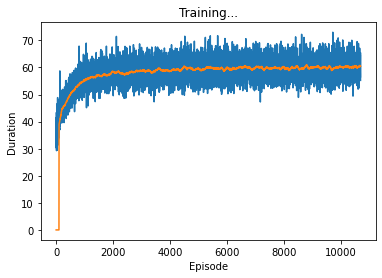

Current_train_num :  6003 Accuracy :  0.8105947026486756
F1 0.5469745222929936
687 545 593
train Current_train_num :  23995 Accuracy :  0.8046676390914774
F1 0.5160024778030147
2499 1831 2857
Current_train_num :  10709 LOSS :  -0.2675133943557739
0.0009317048243246973
Current_train_num :  10719 LOSS :  -0.3005523979663849
0.010008926503360271
Current_train_num :  10729 LOSS :  -0.055563922971487045
0.0012011168291792274
Current_train_num :  10739 LOSS :  -0.10899578034877777
0.013300950638949871
Current_train_num :  10749 LOSS :  -0.0788886770606041
0.005419856868684292
Current_train_num :  10759 LOSS :  -0.04366845265030861
0.0038504190742969513
Current_train_num :  10769 LOSS :  -0.12133345752954483
0.0030982617754489183
Current_train_num :  10779 LOSS :  -0.15495972335338593
0.010171559639275074
Current_train_num :  10789 LOSS :  -0.04270172119140625
0.0023757722228765488
Current_train_num :  10799 LOSS :  -0.028119979426264763
0.004048849456012249


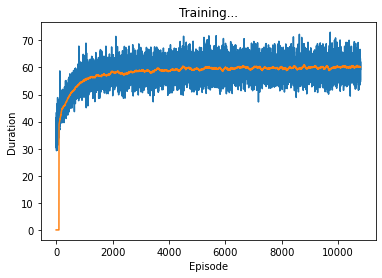

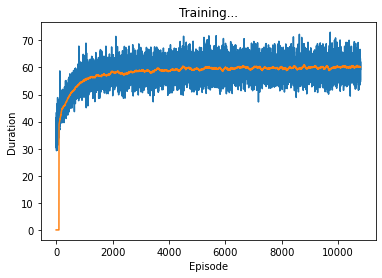

Current_train_num :  6003 Accuracy :  0.810927869398634
F1 0.5466879489225858
685 541 595
train Current_train_num :  23995 Accuracy :  0.8048343404876016
F1 0.5160157057243232
2497 1825 2859
Current_train_num :  10809 LOSS :  -0.24806414544582367
0.005801888648420572
Current_train_num :  10819 LOSS :  -0.053275320678949356
0.012835218571126461
Current_train_num :  10829 LOSS :  -0.16620680689811707
0.011621275916695595
Current_train_num :  10839 LOSS :  -0.18781264126300812
0.00745140016078949
Current_train_num :  10849 LOSS :  -0.0968833640217781
0.0040428475476801395
Current_train_num :  10859 LOSS :  -0.34220394492149353
-0.002714392263442278
Current_train_num :  10869 LOSS :  -0.06856140494346619
0.006022000219672918
Current_train_num :  10879 LOSS :  -0.2865828573703766
0.005912233144044876
Current_train_num :  10889 LOSS :  -0.07449385523796082
0.009222102351486683
Current_train_num :  10899 LOSS :  -0.04637056589126587
0.006321660242974758


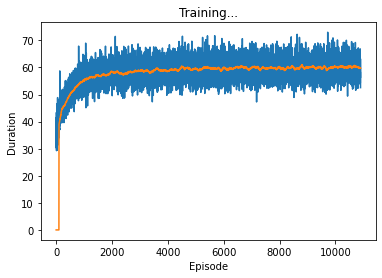

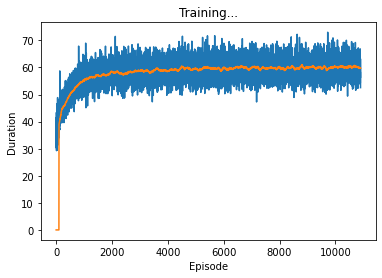

Current_train_num :  6003 Accuracy :  0.8112610361485924
F1 0.5467625899280576
684 538 596
train Current_train_num :  23995 Accuracy :  0.8048760158366326
F1 0.515968992248062
2496 1823 2860
Current_train_num :  10909 LOSS :  -0.11403873562812805
0.004449253901839256
Current_train_num :  10919 LOSS :  -0.012693796306848526
0.022251805290579796
Current_train_num :  10929 LOSS :  -0.018670396879315376
0.008747098036110401
Current_train_num :  10939 LOSS :  -0.1085471659898758
0.015292440541088581
Current_train_num :  10949 LOSS :  -0.038806285709142685
0.003591535845771432
Current_train_num :  10959 LOSS :  -0.09985238313674927
0.006251442711800337
Current_train_num :  10969 LOSS :  -0.07840804010629654
0.004565437324345112
Current_train_num :  10979 LOSS :  -0.2231549322605133
0.014871438965201378
Current_train_num :  10989 LOSS :  -0.026865201070904732
0.004998199176043272
Current_train_num :  10999 LOSS :  -0.17108851671218872
0.01317664235830307


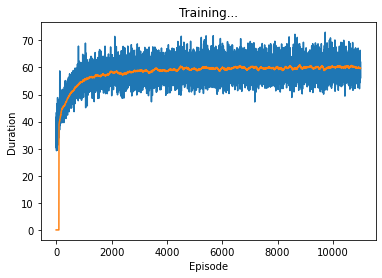

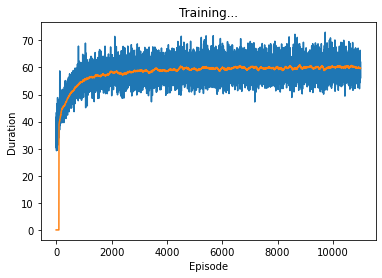

Current_train_num :  6003 Accuracy :  0.8110944527736131
F1 0.5465441470235717
684 539 596
train Current_train_num :  23995 Accuracy :  0.8049176911856637
F1 0.5161223646134766
2497 1823 2859
Current_train_num :  11009 LOSS :  -0.02346959337592125
0.01890305057168007
Current_train_num :  11019 LOSS :  -0.1709209531545639
0.006341562140733004
Current_train_num :  11029 LOSS :  -0.19851139187812805
0.012867484241724014
Current_train_num :  11039 LOSS :  -0.009618244133889675
0.012302045710384846
Current_train_num :  11049 LOSS :  -0.15022757649421692
0.007522182539105415
Current_train_num :  11059 LOSS :  -0.17469917237758636
0.006965459790080786
Current_train_num :  11069 LOSS :  -0.10364654660224915
0.001882918761111796
Current_train_num :  11079 LOSS :  -0.08868326246738434
0.012890619225800037
Current_train_num :  11089 LOSS :  -0.14159755408763885
0.0011669594096019864
Current_train_num :  11099 LOSS :  -0.0581987127661705
0.0011964879231527448


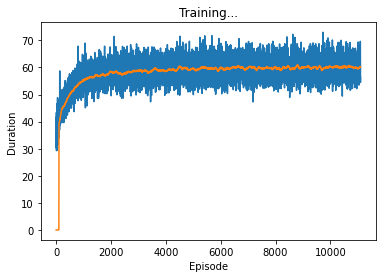

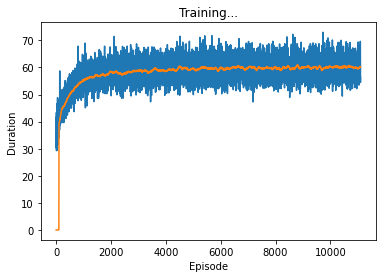

Current_train_num :  6003 Accuracy :  0.8110944527736131
F1 0.5472676505783806
686 541 594
train Current_train_num :  23995 Accuracy :  0.8047926651385705
F1 0.5159623928091746
2497 1826 2859
Current_train_num :  11109 LOSS :  -0.1393788903951645
0.006590064615011215
Current_train_num :  11119 LOSS :  -0.14670820534229279
0.0023114208597689867
Current_train_num :  11129 LOSS :  -0.1842305064201355
0.005952067673206329
Current_train_num :  11139 LOSS :  -0.1967182159423828
0.000995857291854918
Current_train_num :  11149 LOSS :  -0.11939393728971481
0.0021856953389942646
Current_train_num :  11159 LOSS :  -0.008132945746183395
0.01756923645734787
Current_train_num :  11169 LOSS :  -0.1604735553264618
0.005134159699082375
Current_train_num :  11179 LOSS :  -0.03675287589430809
0.00750358123332262
Current_train_num :  11189 LOSS :  -0.20751304924488068
0.00037320953560993075
Current_train_num :  11199 LOSS :  -0.1372818648815155
0.008177662268280983


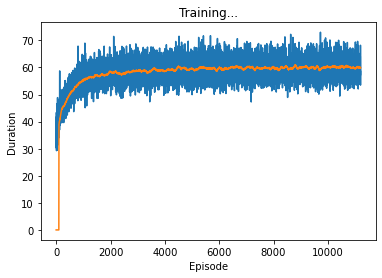

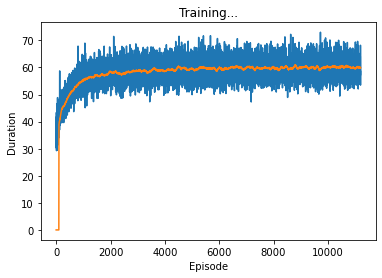

Current_train_num :  6003 Accuracy :  0.8105947026486756
F1 0.5469745222929936
687 545 593
train Current_train_num :  23995 Accuracy :  0.8047093144405084
F1 0.5161556725508414
2500 1831 2856
Current_train_num :  11209 LOSS :  -0.07443929463624954
0.007204481866210699
Current_train_num :  11219 LOSS :  -0.13273954391479492
0.012254968285560608
Current_train_num :  11229 LOSS :  -0.16281309723854065
0.0023499198723584414
Current_train_num :  11239 LOSS :  -0.20231221616268158
0.0020370022393763065
Current_train_num :  11249 LOSS :  -0.13591119647026062
0.0014746013330295682
Current_train_num :  11259 LOSS :  -0.07933732122182846
0.00816050823777914
Current_train_num :  11269 LOSS :  -0.17712384462356567
0.004798674490302801
Current_train_num :  11279 LOSS :  -0.0011616019764915109
0.003571784822270274
Current_train_num :  11289 LOSS :  -0.1343058943748474
0.011205300688743591
Current_train_num :  11299 LOSS :  -0.09873341023921967
0.012240340001881123


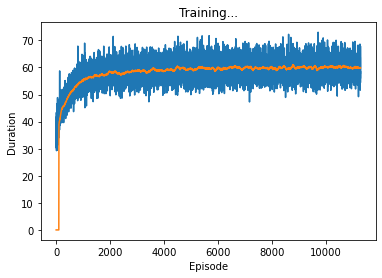

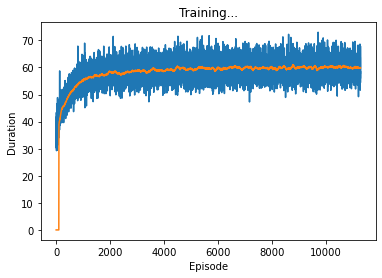

Current_train_num :  6003 Accuracy :  0.8107612860236548
F1 0.5471923536439666
687 544 593
train Current_train_num :  23995 Accuracy :  0.8048343404876016
F1 0.5162156579219169
2499 1827 2857
Current_train_num :  11309 LOSS :  -0.04412872716784477
0.006370923947542906
Current_train_num :  11319 LOSS :  -0.1626574844121933
0.0034702029079198837
Current_train_num :  11329 LOSS :  -0.10348540544509888
0.011778619140386581
Current_train_num :  11339 LOSS :  -0.17645421624183655
0.0005981518770568073
Current_train_num :  11349 LOSS :  -0.2842041850090027
-0.0005289174732752144
Current_train_num :  11359 LOSS :  -0.011712522245943546
0.0044405716471374035
Current_train_num :  11369 LOSS :  -0.2507907748222351
0.003932199906557798
Current_train_num :  11379 LOSS :  -0.10564570128917694
0.008271129801869392
Current_train_num :  11389 LOSS :  -0.05012653395533562
0.011250142939388752
Current_train_num :  11399 LOSS :  -0.11507605761289597
0.01625942997634411


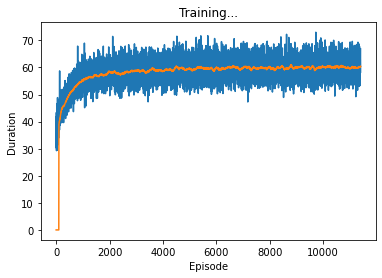

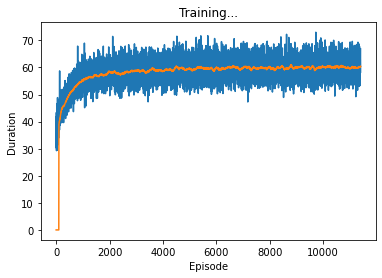

Current_train_num :  6003 Accuracy :  0.8110944527736131
F1 0.5472676505783806
686 541 594
train Current_train_num :  23995 Accuracy :  0.8047926651385705
F1 0.5159623928091746
2497 1826 2859
Current_train_num :  11409 LOSS :  -0.2626101076602936
0.01346828043460846
Current_train_num :  11419 LOSS :  -0.06438680738210678
0.005859332624822855
Current_train_num :  11429 LOSS :  -0.11110687255859375
0.004140143282711506
Current_train_num :  11439 LOSS :  -0.07658408582210541
0.013497889041900635
Current_train_num :  11449 LOSS :  -0.0917079746723175
0.0020251600071787834
Current_train_num :  11459 LOSS :  -0.1216735690832138
0.002229562494903803
Current_train_num :  11469 LOSS :  -0.09702504426240921
0.0015301472740247846
Current_train_num :  11479 LOSS :  -0.10008588433265686
0.005987612996250391
Current_train_num :  11489 LOSS :  -0.07994582504034042
0.006420743651688099
Current_train_num :  11499 LOSS :  -0.041404031217098236
0.008350863121449947


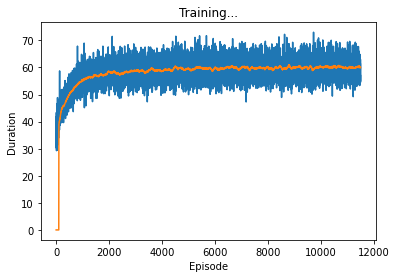

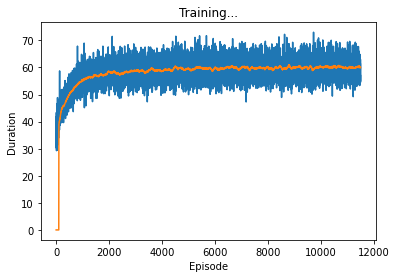

Current_train_num :  6003 Accuracy :  0.8104281192736965
F1 0.5467568643056109
687 546 593
train Current_train_num :  23995 Accuracy :  0.8047509897895395
F1 0.5164086687306502
2502 1832 2854
Current_train_num :  11509 LOSS :  -0.23057542741298676
0.0074607753194868565
Current_train_num :  11519 LOSS :  -0.09605301916599274
0.008110246621072292
Current_train_num :  11529 LOSS :  0.0038940950762480497
0.009710228070616722
Current_train_num :  11539 LOSS :  -0.1392025202512741
0.007594938389956951
Current_train_num :  11549 LOSS :  -0.19212742149829865
0.0007356398273259401
Current_train_num :  11559 LOSS :  -0.08593059331178665
0.0019795310217887163
Current_train_num :  11569 LOSS :  -0.08996565639972687
0.009155063889920712
Current_train_num :  11579 LOSS :  -0.08496230095624924
0.004831601399928331
Current_train_num :  11589 LOSS :  -0.08288510888814926
0.0011269933311268687
Current_train_num :  11599 LOSS :  -0.01844954304397106
0.013111270032823086


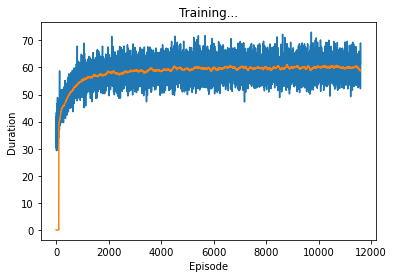

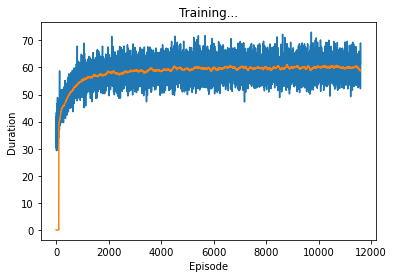

Current_train_num :  6003 Accuracy :  0.8107612860236548
F1 0.5468314069350338
686 543 594
train Current_train_num :  23995 Accuracy :  0.8047509897895395
F1 0.5161090458488228
2499 1829 2857
Current_train_num :  11609 LOSS :  -0.07495912164449692
0.012398013845086098
Current_train_num :  11619 LOSS :  -0.02881128154695034
0.023399831727147102
Current_train_num :  11629 LOSS :  -0.011625370942056179
0.03267578035593033
Current_train_num :  11639 LOSS :  -0.18352825939655304
0.0061759729869663715
Current_train_num :  11649 LOSS :  -0.11002454161643982
0.00014448509318754077
Current_train_num :  11659 LOSS :  -0.2510921061038971
0.0018348549492657185
Current_train_num :  11669 LOSS :  -0.07441308349370956
0.0021502620074898005
Current_train_num :  11679 LOSS :  -0.08556850254535675
0.01256487611681223
Current_train_num :  11689 LOSS :  -0.03535774350166321
0.003271278226748109
Current_train_num :  11699 LOSS :  -0.05453082174062729
0.0025781344156712294


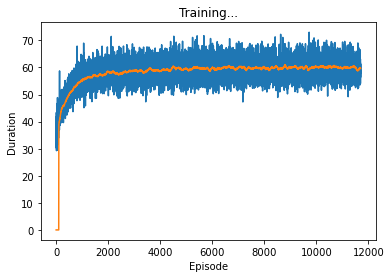

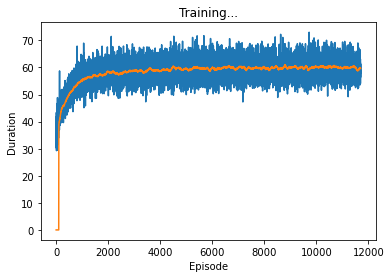

Current_train_num :  6003 Accuracy :  0.8104281192736965
F1 0.5467568643056109
687 546 593
train Current_train_num :  23995 Accuracy :  0.8046676390914774
F1 0.5163021048287247
2502 1834 2854
Current_train_num :  11709 LOSS :  -0.20183627307415009
0.008939957246184349
Current_train_num :  11719 LOSS :  -0.045739565044641495
0.0049771592020988464
Current_train_num :  11729 LOSS :  -0.044131163507699966
0.003538132179528475
Current_train_num :  11739 LOSS :  -0.15201330184936523
0.0009331033215858042
Current_train_num :  11749 LOSS :  -0.1637841910123825
0.0006220659124664962
Current_train_num :  11759 LOSS :  -0.12722206115722656
0.011235418729484081
Current_train_num :  11769 LOSS :  -0.1283741593360901
0.0075553953647613525
Current_train_num :  11779 LOSS :  -0.03188382461667061
0.0034429163206368685
Current_train_num :  11789 LOSS :  -0.12647444009780884
0.018435034900903702
Current_train_num :  11799 LOSS :  -0.049539536237716675
0.013157862238585949


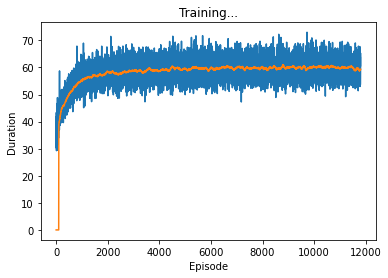

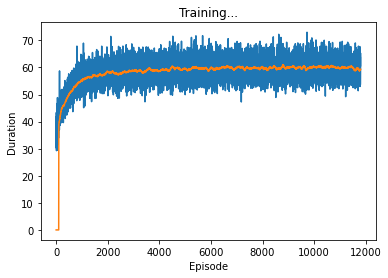

Current_train_num :  6003 Accuracy :  0.810927869398634
F1 0.547410358565737
687 543 593
11799
train Current_train_num :  23995 Accuracy :  0.8047093144405084
F1 0.5160557563242127
2499 1830 2857
Current_train_num :  11809 LOSS :  -0.14547614753246307
0.01233004778623581
Current_train_num :  11819 LOSS :  -0.04138736426830292
0.010637453757226467
Current_train_num :  11829 LOSS :  -0.08048249781131744
0.0014658391010016203
Current_train_num :  11839 LOSS :  -0.06840063631534576
0.0026076422072947025
Current_train_num :  11849 LOSS :  -0.07632535696029663
0.01899128593504429
Current_train_num :  11859 LOSS :  -0.01313807163387537
0.00910666398704052
Current_train_num :  11869 LOSS :  -0.13605913519859314
0.007827157154679298
Current_train_num :  11879 LOSS :  -0.04486755281686783
0.02156485803425312
Current_train_num :  11889 LOSS :  -0.2306056171655655
0.016278693452477455
Current_train_num :  11899 LOSS :  -0.24947254359722137
0.0011106812162324786


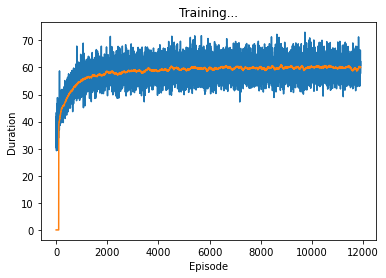

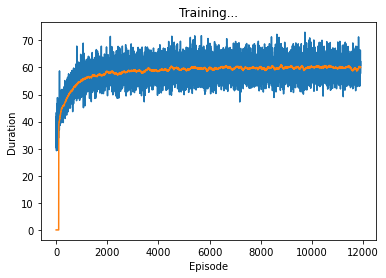

Current_train_num :  6003 Accuracy :  0.8107612860236548
F1 0.5471923536439666
687 544 593
train Current_train_num :  23995 Accuracy :  0.8046676390914774
F1 0.5161023947151114
2500 1832 2856
Current_train_num :  11909 LOSS :  -0.14457154273986816
0.006042764987796545
Current_train_num :  11919 LOSS :  -0.12304271757602692
0.0008907591691240668
Current_train_num :  11929 LOSS :  -0.057048920542001724
0.003013277892023325
Current_train_num :  11939 LOSS :  -0.05461415275931358
0.0022285464219748974
Current_train_num :  11949 LOSS :  -0.012956757098436356
0.00887881126254797
Current_train_num :  11959 LOSS :  -0.18597911298274994
0.00662474287673831
Current_train_num :  11969 LOSS :  -0.18920855224132538
0.0053815459832549095
Current_train_num :  11979 LOSS :  -0.14178591966629028
0.006224763114005327
Current_train_num :  11989 LOSS :  -0.13351833820343018
0.007944217883050442
Current_train_num :  11999 LOSS :  -0.1709393858909607
0.004831134807318449


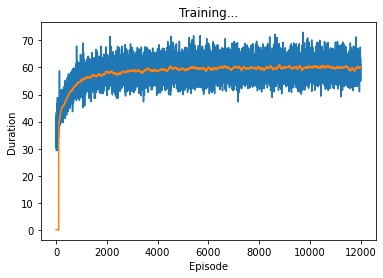

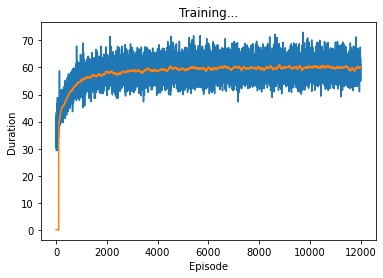

Current_train_num :  6003 Accuracy :  0.8115942028985508
F1 0.5482841181165203
687 539 593
11999
train Current_train_num :  23995 Accuracy :  0.8049176911856637
F1 0.5161223646134766
2497 1823 2859
Current_train_num :  12009 LOSS :  -0.24494808912277222
0.005453766789287329
Current_train_num :  12019 LOSS :  -0.15423297882080078
0.0011775702005252242
Current_train_num :  12029 LOSS :  -0.17597414553165436
0.0034111898858100176
Current_train_num :  12039 LOSS :  -0.02797076106071472
0.007503684144467115
Current_train_num :  12049 LOSS :  -0.1026594489812851
0.02072739601135254
Current_train_num :  12059 LOSS :  -0.12286508083343506
0.003032973036170006
Current_train_num :  12069 LOSS :  -0.07374724745750427
0.0012172356946393847
Current_train_num :  12079 LOSS :  -0.22686240077018738
-0.0005205800989642739
Current_train_num :  12089 LOSS :  -0.08447902649641037
0.0013904214138165116
Current_train_num :  12099 LOSS :  -0.06167503446340561
0.009978200308978558


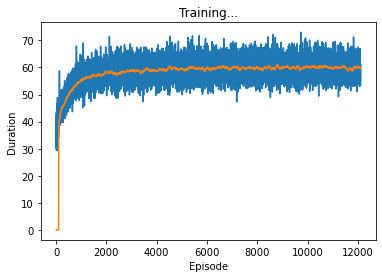

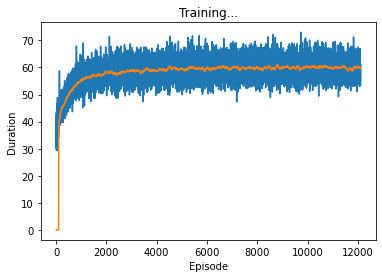

Current_train_num :  6003 Accuracy :  0.8114276195235716
F1 0.5469812075169932
684 537 596
train Current_train_num :  23995 Accuracy :  0.8050427172327568
F1 0.5158820486290739
2493 1816 2863
Current_train_num :  12109 LOSS :  -0.17514514923095703
0.002805552911013365
Current_train_num :  12119 LOSS :  -0.22591382265090942
0.00558291282504797
Current_train_num :  12129 LOSS :  -0.04101143032312393
0.000768383324611932
Current_train_num :  12139 LOSS :  -0.1413974165916443
0.0045488569885492325
Current_train_num :  12149 LOSS :  -0.011794713325798512
0.002932897536084056
Current_train_num :  12159 LOSS :  -0.03872716426849365
0.005442738067358732
Current_train_num :  12169 LOSS :  -0.1409965306520462
0.010023361071944237
Current_train_num :  12179 LOSS :  -0.1261720508337021
0.001276187365874648
Current_train_num :  12189 LOSS :  -0.16269424557685852
0.0014792938018217683
Current_train_num :  12199 LOSS :  -0.15898680686950684
0.0030647011008113623


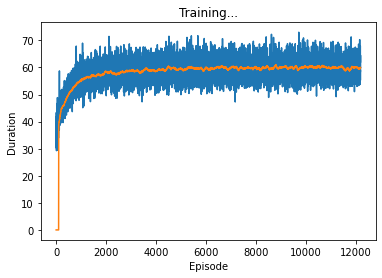

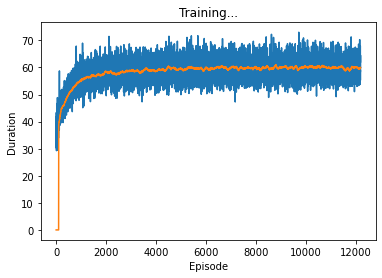

Current_train_num :  6003 Accuracy :  0.8114276195235716
F1 0.5473431881741909
685 538 595
train Current_train_num :  23995 Accuracy :  0.8049176911856637
F1 0.5158221302998965
2494 1820 2862
Current_train_num :  12209 LOSS :  -0.04163753241300583
0.031899429857730865
Current_train_num :  12219 LOSS :  -0.00843279529362917
0.0015954819973558187
Current_train_num :  12229 LOSS :  -0.15014508366584778
0.005761751905083656
Current_train_num :  12239 LOSS :  -0.07621560990810394
0.005394264589995146
Current_train_num :  12249 LOSS :  -0.29484525322914124
0.008539652451872826
Current_train_num :  12259 LOSS :  -0.09165795147418976
0.0013070333516225219
Current_train_num :  12269 LOSS :  -0.09823576360940933
0.00376174901612103
Current_train_num :  12279 LOSS :  -0.1097419261932373
0.012568616308271885
Current_train_num :  12289 LOSS :  -0.3421943187713623
-0.0027164712082594633
Current_train_num :  12299 LOSS :  -0.18513767421245575
0.010084345005452633


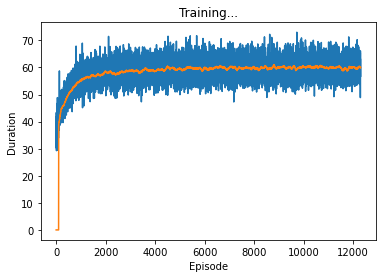

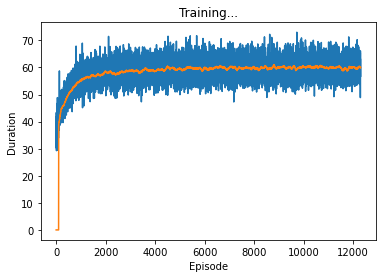

Current_train_num :  6003 Accuracy :  0.8114276195235716
F1 0.5473431881741909
685 538 595
train Current_train_num :  23995 Accuracy :  0.8049176911856637
F1 0.5158221302998965
2494 1820 2862
Current_train_num :  12309 LOSS :  -0.3591667711734772
-0.0010255076922476292
Current_train_num :  12319 LOSS :  -0.1384417712688446
0.013939122669398785
Current_train_num :  12329 LOSS :  -0.011379959061741829
0.011606714688241482
Current_train_num :  12339 LOSS :  -0.06802360713481903
0.0016048330580815673
Current_train_num :  12349 LOSS :  -0.19740556180477142
0.0063270279206335545
Current_train_num :  12359 LOSS :  -0.030786659568548203
0.004479529801756144
Current_train_num :  12369 LOSS :  -0.00823207851499319
0.005205892026424408
Current_train_num :  12379 LOSS :  -0.047332435846328735
0.006742115132510662
Current_train_num :  12389 LOSS :  -0.28126096725463867
-0.0029586029704660177
Current_train_num :  12399 LOSS :  -0.35861682891845703
0.007277344819158316


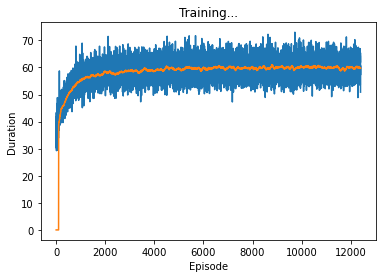

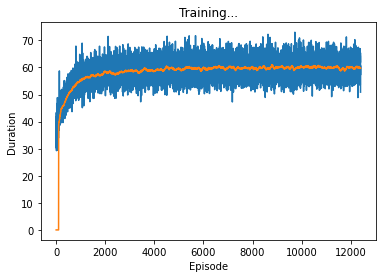

Current_train_num :  6003 Accuracy :  0.8114276195235716
F1 0.5473431881741909
685 538 595
train Current_train_num :  23995 Accuracy :  0.8049593665346947
F1 0.5158754783328162
2494 1819 2862
Current_train_num :  12409 LOSS :  -0.034096162766218185
0.004996920470148325
Current_train_num :  12419 LOSS :  -0.02824513055384159
0.008912871591746807
Current_train_num :  12429 LOSS :  -0.03840668871998787
0.002772165462374687
Current_train_num :  12439 LOSS :  -0.038034722208976746
0.007833612151443958
Current_train_num :  12449 LOSS :  -0.054430730640888214
0.012362576089799404
Current_train_num :  12459 LOSS :  -0.27384743094444275
0.0020320594776421785
Current_train_num :  12469 LOSS :  -0.15869106352329254
0.008181186392903328
Current_train_num :  12479 LOSS :  -0.12906944751739502
0.0011678801383823156
Current_train_num :  12489 LOSS :  -0.1585816591978073
0.0052825589664280415
Current_train_num :  12499 LOSS :  -0.0377909354865551
0.030839670449495316


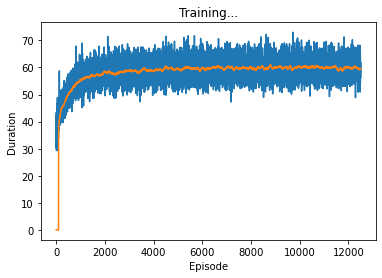

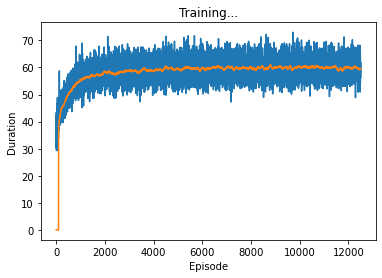

Current_train_num :  6003 Accuracy :  0.8114276195235716
F1 0.5473431881741909
685 538 595
train Current_train_num :  23995 Accuracy :  0.8049176911856637
F1 0.5159222497932175
2495 1821 2861
Current_train_num :  12509 LOSS :  -0.038774728775024414
0.004254835192114115
Current_train_num :  12519 LOSS :  -0.06980858743190765
0.00326437852345407
Current_train_num :  12529 LOSS :  -0.12531140446662903
0.0016832974506542087
Current_train_num :  12539 LOSS :  -0.05161692947149277
0.001483225729316473
Current_train_num :  12549 LOSS :  -0.14064109325408936
0.0025235009379684925
Current_train_num :  12559 LOSS :  -0.04781730845570564
0.010457208380103111
Current_train_num :  12569 LOSS :  -0.15437375009059906
-0.0005333043518476188
Current_train_num :  12579 LOSS :  -0.033098965883255005
0.0030814004130661488
Current_train_num :  12589 LOSS :  -0.10067598521709442
0.0014209217624738812
Current_train_num :  12599 LOSS :  -0.0553831048309803
0.0017917187651619315


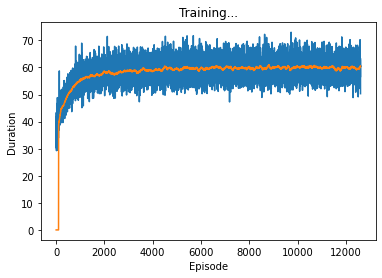

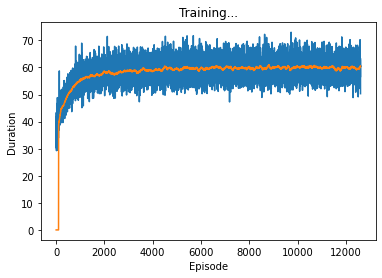

Current_train_num :  6003 Accuracy :  0.8114276195235716
F1 0.5473431881741909
685 538 595
train Current_train_num :  23995 Accuracy :  0.8049593665346947
F1 0.5158754783328162
2494 1819 2862
Current_train_num :  12609 LOSS :  -0.05536353960633278
0.00863809697329998
Current_train_num :  12619 LOSS :  -0.09230034798383713
0.02382531948387623
Current_train_num :  12629 LOSS :  -0.07984048128128052
0.0031222552061080933
Current_train_num :  12639 LOSS :  -0.15285414457321167
0.004025412257760763
Current_train_num :  12649 LOSS :  -0.18479110300540924
0.009001408703625202
Current_train_num :  12659 LOSS :  -0.1486268937587738
0.0005853031179867685
Current_train_num :  12669 LOSS :  -0.1743754893541336
0.005488645285367966
Current_train_num :  12679 LOSS :  -0.12018698453903198
0.00726346904411912
Current_train_num :  12689 LOSS :  -0.06241023167967796
0.0077528213150799274
Current_train_num :  12699 LOSS :  -0.10712193697690964
0.003916206303983927


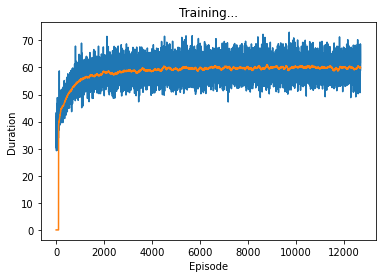

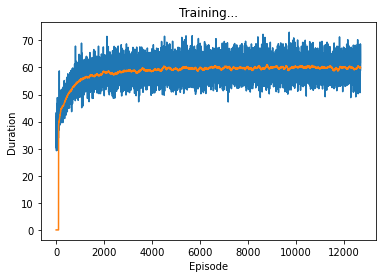

Current_train_num :  6003 Accuracy :  0.8114276195235716
F1 0.5473431881741909
685 538 595
train Current_train_num :  23995 Accuracy :  0.8049176911856637
F1 0.5158221302998965
2494 1820 2862
Current_train_num :  12709 LOSS :  -0.09501782804727554
0.022244270890951157
Current_train_num :  12719 LOSS :  -0.15739598870277405
0.0017065642168745399
Current_train_num :  12729 LOSS :  -0.23332321643829346
0.0024809499736875296
Current_train_num :  12739 LOSS :  -0.14871756732463837
0.005195879377424717
Current_train_num :  12749 LOSS :  -0.13977251946926117
0.0024037151597440243
Current_train_num :  12759 LOSS :  -0.08374843746423721
0.00378425233066082
Current_train_num :  12769 LOSS :  -0.025572706013917923
0.01485135592520237
Current_train_num :  12779 LOSS :  -0.12944865226745605
0.009577509015798569
Current_train_num :  12789 LOSS :  -0.028947994112968445
0.01871580444276333
Current_train_num :  12799 LOSS :  -0.18735986948013306
-0.0014609136851504445


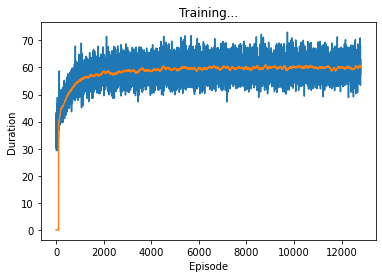

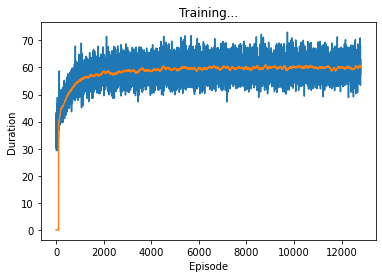

Current_train_num :  6003 Accuracy :  0.8114276195235716
F1 0.5473431881741909
685 538 595
train Current_train_num :  23995 Accuracy :  0.8049176911856637
F1 0.5159222497932175
2495 1821 2861
Current_train_num :  12809 LOSS :  -0.07996174693107605
0.003109472105279565
Current_train_num :  12819 LOSS :  -0.12406089901924133
0.0028210191521793604
Current_train_num :  12829 LOSS :  -0.13032053411006927
0.000984711921773851
Current_train_num :  12839 LOSS :  -0.10249236226081848
0.001983099151402712
Current_train_num :  12849 LOSS :  -0.13696201145648956
0.012075250037014484
Current_train_num :  12859 LOSS :  -0.02910902351140976
0.012796998023986816
Current_train_num :  12869 LOSS :  -0.03520072624087334
0.016494611278176308
Current_train_num :  12879 LOSS :  -0.023741070181131363
0.013538382016122341
Current_train_num :  12889 LOSS :  -0.13420839607715607
0.006147381849586964
Current_train_num :  12899 LOSS :  -0.0425080806016922
0.003628159873187542


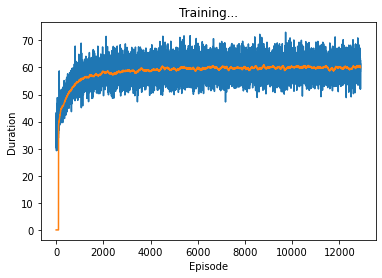

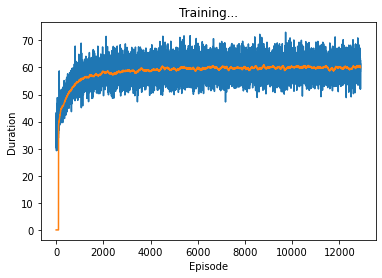

Current_train_num :  6003 Accuracy :  0.8114276195235716
F1 0.5473431881741909
685 538 595
train Current_train_num :  23995 Accuracy :  0.8048760158366326
F1 0.5157687932995554
2494 1821 2862
Current_train_num :  12909 LOSS :  -0.10622483491897583
0.002784071024507284
Current_train_num :  12919 LOSS :  -0.2609870731830597
0.006178752984851599
Current_train_num :  12929 LOSS :  -0.3278404772281647
-0.0023787827230989933
Current_train_num :  12939 LOSS :  -0.013540343381464481
0.0016495956806465983
Current_train_num :  12949 LOSS :  -0.07674186676740646
0.02033751644194126
Current_train_num :  12959 LOSS :  -0.23401732742786407
0.014816698618233204
Current_train_num :  12969 LOSS :  -0.11893721669912338
0.008807788603007793
Current_train_num :  12979 LOSS :  -0.09570154547691345
0.00954396091401577
Current_train_num :  12989 LOSS :  -0.1901720017194748
0.013610867783427238
Current_train_num :  12999 LOSS :  -0.09096933901309967
0.019637512043118477


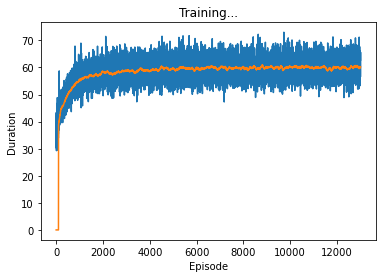

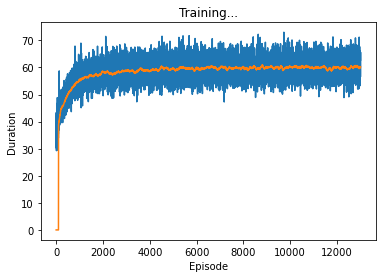

Current_train_num :  6003 Accuracy :  0.8114276195235716
F1 0.5473431881741909
685 538 595
train Current_train_num :  23995 Accuracy :  0.8049176911856637
F1 0.5160223278891876
2496 1822 2860
Current_train_num :  13009 LOSS :  -0.04816955327987671
0.008809453807771206
Current_train_num :  13019 LOSS :  -0.006028421688824892
0.013753993436694145
Current_train_num :  13029 LOSS :  -0.19108200073242188
0.006980763748288155
Current_train_num :  13039 LOSS :  -0.2389453947544098
0.0023272486869245768
Current_train_num :  13049 LOSS :  -0.009514234960079193
0.016225440427660942
Current_train_num :  13059 LOSS :  -0.12431730329990387
0.0018226344836875796
Current_train_num :  13069 LOSS :  -0.12041256576776505
0.004399836529046297
Current_train_num :  13079 LOSS :  -0.08390859514474869
0.007365538738667965
Current_train_num :  13089 LOSS :  -0.038690388202667236
0.0013936955947428942
Current_train_num :  13099 LOSS :  -0.07816296070814133
0.0013016760349273682


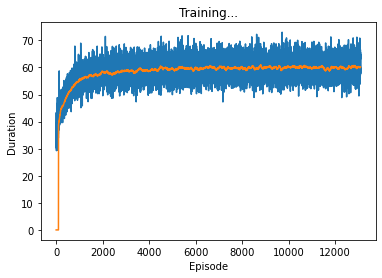

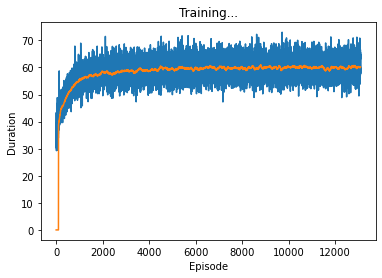

Current_train_num :  6003 Accuracy :  0.8114276195235716
F1 0.5473431881741909
685 538 595
train Current_train_num :  23995 Accuracy :  0.8048760158366326
F1 0.515968992248062
2496 1823 2860
Current_train_num :  13109 LOSS :  -0.2433553785085678
-0.0017236790154129267
Current_train_num :  13119 LOSS :  -0.04125933721661568
0.01494522299617529
Current_train_num :  13129 LOSS :  -0.0927286371588707
0.00516882911324501
Current_train_num :  13139 LOSS :  -0.1466318815946579
0.004147760104387999
Current_train_num :  13149 LOSS :  -0.2115171253681183
0.005192268174141645
Current_train_num :  13159 LOSS :  -0.11385325342416763
0.009019419550895691
Current_train_num :  13169 LOSS :  -0.11125324666500092
0.0015066243940964341
Current_train_num :  13179 LOSS :  -0.10047870129346848
0.0009474937687627971
Current_train_num :  13189 LOSS :  -0.09115190804004669
0.006203836295753717
Current_train_num :  13199 LOSS :  -0.04939727485179901
0.007607195060700178


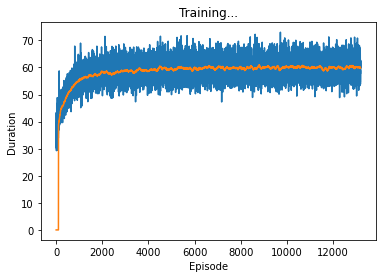

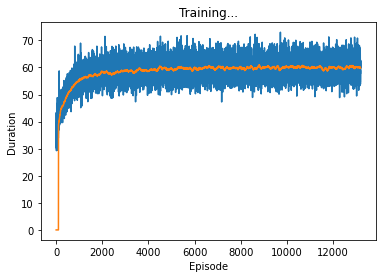

Current_train_num :  6003 Accuracy :  0.8114276195235716
F1 0.5473431881741909
685 538 595
train Current_train_num :  23995 Accuracy :  0.8049593665346947
F1 0.5160756745580481
2496 1821 2860
Current_train_num :  13209 LOSS :  -0.13846014440059662
0.00654907152056694
Current_train_num :  13219 LOSS :  -0.1186455711722374
0.0020281942561268806
Current_train_num :  13229 LOSS :  -0.14178508520126343
0.0004108570283278823
Current_train_num :  13239 LOSS :  -0.17155057191848755
0.005349357146769762
Current_train_num :  13249 LOSS :  -0.12268190830945969
0.010548092424869537
Current_train_num :  13259 LOSS :  -0.1396925449371338
0.010225081816315651
Current_train_num :  13269 LOSS :  -0.08228839188814163
0.008265869691967964
Current_train_num :  13279 LOSS :  -0.0748128816485405
0.011883771978318691
Current_train_num :  13289 LOSS :  -0.011649576015770435
0.013993904925882816
Current_train_num :  13299 LOSS :  -0.16990476846694946
0.004262922331690788


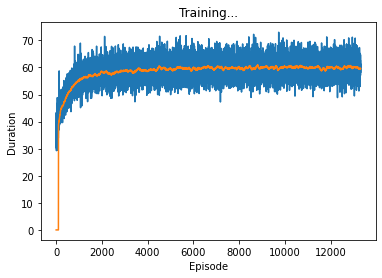

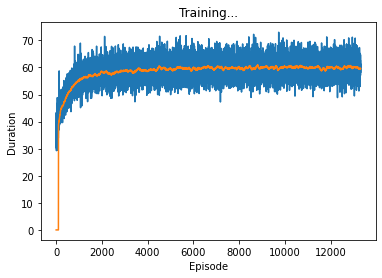

Current_train_num :  6003 Accuracy :  0.8114276195235716
F1 0.5473431881741909
685 538 595
train Current_train_num :  23995 Accuracy :  0.8049593665346947
F1 0.5160756745580481
2496 1821 2860
Current_train_num :  13309 LOSS :  -0.12571534514427185
0.012229922227561474
Current_train_num :  13319 LOSS :  -0.17393089830875397
0.004619220271706581
Current_train_num :  13329 LOSS :  -0.09163364768028259
0.01420074887573719
Current_train_num :  13339 LOSS :  -0.09773747622966766
0.007074153050780296
Current_train_num :  13349 LOSS :  -0.21417224407196045
0.001174854813143611
Current_train_num :  13359 LOSS :  -0.11490348726511002
0.0003680674999486655
Current_train_num :  13369 LOSS :  -0.14838601648807526
0.0031022662296891212
Current_train_num :  13379 LOSS :  -0.06602943688631058
0.008220802992582321
Current_train_num :  13389 LOSS :  -0.028613656759262085
0.0068392567336559296
Current_train_num :  13399 LOSS :  -0.15894389152526855
0.0042168027721345425


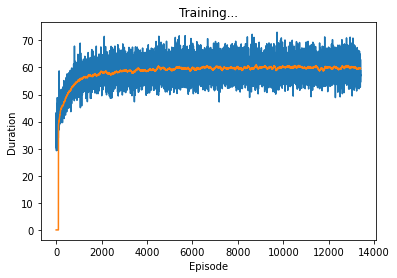

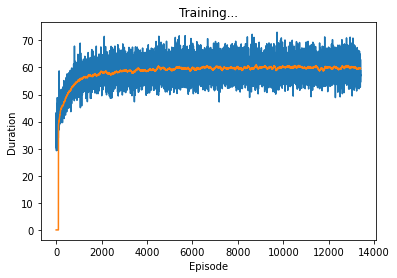

Current_train_num :  6003 Accuracy :  0.8114276195235716
F1 0.5473431881741909
685 538 595
train Current_train_num :  23995 Accuracy :  0.8049176911856637
F1 0.5160223278891876
2496 1822 2860
Current_train_num :  13409 LOSS :  -0.029054133221507072
0.025843102484941483
Current_train_num :  13419 LOSS :  -0.1967952698469162
0.004989504814147949
Current_train_num :  13429 LOSS :  -0.03525744006037712
0.006128143519163132
Current_train_num :  13439 LOSS :  -0.3220849335193634
0.001967177726328373
Current_train_num :  13449 LOSS :  -0.07910576462745667
0.00655991630628705
Current_train_num :  13459 LOSS :  -0.07951652258634567
0.001520128222182393
Current_train_num :  13469 LOSS :  -0.1194574311375618
0.0015927341300994158
Current_train_num :  13479 LOSS :  -0.18260905146598816
0.0034274437930434942
Current_train_num :  13489 LOSS :  -0.16418848931789398
0.00290646031498909
Current_train_num :  13499 LOSS :  -0.10080030560493469
0.005770302843302488


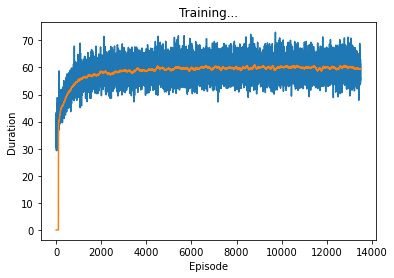

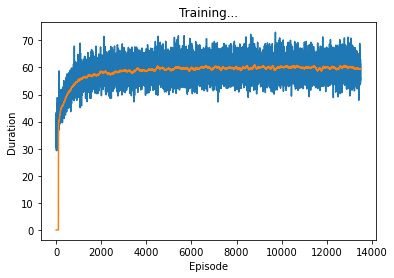

Current_train_num :  6003 Accuracy :  0.8114276195235716
F1 0.5473431881741909
685 538 595
train Current_train_num :  23995 Accuracy :  0.8049176911856637
F1 0.5160223278891876
2496 1822 2860
Current_train_num :  13509 LOSS :  -0.2556326985359192
0.007446757983416319
Current_train_num :  13519 LOSS :  -0.07947638630867004
0.00664741825312376
Current_train_num :  13529 LOSS :  -0.15232399106025696
0.0130438432097435
Current_train_num :  13539 LOSS :  -0.09648110717535019
0.00938420370221138
Current_train_num :  13549 LOSS :  -0.07873591780662537
0.011450422927737236
Current_train_num :  13559 LOSS :  -0.006252320483326912
0.013534550555050373
Current_train_num :  13569 LOSS :  -0.15257634222507477
0.001986537128686905
Current_train_num :  13579 LOSS :  -0.07121485471725464
0.007108279038220644
Current_train_num :  13589 LOSS :  -0.14342601597309113
0.006804830860346556
Current_train_num :  13599 LOSS :  -0.17810015380382538
0.0008339570485986769


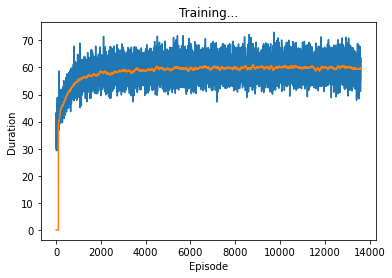

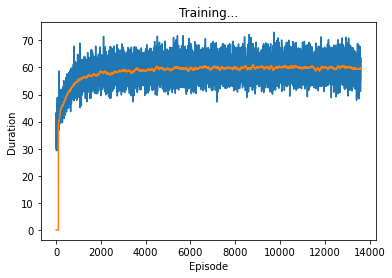

Current_train_num :  6003 Accuracy :  0.8112610361485924
F1 0.547486033519553
686 540 594
train Current_train_num :  23995 Accuracy :  0.8046259637424463
F1 0.5156492097923768
2496 1829 2860
Current_train_num :  13609 LOSS :  -0.12121883034706116
0.005393255967646837
Current_train_num :  13619 LOSS :  -0.08803825825452805
0.002204292919486761
Current_train_num :  13629 LOSS :  -0.03508562222123146
0.008500156924128532
Current_train_num :  13639 LOSS :  -0.09746303409337997
0.018253620713949203
Current_train_num :  13649 LOSS :  -0.09837621450424194
0.03349022567272186
Current_train_num :  13659 LOSS :  -0.1144881397485733
0.020545557141304016
Current_train_num :  13669 LOSS :  -0.05374111980199814
0.004848533775657415
Current_train_num :  13679 LOSS :  -0.00579619687050581
0.004968719091266394
Current_train_num :  13689 LOSS :  -0.10210143774747849
0.006040502805262804
Current_train_num :  13699 LOSS :  -0.13427570462226868
0.014612373895943165


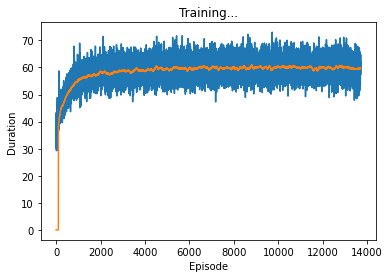

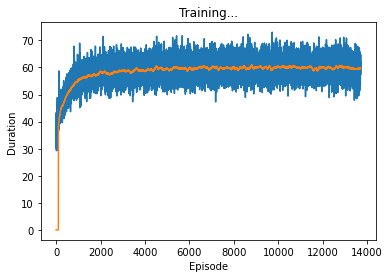

Current_train_num :  6003 Accuracy :  0.8110944527736131
F1 0.5472676505783806
686 541 594
train Current_train_num :  23995 Accuracy :  0.8047093144405084
F1 0.5160557563242127
2499 1830 2857
Current_train_num :  13709 LOSS :  -0.10271407663822174
0.0004417030140757561
Current_train_num :  13719 LOSS :  -0.11159103363752365
0.0065404558554291725
Current_train_num :  13729 LOSS :  -0.031663909554481506
0.03464813530445099
Current_train_num :  13739 LOSS :  -0.19595903158187866
0.0024289146531373262
Current_train_num :  13749 LOSS :  -0.07170427590608597
0.004008215386420488
Current_train_num :  13759 LOSS :  0.0016902575735002756
0.013060564175248146
Current_train_num :  13769 LOSS :  -0.06551402807235718
0.0023608277551829815
Current_train_num :  13779 LOSS :  -0.01680833287537098
0.010991268791258335
Current_train_num :  13789 LOSS :  -0.13545052707195282
0.0036238774191588163
Current_train_num :  13799 LOSS :  -0.11265251785516739
0.0051981681026518345


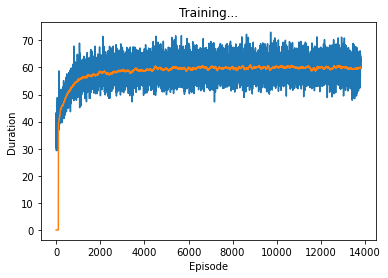

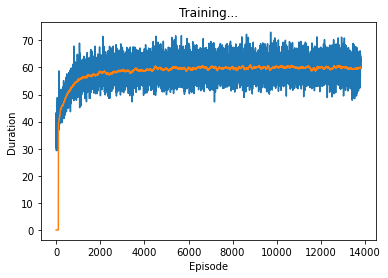

Current_train_num :  6003 Accuracy :  0.8110944527736131
F1 0.5472676505783806
686 541 594
train Current_train_num :  23995 Accuracy :  0.8047093144405084
F1 0.5160557563242127
2499 1830 2857
Current_train_num :  13809 LOSS :  -0.10227850079536438
0.009515738114714622
Current_train_num :  13819 LOSS :  -0.14219942688941956
0.0022194450721144676
Current_train_num :  13829 LOSS :  -0.12530207633972168
0.00031652592588216066
Current_train_num :  13839 LOSS :  -0.10266568511724472
0.0015278791543096304
Current_train_num :  13849 LOSS :  -0.2819957733154297
0.00258042523637414
Current_train_num :  13859 LOSS :  -0.03622954711318016
0.011006230488419533
Current_train_num :  13869 LOSS :  -0.13775992393493652
0.006531128194183111
Current_train_num :  13879 LOSS :  -0.10594814270734787
0.0037664338015019894
Current_train_num :  13889 LOSS :  -0.04237639531493187
0.005351030733436346
Current_train_num :  13899 LOSS :  -0.004375504329800606
0.019509846344590187


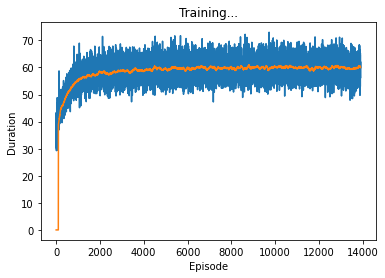

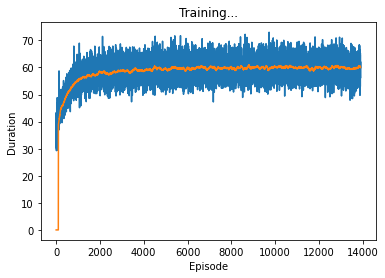

Current_train_num :  6003 Accuracy :  0.8107612860236548
F1 0.5475527258257064
688 545 592
train Current_train_num :  23995 Accuracy :  0.8046676390914774
F1 0.516202270381837
2501 1833 2855
Current_train_num :  13909 LOSS :  -0.06559133529663086
0.005110340192914009
Current_train_num :  13919 LOSS :  -0.32598966360092163
-0.0022865990176796913
Current_train_num :  13929 LOSS :  -0.22932496666908264
0.005683117546141148
Current_train_num :  13939 LOSS :  -0.03953780606389046
0.016731584444642067
Current_train_num :  13949 LOSS :  -0.11269102245569229
0.006732205394655466
Current_train_num :  13959 LOSS :  -0.057612281292676926
0.002153135370463133
Current_train_num :  13969 LOSS :  -0.06661510467529297
0.0034876891877502203
Current_train_num :  13979 LOSS :  -0.09510160237550735
0.003741499735042453
Current_train_num :  13989 LOSS :  -0.05751853808760643
0.00637726578861475
Current_train_num :  13999 LOSS :  -0.07932960242033005
0.003701405134052038


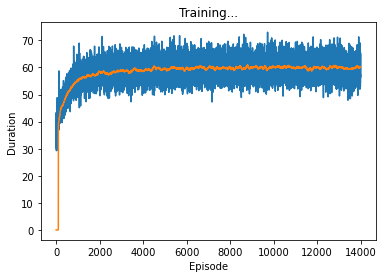

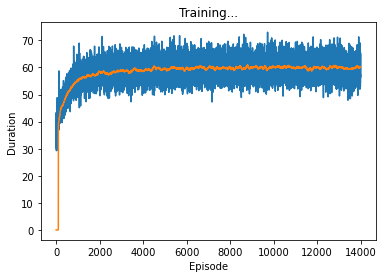

Current_train_num :  6003 Accuracy :  0.8104281192736965
F1 0.547117296222664
688 547 592
train Current_train_num :  23995 Accuracy :  0.8048760158366326
F1 0.5169675090252708
2506 1833 2850
Current_train_num :  14009 LOSS :  -0.1430598795413971
0.001562141696922481
Current_train_num :  14019 LOSS :  -0.33686181902885437
-0.0006539043388329446
Current_train_num :  14029 LOSS :  -0.09327187389135361
0.015309019014239311
Current_train_num :  14039 LOSS :  -0.22254306077957153
0.0031100998166948557
Current_train_num :  14049 LOSS :  -0.13028886914253235
0.014171697199344635
Current_train_num :  14059 LOSS :  -0.008562958799302578
0.01743193529546261
Current_train_num :  14069 LOSS :  -0.08943954110145569
0.0021099033765494823
Current_train_num :  14079 LOSS :  -0.3973069190979004
-0.0009558368474245071
Current_train_num :  14089 LOSS :  -0.2812452018260956
-0.001053722226060927
Current_train_num :  14099 LOSS :  -0.05472080036997795
0.00453991862013936


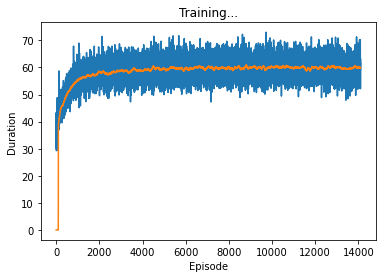

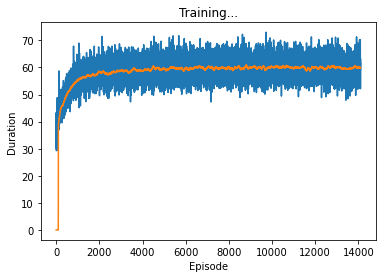

Current_train_num :  6003 Accuracy :  0.8110944527736131
F1 0.5469061876247505
685 540 595
train Current_train_num :  23995 Accuracy :  0.8047509897895395
F1 0.5161090458488228
2499 1829 2857
Current_train_num :  14109 LOSS :  -0.036076657474040985
0.009664872661232948
Current_train_num :  14119 LOSS :  -0.07464964687824249
0.014195644296705723
Current_train_num :  14129 LOSS :  -0.11191488802433014
0.0020672983955591917
Current_train_num :  14139 LOSS :  -0.16475598514080048
0.007898980751633644
Current_train_num :  14149 LOSS :  -0.13870128989219666
0.004537021275609732
Current_train_num :  14159 LOSS :  -0.22035111486911774
0.008438422344624996
Current_train_num :  14169 LOSS :  -0.029450008645653725
0.010259936563670635
Current_train_num :  14179 LOSS :  -0.064791738986969
0.0009658782510086894
Current_train_num :  14189 LOSS :  -0.17392930388450623
0.009414123371243477
Current_train_num :  14199 LOSS :  -0.22708289325237274
0.010755538940429688


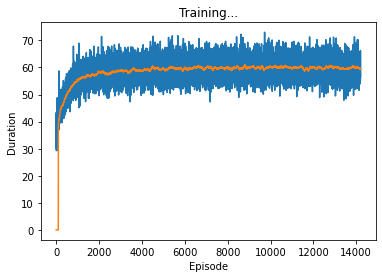

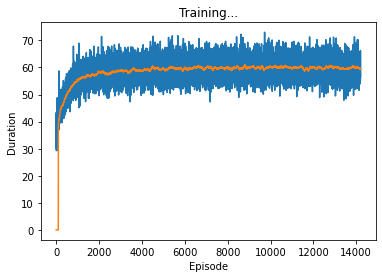

Current_train_num :  6003 Accuracy :  0.8112610361485924
F1 0.5471246006389776
685 539 595
train Current_train_num :  23995 Accuracy :  0.8047926651385705
F1 0.5158623540353415
2496 1825 2860
Current_train_num :  14209 LOSS :  -0.053392283618450165
0.002467253478243947
Current_train_num :  14219 LOSS :  -0.1340058594942093
0.010013208724558353
Current_train_num :  14229 LOSS :  -0.06602200120687485
0.0038684054743498564
Current_train_num :  14239 LOSS :  -0.02692161314189434
0.006123348604887724
Current_train_num :  14249 LOSS :  -0.054541923105716705
0.010003704577684402
Current_train_num :  14259 LOSS :  -0.05581757798790932
0.008392227813601494
Current_train_num :  14269 LOSS :  -0.07692859321832657
0.004311542492359877
Current_train_num :  14279 LOSS :  -0.04153980687260628
0.026658257469534874
Current_train_num :  14289 LOSS :  -0.18579719960689545
-0.0011604074388742447
Current_train_num :  14299 LOSS :  -0.154825821518898
0.003911804407835007


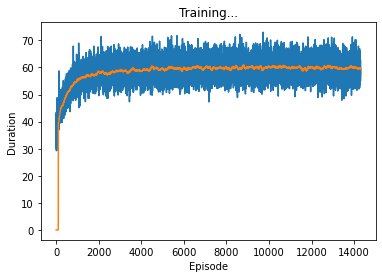

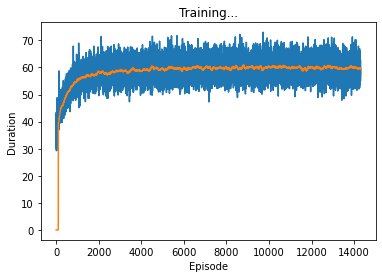

Current_train_num :  6003 Accuracy :  0.8112610361485924
F1 0.5471246006389776
685 539 595
train Current_train_num :  23995 Accuracy :  0.8047926651385705
F1 0.5159623928091746
2497 1826 2859
Current_train_num :  14309 LOSS :  -0.14273995161056519
0.012394947931170464
Current_train_num :  14319 LOSS :  -0.48450973629951477
-0.003403585636988282
Current_train_num :  14329 LOSS :  -0.07990861684083939
0.0053960829973220825
Current_train_num :  14339 LOSS :  -0.11033313721418381
0.009628198109567165
Current_train_num :  14349 LOSS :  -0.059130262583494186
0.00462535722181201
Current_train_num :  14359 LOSS :  -0.06792660057544708
0.008167109452188015
Current_train_num :  14369 LOSS :  -0.08191604912281036
0.0005492838681675494
Current_train_num :  14379 LOSS :  -0.0016040813643485308
0.01564156636595726
Current_train_num :  14389 LOSS :  -0.32920533418655396
-0.004025293979793787
Current_train_num :  14399 LOSS :  -0.22208037972450256
0.0023562919814139605


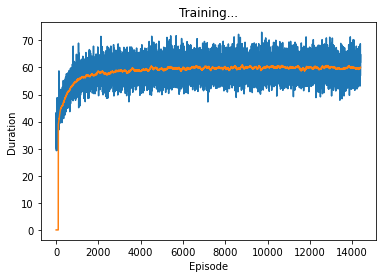

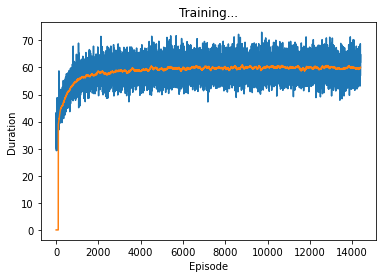

Current_train_num :  6003 Accuracy :  0.8107612860236548
F1 0.5471923536439666
687 544 593
train Current_train_num :  23995 Accuracy :  0.8047509897895395
F1 0.5163088356729976
2501 1831 2855
Current_train_num :  14409 LOSS :  -0.14568161964416504
0.011988540180027485
Current_train_num :  14419 LOSS :  -0.23072056472301483
0.01973944529891014
Current_train_num :  14429 LOSS :  -0.15678340196609497
0.0013596893986687064
Current_train_num :  14439 LOSS :  -0.06393035501241684
0.004660137929022312
Current_train_num :  14449 LOSS :  -0.1634356528520584
-0.0010636307997629046
Current_train_num :  14459 LOSS :  -0.3112950325012207
0.0003344738215673715
Current_train_num :  14469 LOSS :  -0.028059639036655426
0.0042298221960663795
Current_train_num :  14479 LOSS :  -0.11012688279151917
0.0005155939725227654
Current_train_num :  14489 LOSS :  -0.12536637485027313
0.0019370573572814465
Current_train_num :  14499 LOSS :  -0.010933518409729004
0.009436187334358692


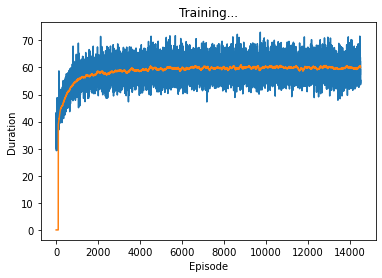

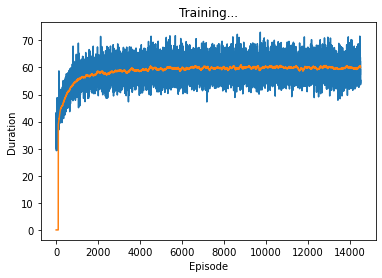

Current_train_num :  6003 Accuracy :  0.8112610361485924
F1 0.5471246006389776
685 539 595
train Current_train_num :  23995 Accuracy :  0.8048760158366326
F1 0.515968992248062
2496 1823 2860
Current_train_num :  14509 LOSS :  -0.12099535763263702
0.0004776878922712058
Current_train_num :  14519 LOSS :  -0.11360537260770798
0.032108161598443985
Current_train_num :  14529 LOSS :  -0.0508408322930336
0.0023012871388345957
Current_train_num :  14539 LOSS :  -0.024362986907362938
0.003991841804236174
Current_train_num :  14549 LOSS :  -0.05974961072206497
0.004746951628476381
Current_train_num :  14559 LOSS :  -0.02408934012055397
0.004904279951006174
Current_train_num :  14569 LOSS :  -0.11940783262252808
0.010529344901442528
Current_train_num :  14579 LOSS :  -0.06836230307817459
0.015638526529073715
Current_train_num :  14589 LOSS :  -0.11767023801803589
0.0008048487943597138
Current_train_num :  14599 LOSS :  -0.12682145833969116
0.005716790445148945


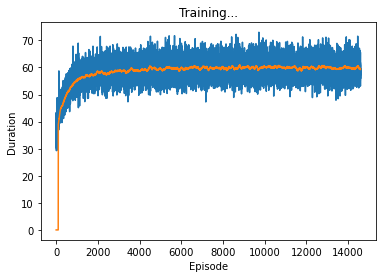

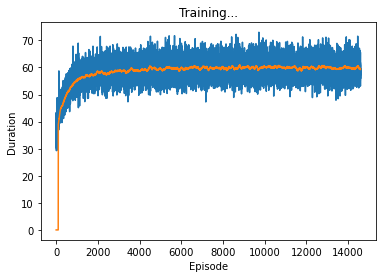

Current_train_num :  6003 Accuracy :  0.8112610361485924
F1 0.5471246006389776
685 539 595
train Current_train_num :  23995 Accuracy :  0.8047926651385705
F1 0.5158623540353415
2496 1825 2860
Current_train_num :  14609 LOSS :  -0.0723331868648529
0.004588063340634108
Current_train_num :  14619 LOSS :  -0.10788742452859879
0.0013189427554607391
Current_train_num :  14629 LOSS :  -0.27076274156570435
0.007414240390062332
Current_train_num :  14639 LOSS :  -0.08331669121980667
0.018397776409983635
Current_train_num :  14649 LOSS :  -0.12702970206737518
0.007899224758148193
Current_train_num :  14659 LOSS :  -0.05268862470984459
0.0018712249584496021
Current_train_num :  14669 LOSS :  -0.05857846885919571
0.00292368046939373
Current_train_num :  14679 LOSS :  -0.10661181807518005
0.0020988055039197206
Current_train_num :  14689 LOSS :  -0.023419363424181938
0.014423474669456482
Current_train_num :  14699 LOSS :  -0.028642455115914345
0.0035241872537881136


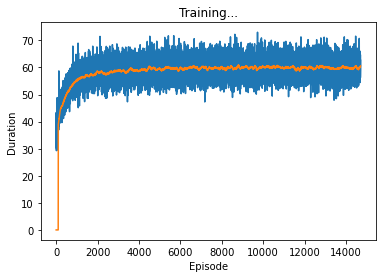

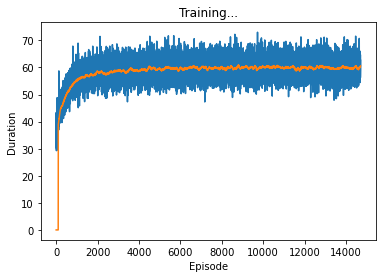

Current_train_num :  6003 Accuracy :  0.8112610361485924
F1 0.547486033519553
686 540 594
train Current_train_num :  23995 Accuracy :  0.8047509897895395
F1 0.5158090514569126
2496 1826 2860
Current_train_num :  14709 LOSS :  -0.19900040328502655
0.002127797342836857
Current_train_num :  14719 LOSS :  -0.17921261489391327
0.007013825234025717
Current_train_num :  14729 LOSS :  -0.325530081987381
-0.004263893235474825
Current_train_num :  14739 LOSS :  -0.10683701932430267
0.018877951428294182
Current_train_num :  14749 LOSS :  -0.15613627433776855
0.012242385186254978
Current_train_num :  14759 LOSS :  -0.041437193751335144
0.010534803383052349
Current_train_num :  14769 LOSS :  -0.08937898278236389
0.0053103468380868435
Current_train_num :  14779 LOSS :  -0.030114680528640747
0.002342324936762452
Current_train_num :  14789 LOSS :  -0.18921947479248047
0.0051730056293308735
Current_train_num :  14799 LOSS :  -0.14576469361782074
0.002332013566046953


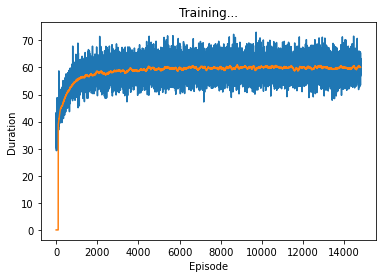

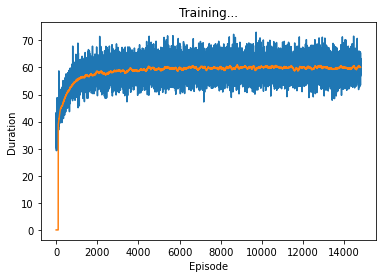

Current_train_num :  6003 Accuracy :  0.8112610361485924
F1 0.547486033519553
686 540 594
train Current_train_num :  23995 Accuracy :  0.8047509897895395
F1 0.5158090514569126
2496 1826 2860
Current_train_num :  14809 LOSS :  -0.24235525727272034
-0.002096252515912056
Current_train_num :  14819 LOSS :  -0.2751561105251312
0.006427109241485596
Current_train_num :  14829 LOSS :  -0.11984791606664658
0.0030334535986185074
Current_train_num :  14839 LOSS :  -0.06169258803129196
0.0043297396041452885
Current_train_num :  14849 LOSS :  -0.004786403384059668
0.0025069527328014374
Current_train_num :  14859 LOSS :  -0.14771749079227448
0.0020989745389670134
Current_train_num :  14869 LOSS :  -0.19260579347610474
0.0054799290373921394
Current_train_num :  14879 LOSS :  -0.017737943679094315
0.02177220769226551
Current_train_num :  14889 LOSS :  -0.1038222461938858
0.0016606763238087296
Current_train_num :  14899 LOSS :  -0.1447693556547165
0.008702010847628117


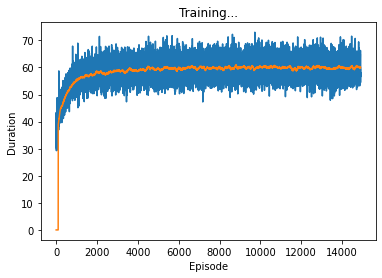

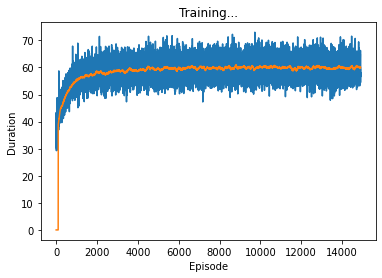

Current_train_num :  6003 Accuracy :  0.8112610361485924
F1 0.5482071713147411
688 542 592
train Current_train_num :  23995 Accuracy :  0.8047926651385705
F1 0.5164619671792755
2502 1831 2854
Current_train_num :  14909 LOSS :  -0.17998969554901123
0.0015898472629487514
Current_train_num :  14919 LOSS :  -0.1278090626001358
0.010323289781808853
Current_train_num :  14929 LOSS :  -0.22248448431491852
0.0013034924631938338
Current_train_num :  14939 LOSS :  -0.03351699933409691
0.0066881123930215836
Current_train_num :  14949 LOSS :  -0.12784123420715332
0.005063213407993317
Current_train_num :  14959 LOSS :  -0.05550248175859451
0.011017453856766224
Current_train_num :  14969 LOSS :  -0.015681620687246323
0.020099300891160965
Current_train_num :  14979 LOSS :  -0.11604555696249008
0.009539692662656307
Current_train_num :  14989 LOSS :  -0.1389363706111908
0.004858786705881357
Current_train_num :  14999 LOSS :  -0.028272194787859917
0.007515708450227976


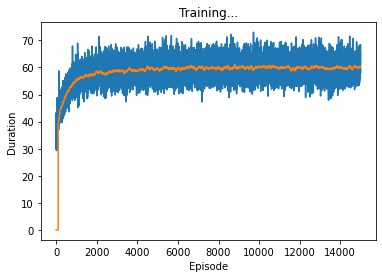

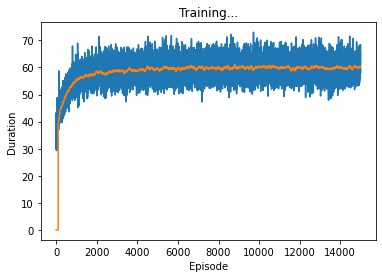

Current_train_num :  6003 Accuracy :  0.8107612860236548
F1 0.5475527258257064
688 545 592
train Current_train_num :  23995 Accuracy :  0.8047509897895395
F1 0.5166082112646998
2504 1834 2852


In [20]:
total_accuracy = []
total_reward = []
test_num = 6004
## Traing set을 이용한 학습 
F1=0
##
for i_num in range(15000):
    ## Batch size 크기 만큼의 Trajectory가 만들어짐.
    
    trajectory = normalized_train[np.random.choice(normalized_train.shape[0],BATCH_SIZE,replace =False),:]
    #print(trajectory[:5])
    total_acc = 0
    total_re=0
    ## Discout factor
    GAMMA =1.0
    ## Trajectory를 만듬 길이는 BATCH_SIZE
    ## Gradient Descent
    optimizer.zero_grad()
    loss = 0
    total_loss = 0
    total_loss2=0
    loss2=0
    ## Trajectory를 따라가면서 학습
    for t in range(BATCH_SIZE) :      
        ## state를 tensor로 바꿔서 이용
        state = trajectory[t][1:24]
        
        #print(state.shape)
        state = torch.FloatTensor(state)
        state = Variable(state)
        ## Classification Target
        target = trajectory[t][24]
        #print(target)
        target1 =-1*trajectory[t][0]
        ## Action을 선택하기 위해 이항분포 => Discrete Action space
        probs = policy_net(state)
        m = Bernoulli(probs)
        #print('M',m)
        action = m.sample()
        action = action.data.numpy().astype(int)[0]
        ## With Discout reward
        reward,accuracy,tp,tn,fp,fn= get_reward(action,target)
        rew,accu,tp1,tn1,fp1,fn1= get_reward1(action,target,target1)
        if t >1 : 
            reward = reward * GAMMA
        #total_acc += accuracy
        
        GAMMA = GAMMA*GAMMA
        
        loss = -m.log_prob(action) * reward 
        loss2 = -m.log_prob(action) * rew ## Negtive score function x reward
        total_loss += loss
        total_loss2+=loss2
        total_re+=rew
   # print('?',-m.log_prob(action))
    #print('?',probs)
    #total_accuracy.append(total_acc)
    #print(total_accuracy)
    total_reward.append(total_re)
    loss = total_loss / BATCH_SIZE
    loss2=total_loss2/BATCH_SIZE
    if (i_num+1) % 10 == 0 :
        print('Current_train_num : ',i_num, "LOSS : ",loss.item())
        print(loss2.item())
    loss2.backward()
    ## Optimize
    optimizer.step()
    scheduler.step()
    if (i_num+1) % 100 == 0 :
        #total_reward.append(reward)
        plot_durations(total_reward)
       # plot_durations(total_loss)
    
    if (i_num+1) % 100 == 0 :
        #total_reward.append(reward)
        plot_durations(total_reward)
       # plot_durations(total_loss)
        ttp=0
        ffp=0
        ffn=0
        for i_num1 in range(test_num):

            state = normalized_test[i_num1][1:24]

            ## state를 tensor로 바꿔서 이용
            state = torch.FloatTensor(state)
            state = Variable(state)
            ## Classification Target
            target = normalized_test[i_num1][24]

            ## Action을 선택하기 위해 이항분포 => Discrete Action space
            probs = policy_net(state)
            #print(probs)
            #try:
            #m = torch.distributions.categorical.Categorical(probs)
            #print(probs)
            #if torch.round(probs) != torch.round(m):
             #   print('shit')
            #action = m.sample()
            #print(probs)
        #print(probs)
            action = torch.round(probs).detach().numpy()
            action = action.astype('int')
            #print(action)
            #if torch.round(probs) != action:
            #    print('shit')
            _,accuracy,tp,tn,fp,fn= get_reward(action,target)
            ttp+=tp
            ffp+=fp
            ffn+=fn
            total_acc += accuracy
            total_accuracy.append(total_acc)
        #except:
               # print(probs)
        print('Current_train_num : ',i_num1, "Accuracy : ",total_acc / i_num1)
        print('F1',(2*ttp)/(2*ttp+ffp+ffn))
        print(ttp,ffp,ffn)
       
        
        if F1<(2*ttp)/(2*ttp+ffp+ffn):
            F1=(2*ttp)/(2*ttp+ffp+ffn)
            
            torch.save(policy_net,'e_0521_it.t7')
            print(i_num)
            
            
            
            
    if (i_num+1) % 100 == 0 :
        #total_reward.append(reward)
        #plot_durations(total_reward)
       # plot_durations(total_loss)
        ttp=0
        ffp=0
        ffn=0
        total_acc=0
        for i_num1 in range(len(normalized_train)):

            state = normalized_train[i_num1][1:24]

            ## state를 tensor로 바꿔서 이용
            state = torch.FloatTensor(state)
            state = Variable(state)
            ## Classification Target
            target = normalized_train[i_num1][24]

            ## Action을 선택하기 위해 이항분포 => Discrete Action space
            probs = policy_net(state)
            #print(probs)
            #try:
            #m = torch.distributions.categorical.Categorical(probs)
            #print(probs)
            #if torch.round(probs) != torch.round(m):
             #   print('shit')
            #action = m.sample()
            #print(probs)
        #print(probs)
            action = torch.round(probs).detach().numpy()
            action = action.astype('int')
            #print(action)
            #if torch.round(probs) != action:
            #    print('shit')
            _,accuracy,tp,tn,fp,fn= get_reward(action,target)
            ttp+=tp
            ffp+=fp
            ffn+=fn
            total_acc += accuracy
            total_accuracy.append(total_acc)
        #except:
               # print(probs)
        print('train','Current_train_num : ',i_num1, "Accuracy : ",total_acc / i_num1)
        print('F1',(2*ttp)/(2*ttp+ffp+ffn))
        print(ttp,ffp,ffn)
       
        

In [21]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0001
    lr: 4.000000000000001e-06
    weight_decay: 0
)

In [22]:
0.001*0.2

0.0002

In [23]:
28427/53*0.01

5.363584905660377